In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System utilities
import os
import pickle
from pathlib import Path
from datetime import datetime
import warnings
import time
import math

# Data handling and numerical computation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
from upsetplot import UpSet, from_memberships
from plot_utils import proportion
from utils import plot_upset
from utils import scatter_df
import matplotlib.ticker as ticker

# Single-cell analysis and related packages
import anndata as ad
import scanpy as sc
import squidpy as sq

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='numpy')
warnings.filterwarnings('ignore', category=FutureWarning, module='scanpy')
warnings.filterwarnings('ignore', category=UserWarning, module='scanpy')
warnings.filterwarnings('ignore', category=UserWarning, module='numpy')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Performance
from joblib import Parallel, delayed

# Function to print the current time with a message
def print_with_time(message):
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {message}")

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['pdf.fonttype'] = 42  # Ensures text is stored as text, not paths
plt.rcParams['ps.fonttype'] = 42


C:\Users\ard212.PITT\Anaconda3\envs\py311\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
C:\Users\ard212.PITT\Anaconda3\envs\py311\Lib\site-packages\xarray_schema\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
C:\Users\ard212.PITT\Anaconda3\envs\py311\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Polygon
from shapely.ops import unary_union

def convert2gpd(df):
    # Step 1: Group the DataFrame by 'cell_id' or similar, assuming each cell has a unique ID
    # Ensure that your DataFrame has an identifier for each cell
    grouped = df.groupby('cell_id')

    # Step 2: Create polygons for each group of cell boundaries
    polygons = []

    for cell_id, group in grouped:
        # Extract the x and y coordinates for this cell
        points = group[['vertex_x', 'vertex_y']].values
        
        # Create a Polygon from these points
        # Ensure the points form a valid polygon (e.g., no crossing lines)
        if len(points) > 2:  # A polygon needs at least 3 points
            poly = Polygon(points)
            polygons.append({'cell_id': cell_id, 'geometry': poly})

    # Step 3: Create a GeoPandas DataFrame from the list of polygons
    gdf = gpd.GeoDataFrame(polygons)
    return gdf

In [4]:

def plot_color_palette(color_dict, title, pdf):
    labels = list(color_dict.keys())
    colors = list(color_dict.values())
    num_colors = len(colors)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(5, num_colors // 2))

    # Plot each color as a horizontal bar
    for i, (label, color) in enumerate(zip(labels, colors)):
        ax.barh(i, 1, color=color)
        ax.text(0.5, i, label, va='center', ha='center', fontsize=10, color='white', fontweight='bold')

    # Remove axes
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Set title
    ax.set_title(title, fontweight='bold')

    # Save the current figure to the PDF
    if pdf:
        pdf.savefig(fig)
    plt.show()
    plt.close(fig)

In [5]:
# Process samples
samples = ['KS_TMA_1_0026870', 'KS_TMA_2_0026882', 'KS_TMA_3_0027198', 'KS_TMA_4_0026764', 'KS_TMA_5_0026776',
           'KS_TMA_6_0027092', 'KS_TMA_7_0027079', 'KS_TMA_8_0027273', 'KS_TMA_9_0026831', 'KS_TMA_10_0026828',
           'KS_TMA_11_0026930', 'KS_TMA_12_0026888', 'KS_TMA_13_0027077', 'KS_TMA_14_0027019', 'KS_TMA_15_0033811',
          'KS_TMA_16_0033809']

marker_list_df_all = pd.read_csv('data/marker_list_dev_standardized_short.csv')
marker_list_df = marker_list_df_all.copy()
marker_list_df = marker_list_df.query(f"Annotation not in ['Vascular Endothelial Cells', 'Lymphatic Endothelial Cells']")

# Define cell types and clusters
cell_types = list(marker_list_df.keys())

marker_list = marker_list_df
marker_list = marker_list.groupby('grouped_cts')['Gene'].unique().reset_index()
marker_list = marker_list.set_index('grouped_cts')['Gene'].apply(list).to_dict()

complete_cell_types = list(marker_list_df['grouped_cts'].unique())
marker_genes_dict = marker_list

In [6]:
df = pd.read_csv('data/marker_list_dev_standardized_short.csv')

In [11]:
# Process samples
samples = ['KS_TMA_1_0026870', 'KS_TMA_2_0026882', 'KS_TMA_3_0027198', 'KS_TMA_4_0026764', 'KS_TMA_5_0026776',
           'KS_TMA_6_0027092', 'KS_TMA_7_0027079', 'KS_TMA_8_0027273', 'KS_TMA_9_0026831', 'KS_TMA_10_0026828', 
           'KS_TMA_11_0026930', 'KS_TMA_12_0026888', 'KS_TMA_13_0027077', 'KS_TMA_14_0027019', 'KS_TMA_15_0033811',
          'KS_TMA_16_0033809']

adata = sc.read_h5ad('data/KS_adata_celltyped_v9_n30_c10_no_duplicates.h5ad')

adata.obs['niches'] = adata.obs.niche_with_tumor_proximity.copy()


adata.obsm["spatial"] = adata.obs[["local_x", "local_y"]].copy().to_numpy()

In [13]:
KS_lytic_genes = ['KSHV.ORF50', 'KSHV.ORF57', 'KSHV.ORF59', 'KSHV.K9', 'KSHV.ORF65'] 
KS_latent_genes = ['KSHV.ORF71','KSHV.ORF72','KSHV.ORF73',] 
KS_K2_gene = ['KSHV.K2']

nctc_neighbors = 30
n_clusters = 10

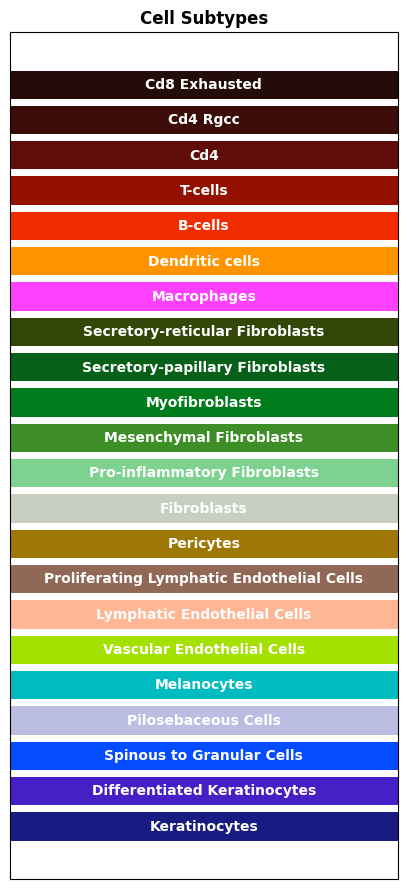

In [14]:
sub_cell_types_color_mapping = {
    'Keratinocytes': '#181c82',
    'Differentiated Keratinocytes': '#471fc7',
    'Spinous to Granular Cells': '#034cff',
    'Pilosebaceous Cells': '#bbbde2',
    'Melanocytes': '#00bbbf',

    'Vascular Endothelial Cells': '#a4e000',
    'Lymphatic Endothelial Cells': '#ffb695',
    'Proliferating Lymphatic Endothelial Cells': '#906855',
    'Pericytes': '#9f7704',
    
    'Fibroblasts': '#c7d0c0',
    'Pro-inflammatory Fibroblasts': '#7cd28e',
    'Mesenchymal Fibroblasts': '#3d8e27',
    'Myofibroblasts': '#007c1d',
    'Secretory-papillary Fibroblasts': '#076018',
    'Secretory-reticular Fibroblasts': '#324708',
    
    'Macrophages': '#ff40ff',
    'Dendritic cells': '#ff9300',
    'B-cells': '#f12d00',
    'T-cells': '#941100',
    'Cd4': '#600c09',
    'Cd4 Rgcc': '#3c0c09',
    'Cd8 Exhausted': '#240c09',
}


with PdfPages('figures/sub_cell_types_color_mapping.pdf') as pdf:
    plot_color_palette(sub_cell_types_color_mapping, "Cell Subtypes", pdf)

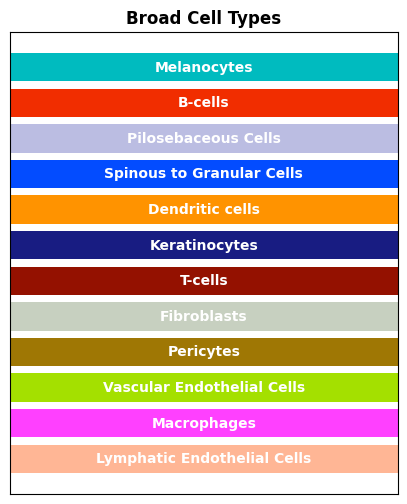

In [15]:
broad_cell_types_color_mapping = {\
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages': '#ff40ff',
    'Vascular Endothelial Cells': '#a4e000',
    'Pericytes': '#9f7704',
    'Fibroblasts': '#c7d0c0',
    'T-cells': '#941100',
    'Keratinocytes': '#181c82',
    'Dendritic cells': '#ff9300',
    'Spinous to Granular Cells': '#034cff',
    'Pilosebaceous Cells': '#bbbde2',
    'B-cells': '#f12d00',
    'Melanocytes': '#00bbbf'
}

with PdfPages('figures/broad_cell_types_color_mapping.pdf') as pdf:
    plot_color_palette(broad_cell_types_color_mapping, "Broad Cell Types", pdf)

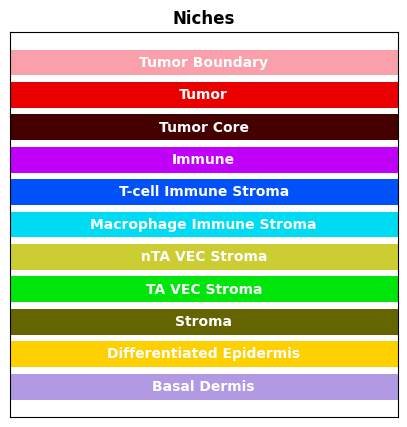

In [16]:
niche_colors = {
    #SKIN
    "Basal Dermis": "#b299e3",
    "Differentiated Epidermis": "#ffd000",
 
    # STROMA
    "Stroma": "#646500",
    "TA VEC Stroma": "#00e50c",
    "nTA VEC Stroma": "#cccc33",
    
    # IMMUNE
    "Macrophage Immune Stroma": "#00dbf4",
    "T-cell Immune Stroma": "#0051f9",
    "Immune": "#c100f9",
 
    # TUMOR
    "Tumor Core": "#450000",
    "Tumor": "#eb0000",
    "Tumor Boundary": "#faa0aa"
}


with PdfPages('figures/niches_color_mapping.pdf') as pdf:
    plot_color_palette(niche_colors, "Niches", pdf)

In [17]:

# Define colors for different stages
stage_colors = {
    'nodular': '#ed322f',  # Light Red
    'plaque': '#ffdc5e',   # Light Yellow
    'patch': '#51f512',    # Light Green
    'control': '#D3D3D3'   # Light Gray
}


niche_colors = {
    #SKIN
    "Basal Dermis": "#b299e3",
    "Differentiated Epidermis": "#ffd000",
 
    # STROMA
    "Stroma": "#646500",
    "TA VEC Stroma": "#00e50c",
    "nTA VEC Stroma": "#cccc33",
    
    # IMMUNE
    "Macrophage Immune Stroma": "#00dbf4",
    "T-cell Immune Stroma": "#0051f9",
    "Immune": "#c100f9",
 
    # TUMOR
    "Tumor Core": "#450000",
    "Tumor": "#eb0000",
    "Tumor Boundary": "#faa0aa"
}


broad_cell_types_color_mapping = {\
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages': '#ff40ff',
    'Vascular Endothelial Cells': '#a4e000',
    'Pericytes': '#9f7704',
    'Fibroblasts': '#c7d0c0',
    'T-cells': '#941100',
    'Keratinocytes': '#181c82',
    'Dendritic cells': '#ff9300',
    'Spinous to Granular Cells': '#034cff',
    'Pilosebaceous Cells': '#bbbde2',
    'B-cells': '#f12d00',
    'Melanocytes': '#00bbbf'
}



# Heatmaps with color grid, line and bar plots

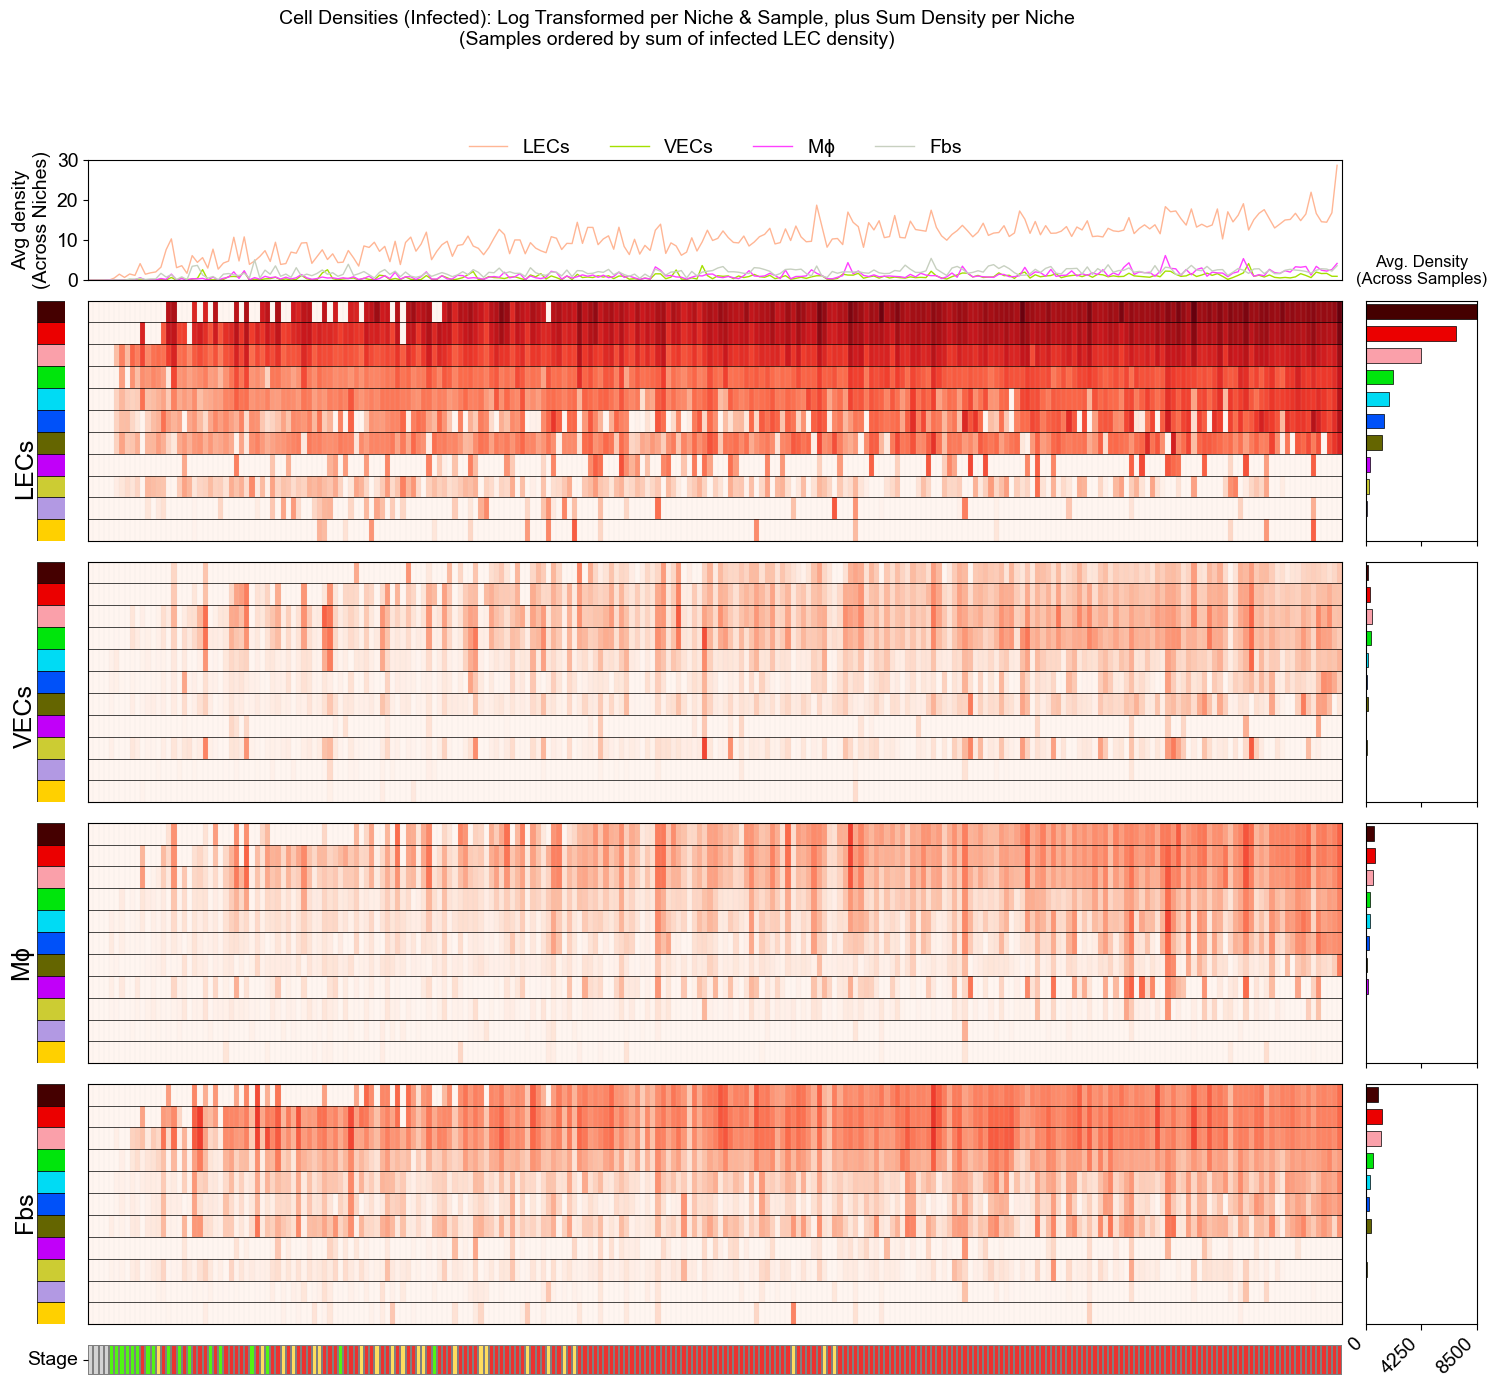

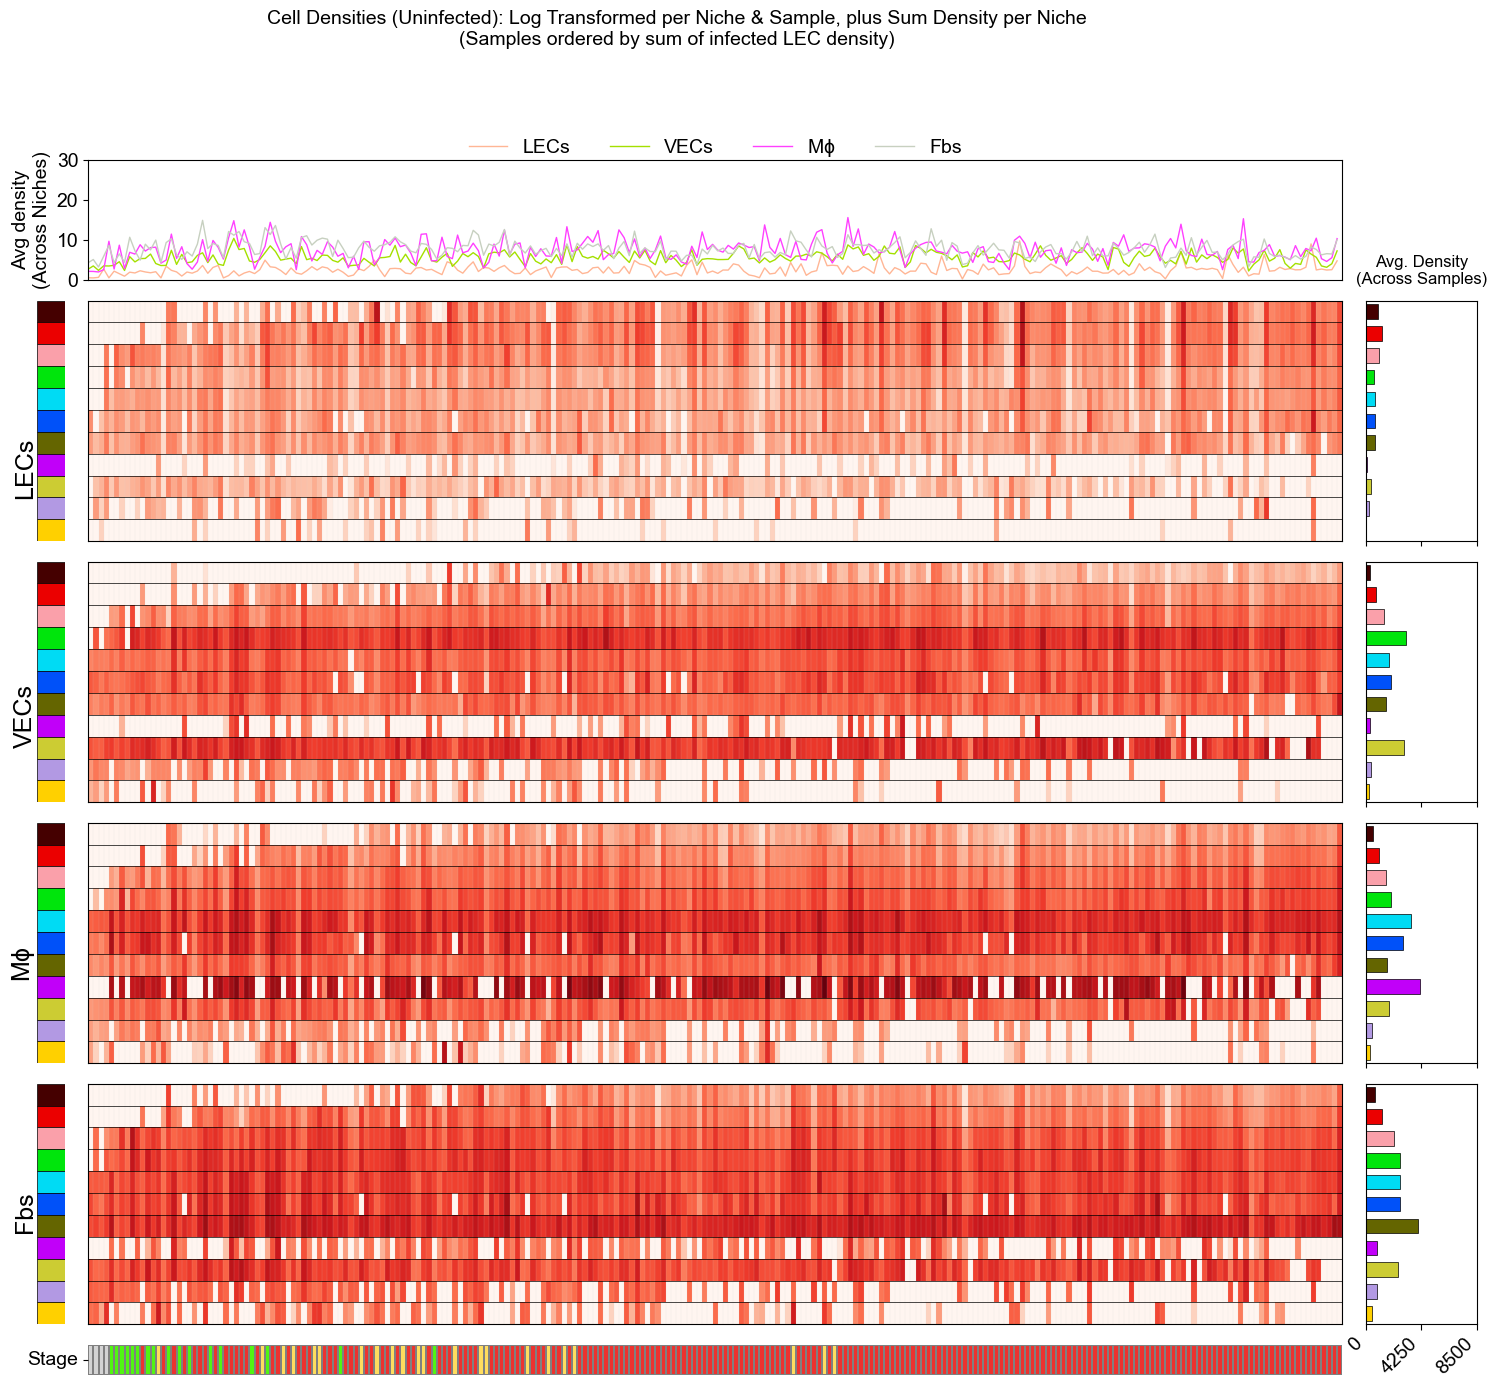

In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
# Ensures all text (including math text) uses Arial
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
# Embed fonts correctly in PDFs/PS
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
# Base font size
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS COMMON TO BOTH PLOTS
# ───────────────────────────────────────────────────────────
# Define the vertical order of niches
niche_order = [
    'Tumor Core', 'Tumor', 'Tumor Boundary', 'TA VEC Stroma',
    'Macrophage Immune Stroma', 'T-cell Immune Stroma', 'Stroma',
    'Immune', 'VEC Stroma', 'Basal Dermis', 'Differentiated Epidermis'
]

# Abbreviations for the line‐plot legend
abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

# Colors for each niche stripe
niche_colors = {
    "Basal Dermis":               "#b299e3",
    "Differentiated Epidermis":   "#ffd000",
    "Stroma":                     "#646500",
    "TA VEC Stroma":              "#00e50c",
    "VEC Stroma":                 "#cccc33",
    "Macrophage Immune Stroma":   "#00dbf4",
    "T-cell Immune Stroma":       "#0051f9",
    "Immune":                     "#c100f9",
    "Tumor Core":                 "#450000",
    "Tumor":                      "#eb0000",
    "Tumor Boundary":             "#faa0aa"
}

# Heatmap colormap for densities
cmap = 'Reds'

# Colors for each cell type’s line in the top plot
cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

# Ensure the output directory exists
os.makedirs('figures/spacetime', exist_ok=True)

# Mapping from cell types → infected density columns in adata.obs
cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'density_infected_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'density_infected_Vascular_Endothelial_Cells',
    'Macrophages':                 'density_infected_Macrophages',
    'Fibroblasts':                 'density_infected_Fibroblasts',
}

# Automatically derive the “uninfected” mapping by replacing 'infected' → 'uninfected'
cell_types_and_cols_uninfected = {
    ct: col.replace('infected', 'uninfected')
    for ct, col in cell_types_and_cols_infected.items()
}


def plot_spacetime(cell_types_and_cols, label_suffix):
    """
    Generate “stripe + heatmaps + barplots + stage row” for infected or uninfected cells.
    - Top: line plot of average density per cell type (across niches).
    - Middle: for each cell type, show a colored niche‐stripe, a heatmap of log densities,
      and a barplot of sum density per niche.
    - Bottom: a single row colored by sample stage (nodular/plaque/patch/control).
    The first bar‐plot has a title “Avg. Density (Across Samples)”.
    """
    # ───────────────────────────────────────────────────────────
    # (2A) ORDER SAMPLES BY TOTAL LEC DENSITY (so all panels share this x‐order)
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    # Group by sample (“path_block_core”), sum LEC density, then sort ascending
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2B) BUILD RAW DENSITY MATRICES (Niche × Sample) FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, col in cell_types_and_cols.items():
        # Subset adata.obs rows for this cell type
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Fallback if exact match yields no rows
        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Compute mean density per (niche, sample)
        df = obs_ct.groupby(
            ['niche_with_tumor_proximity', 'path_block_core']
        )[col].mean()

        # Pivot so rows = niche_order, cols = sample_order; fill missing with 0
        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(index=niche_order, columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (2C) LOG-TRANSFORM EACH MATRIX & COMPUTE GLOBAL vmin/Vmax FOR HEATMAPS
    # ───────────────────────────────────────────────────────────
    heatmaps_log = {ct: np.log1p(mat) for ct, mat in heatmaps.items()}
    all_vals = np.concatenate([hm.values.flatten() for hm in heatmaps_log.values()])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

    # ───────────────────────────────────────────────────────────
    # (2D) COMPUTE PER-SAMPLE AVERAGE DENSITY (FOR TOP LINE PLOT)
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)  # mean across niches for each sample
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (2D.1) COMPUTE SUM DENSITY PER NICHE (FOR BAR PLOTS)
    # ───────────────────────────────────────────────────────────
    cell_types_to_plot = list(cell_types_and_cols.keys())
    sum_densities = {
        ct: heatmaps[ct].sum(axis=1)   # sum across all samples for each niche
        for ct in cell_types_to_plot
    }
    max_sum = max(series.max() for series in sum_densities.values())

    # ───────────────────────────────────────────────────────────
    # (2E) PREPARE FIGURE & GRIDSPEC
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)  # x positions for line plot
    n_celltypes = len(cell_types_to_plot)

    # Create a figure: width=20, height scaled by (#celltypes+1) rows
    fig = plt.figure(figsize=(20, 3 * (n_celltypes + 1)))

    # Define height ratios: top row=0.4, each celltype row=0.8, bottom stage row=0.3
    height_ratios = [0.4] + [0.8] * n_celltypes + [0.1]

    # Use GridSpec with (n_celltypes+2) rows: 
    #   row 0 = line plot
    #   rows 1..n_celltypes = stripe+heatmap+bar
    #   row n_celltypes+1 = stage row
    gs = fig.add_gridspec(
        nrows = n_celltypes + 2,
        ncols = 3,
        width_ratios  = [0.02, 0.9, 0.08],  # narrow stripe, wide heatmap, narrow bar
        height_ratios = height_ratios,
        hspace = 0.11,
        wspace = 0.05
    )

    # ─── (2G) TOP ROW: BLANK + LINE PLOT ─────────────────────────────────
    ax_blank_top = fig.add_subplot(gs[0, 0])
    ax_blank_top.set_visible(False)  # hide the tiny stripe cell

    ax_top = fig.add_subplot(gs[0, 1])
    for ct in cell_types_to_plot:
        ax_top.plot(
            x,
            avg_densities[ct].values,
            label = abbrev_labels[ct],
            color = cell_types_color_dict.get(ct, 'black'),
            linewidth = 1,
        )

    # Show only three x‐ticks: 0, mid, max
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax_top.set_ylabel('Avg density\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)

    ax_top.legend(
        ncol = len(cell_types_to_plot),
        bbox_to_anchor = (0.5, 1.34),  # move legend above the plot
        loc = 'upper center',
        fontsize = 14,
        frameon = False
    )
    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(0, 30)

    # ─── (2H) MIDDLE ROWS: FOR EACH CELL TYPE → STRIPE | HEATMAP | BAR PLOT ───
    heat_axes = []
    bar_axes = []

    for i, ct in enumerate(cell_types_to_plot):
        # (2H.1) NICHE‐COLOR STRIPE (leftmost narrow column)
        ax_color = fig.add_subplot(gs[i + 1, 0])
        n_rows_stripe = len(niche_order)

        ax_color.set_xlim(0, 1)
        ax_color.set_ylim(n_rows_stripe, 0)
        ax_color.margins(0)
        ax_color.set_xticks([])
        ax_color.set_yticks([])
        ax_color.set_frame_on(False)

        # Draw one Rectangle per niche
        for row_idx, niche_name in enumerate(niche_order):
            rect = Rectangle(
                (0, row_idx), 1, 1,
                facecolor = niche_colors[niche_name],
                edgecolor = 'black',
                linewidth = 0.5,
                zorder = 2
            )
            ax_color.add_patch(rect)

        # (2H.2) HEATMAP (middle wide column)
        if i == 0:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=ax_top)
        else:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=heat_axes[0])
        heat_axes.append(ax_heat)

        density_ct_log = heatmaps_log[ct]
        n_rows, n_cols_heat = density_ct_log.shape

        sns.heatmap(
            density_ct_log,
            ax = ax_heat,
            cmap = cmap,
            vmin = vmin,
            vmax = vmax,
            cbar = False,
            linewidths = 0,
            linecolor = '#d3d3d3',
            xticklabels = False,
            yticklabels = False,
            square = False
        )

        # Remove x‐axis labels/ticks on intermediate heatmaps
        ax_heat.set_xlabel('')
        ax_heat.xaxis.label.set_visible(False)
        ax_heat.set_xticklabels([])

        # Draw thin grey vertical grid lines between columns
        for x_line in range(n_cols_heat + 1):
            ax_heat.vlines(
                x_line, 0, n_rows,
                colors = '#d3d3d3',
                linewidth = 0.1,
                zorder = 1
            )
        # Draw black horizontal lines between niches
        for y_line in range(n_rows + 1):
            ax_heat.hlines(
                y_line, 0, n_cols_heat,
                colors = 'black',
                linewidth = 0.5,
                zorder = 2
            )
        # Turn on spines around heatmap
        for side in ['top', 'bottom', 'left', 'right']:
            ax_heat.spines[side].set_visible(True)
            ax_heat.spines[side].set_linewidth(0.8)
            ax_heat.spines[side].set_edgecolor('black')

        ax_heat.set_ylabel('')
        ax_heat.tick_params(axis='y', length=0)

        # (2H.3) BAR PLOT (rightmost narrow column)
        if i == 0:
            ax_bar = fig.add_subplot(gs[i + 1, 2])
            # Add title above the first bar‐plot
            ax_bar.set_title("Avg. Density\n(Across Samples)", fontsize=12, pad=12)
        else:
            ax_bar = fig.add_subplot(gs[i + 1, 2], sharex=bar_axes[0])
        bar_axes.append(ax_bar)

        # Compute sum density per niche in the correct niche_order
        sums = sum_densities[ct].reindex(niche_order)

        # Space out bars by a factor of 1.2 but keep bar thickness default
        spacing = 1.2
        y_positions = np.arange(len(niche_order)) * spacing

        ax_bar.barh(
            y_positions,
            sums.values,
            color=[niche_colors[n] for n in niche_order],
            edgecolor='black',
            linewidth=0.5
        )

        # Fix x‐axis limit to [0, 8500] for all bar plots
        ax_bar.set_xlim(0, 8500)
        # Set y‐limits so bars are centered with half‐spacing margins
        ax_bar.set_ylim(
            spacing * len(niche_order) - spacing / 2,
            -spacing / 2
        )
        ax_bar.set_yticks([])

        # Show x‐tick labels only on the bottommost bar plot
        if i == n_celltypes - 1:
            ax_bar.set_xticks([0, 4250, 8500])
            ax_bar.set_xticklabels(
                [0, 4250, 8500],
                fontsize=14,
                rotation=45,
                ha='right'
            )
            ax_bar.xaxis.set_tick_params(length=4)
        else:
            ax_bar.xaxis.set_tick_params(labelbottom=False)

        # Turn on spines around bar plot
        for side in ['top', 'bottom', 'left', 'right']:
            ax_bar.spines[side].set_visible(True)
            ax_bar.spines[side].set_linewidth(0.8)
            ax_bar.spines[side].set_edgecolor('black')

    # ─── (2I) ADD ROTATED CELL‐TYPE LABELS ON LEFT SIDE ─────────────────────
    for ax, ct in zip(heat_axes, cell_types_to_plot):
        pos = ax.get_position()
        y_center = pos.y0 + pos.height / 2
        # Draw the abbreviation at left, centered vertically
        fig.text(
            0.18,
            y_center,
            abbrev_labels[ct],
            rotation=90,
            ha='right',
            va='center',
            fontsize=18
        )

    # ─── (2J) BOTTOM ROW: STAGE HEATMAP ─────────────────────────────────
    # 1) Define colors for each stage
    stage_colors = {
        'nodular': '#ed322f',  # Light Red
        'plaque':  '#ffdc5e',  # Light Yellow
        'patch':   '#51f512',  # Light Green
        'control': '#D3D3D3'   # Light Gray
    }
    # 2) Determine each sample’s stage (mode of 'Stage' per 'path_block_core')
    sample_stage = (
        adata.obs
        .groupby('path_block_core')['Stage']
        .agg(lambda x: x.mode().iloc[0])  # use the most frequent stage
        .astype(str)
        .reindex(sample_order)
    )
    # 3) Map each sample to its color
    stage_colors_list = sample_stage.map(stage_colors).fillna('#FFFFFF').values

    # Create the bottom‐row axes: one for stripe (blank), one for stage heatmap, one blank for bar column
    ax_stage_stripe = fig.add_subplot(gs[n_celltypes + 1, 0])
    ax_stage_stripe.set_visible(False)

    ax_stage = fig.add_subplot(gs[n_celltypes + 1, 1])
    # Convert stages to categorical codes & build a DataFrame with a single row
    stages_cat = sample_stage.astype('category')
    codes = stages_cat.cat.codes.values[np.newaxis, :]
    lut = [stage_colors[s] for s in stages_cat.cat.categories]
    cmap_stage = mcolors.ListedColormap(lut)
    df_stage = pd.DataFrame(codes, index=['Stage'], columns=sample_order)

    # Plot a 1×N “heatmap” of stages (no colorbar)
    sns.heatmap(
        df_stage,
        ax=ax_stage,
        cmap=cmap_stage,
        cbar=False,
        xticklabels=False,
        yticklabels=['Stage'],
        linewidths=0.1,
        linecolor='gray'
    )
    ax_stage.tick_params(axis='y', labelsize=14, rotation=0)
    # Hide spines around the stage row
    for spine in ax_stage.spines.values():
        spine.set_visible(False)

    ax_stage_bar = fig.add_subplot(gs[n_celltypes + 1, 2])
    ax_stage_bar.set_visible(False)

    # ─── (2K) FINAL FIGURE LAYOUT & SAVE ────────────────────────────────
    plt.xlabel('')
    plt.suptitle(
        f'Cell Densities ({label_suffix.capitalize()}): '
        'Log Transformed per Niche & Sample, plus Sum Density per Niche\n'
        '(Samples ordered by sum of infected LEC density)',
        fontsize=14,
        y=1.02
    )
    plt.tight_layout()
    plt.subplots_adjust(left=0.18, top=0.92)

    outfile = f"figures/spacetime/log_density_{label_suffix}_cell_density_with_summary.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# ───────────────────────────────────────────────────────────
# (3) RUN PLOTTING FOR BOTH INFECTED AND UNINFECTED
# ───────────────────────────────────────────────────────────
plot_spacetime(cell_types_and_cols_infected, label_suffix='infected')
plot_spacetime(cell_types_and_cols_uninfected, label_suffix='uninfected')


In [ ]:
lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
# Group by sample (“path_block_core”), sum LEC density, then sort ascending
lec_means = adata.obs.groupby('path_block_core')[lec_col].sum()
sample_order = lec_means.sort_values(ascending=True).index.tolist()



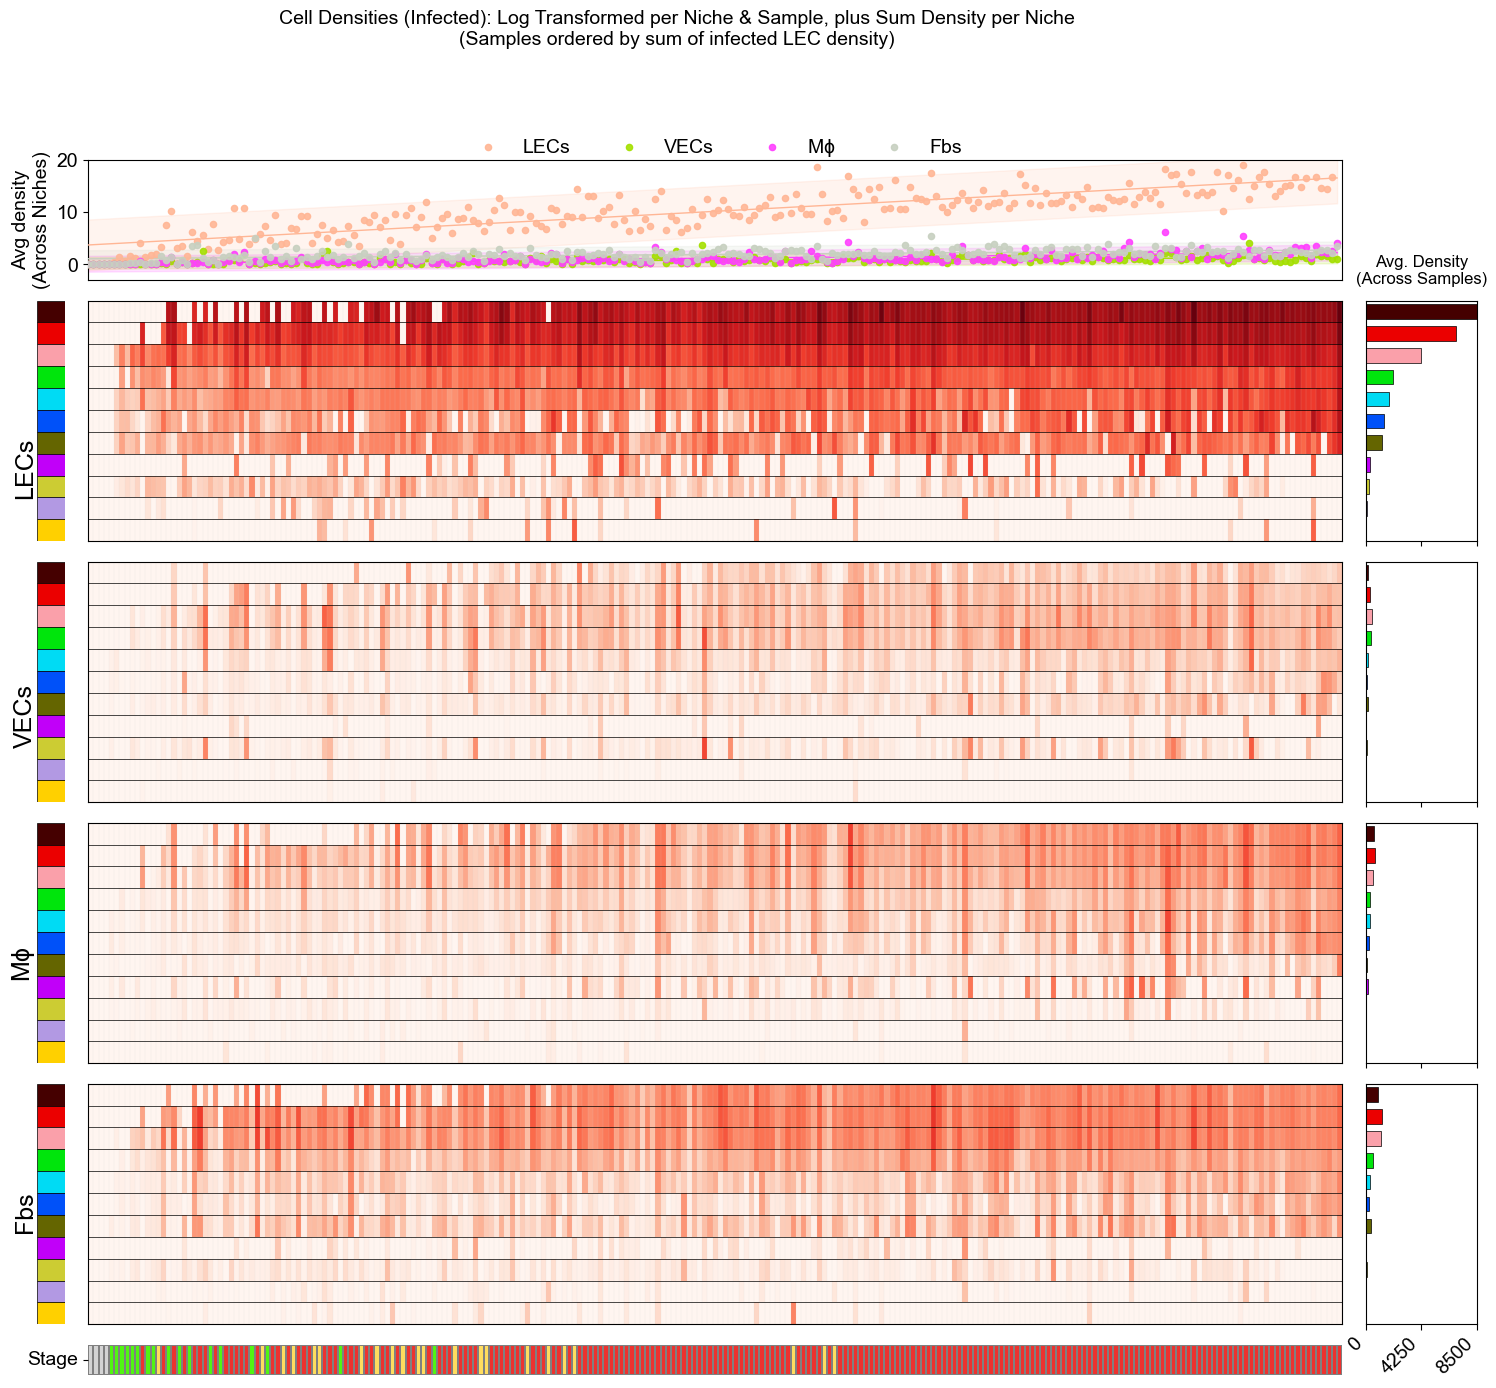

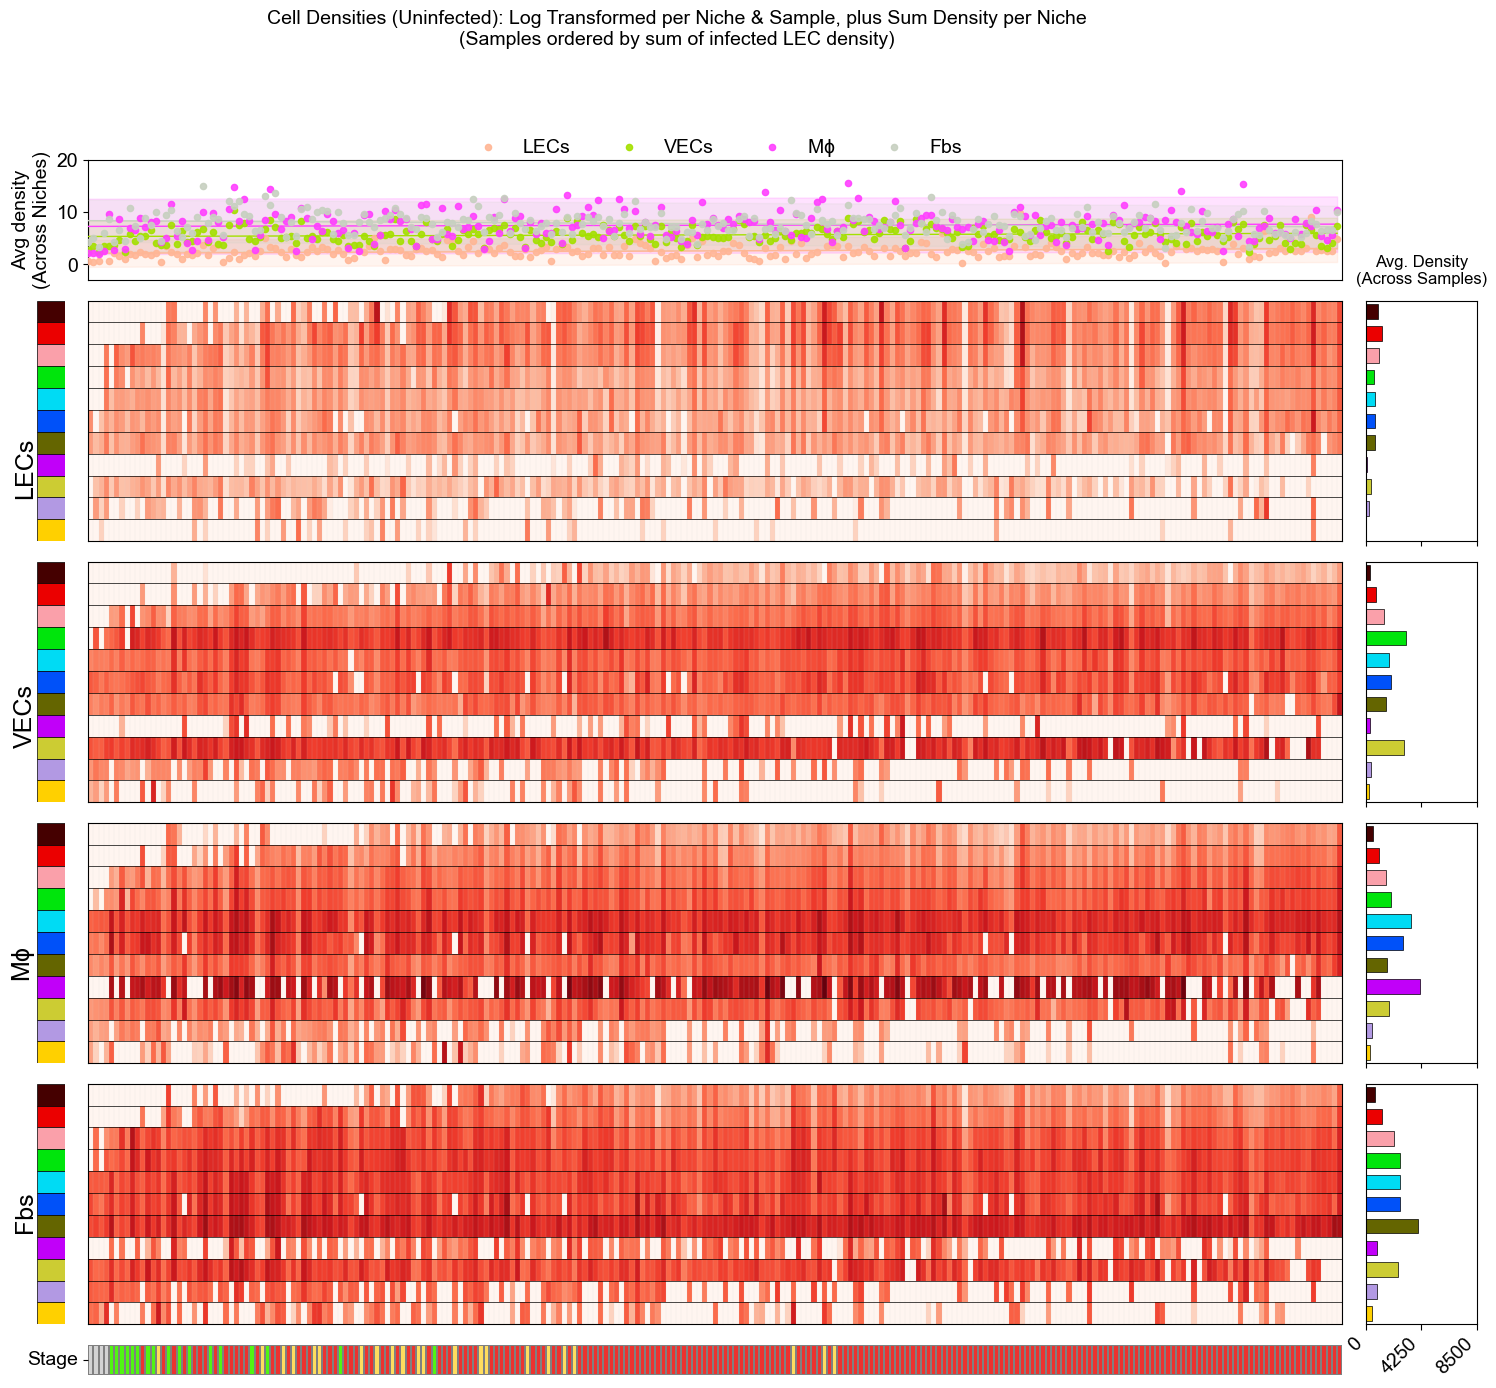

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import statsmodels.api as sm
from scipy import stats

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
# Ensures all text (including math text) uses Arial
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
# Embed fonts correctly in PDFs/PS
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
# Base font size
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS COMMON TO BOTH PLOTS
# ───────────────────────────────────────────────────────────
# Define the vertical order of niches
niche_order = [
    'Tumor Core', 'Tumor', 'Tumor Boundary', 'TA VEC Stroma',
    'Macrophage Immune Stroma', 'T-cell Immune Stroma', 'Stroma',
    'Immune', 'VEC Stroma', 'Basal Dermis', 'Differentiated Epidermis'
]

# Abbreviations for the line‐plot legend
abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

# Colors for each niche stripe
niche_colors = {
    "Basal Dermis":               "#b299e3",
    "Differentiated Epidermis":   "#ffd000",
    "Stroma":                     "#646500",
    "TA VEC Stroma":              "#00e50c",
    "VEC Stroma":                 "#cccc33",
    "Macrophage Immune Stroma":   "#00dbf4",
    "T-cell Immune Stroma":       "#0051f9",
    "Immune":                     "#c100f9",
    "Tumor Core":                 "#450000",
    "Tumor":                      "#eb0000",
    "Tumor Boundary":             "#faa0aa"
}

# Heatmap colormap for densities
cmap = 'Reds'

# Colors for each cell type’s line in the top plot
cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

# Ensure the output directory exists
os.makedirs('figures/spacetime', exist_ok=True)

# Mapping from cell types → infected density columns in adata.obs
cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'density_infected_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'density_infected_Vascular_Endothelial_Cells',
    'Macrophages':                 'density_infected_Macrophages',
    'Fibroblasts':                 'density_infected_Fibroblasts',
}

# Automatically derive the “uninfected” mapping by replacing 'infected' → 'uninfected'
cell_types_and_cols_uninfected = {
    ct: col.replace('infected', 'uninfected')
    for ct, col in cell_types_and_cols_infected.items()
}


def plot_spacetime(cell_types_and_cols, label_suffix):
    """
    Generate “stripe + heatmaps + barplots + stage row” for infected or uninfected cells.
    - Top: line plot of average density per cell type (across niches).
    - Middle: for each cell type, show a colored niche‐stripe, a heatmap of log densities,
      and a barplot of sum density per niche.
    - Bottom: a single row colored by sample stage (nodular/plaque/patch/control).
    The first bar‐plot has a title “Avg. Density (Across Samples)”.
    """
    # ───────────────────────────────────────────────────────────
    # (2A) ORDER SAMPLES BY TOTAL LEC DENSITY (so all panels share this x‐order)
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    # Group by sample (“path_block_core”), sum LEC density, then sort ascending
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2B) BUILD RAW DENSITY MATRICES (Niche × Sample) FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, col in cell_types_and_cols.items():
        # Subset adata.obs rows for this cell type
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Fallback if exact match yields no rows
        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Compute mean density per (niche, sample)
        df = obs_ct.groupby(
            ['niche_with_tumor_proximity', 'path_block_core']
        )[col].mean()

        # Pivot so rows = niche_order, cols = sample_order; fill missing with 0
        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(index=niche_order, columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (2C) LOG-TRANSFORM EACH MATRIX & COMPUTE GLOBAL vmin/Vmax FOR HEATMAPS
    # ───────────────────────────────────────────────────────────
    heatmaps_log = {ct: np.log1p(mat) for ct, mat in heatmaps.items()}
    all_vals = np.concatenate([hm.values.flatten() for hm in heatmaps_log.values()])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

    # ───────────────────────────────────────────────────────────
    # (2D) COMPUTE PER-SAMPLE AVERAGE DENSITY (FOR TOP LINE PLOT)
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)  # mean across niches for each sample
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (2D.1) COMPUTE SUM DENSITY PER NICHE (FOR BAR PLOTS)
    # ───────────────────────────────────────────────────────────
    cell_types_to_plot = list(cell_types_and_cols.keys())
    sum_densities = {
        ct: heatmaps[ct].sum(axis=1)   # sum across all samples for each niche
        for ct in cell_types_to_plot
    }
    max_sum = max(series.max() for series in sum_densities.values())

    # ───────────────────────────────────────────────────────────
    # (2E) PREPARE FIGURE & GRIDSPEC
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)  # x positions for line plot
    n_celltypes = len(cell_types_to_plot)

    # Create a figure: width=20, height scaled by (#celltypes+1) rows
    fig = plt.figure(figsize=(20, 3 * (n_celltypes + 1)))

    # Define height ratios: top row=0.4, each celltype row=0.8, bottom stage row=0.3
    height_ratios = [0.4] + [0.8] * n_celltypes + [0.1]

    # Use GridSpec with (n_celltypes+2) rows: 
    #   row 0 = line plot
    #   rows 1..n_celltypes = stripe+heatmap+bar
    #   row n_celltypes+1 = stage row
    gs = fig.add_gridspec(
        nrows = n_celltypes + 2,
        ncols = 3,
        width_ratios  = [0.02, 0.9, 0.08],  # narrow stripe, wide heatmap, narrow bar
        height_ratios = height_ratios,
        hspace = 0.11,
        wspace = 0.05
    )

    # ─── (2G) TOP ROW: BLANK + SCATTER + LINE + 95% PREDICTION INTERVAL BAND ─────────────────────────────
    ax_blank_top = fig.add_subplot(gs[0, 0])
    ax_blank_top.set_visible(False)  # hide the tiny stripe cell
    
    ax_top = fig.add_subplot(gs[0, 1])
    for ct in cell_types_to_plot:
        # X = sample‐index array, Y = avg density for this cell type
        Y = avg_densities[ct].values
        X = x  # already defined as np.arange(n_cols)
    
        # 1) Scatter the raw points
        ax_top.scatter(
            X,
            Y,
            label = abbrev_labels[ct],
            color = cell_types_color_dict.get(ct, 'black'),
            s = 20,
            alpha = 0.9,
            zorder = 4
        )
    
        # 2) Fit an OLS line (with intercept). Build design matrix:
        X_with_const = sm.add_constant(X)  # adds a column of 1′s
        ols_model = sm.OLS(Y, X_with_const).fit()
    
        # 3) Compute the fitted line (mean prediction) at each X:
        Y_pred = ols_model.predict(X_with_const)
    
        # 4) Compute the 95% PREDICTION‐INTERVAL band:
        #    - n = number of points
        #    - df = n − 2  (two parameters: slope and intercept)
        #    - t_val = t‐statistic for 0.975 quantile
        #    - MSE_resid = σ² estimate from the model
        n = len(X)
        df = n - 2
        t_val = stats.t.ppf(0.975, df)
    
        #    - Mean of X, and sum of squares:
        X_mean = X.mean()
        SSx = np.sum((X - X_mean) ** 2)
        sigma_hat = np.sqrt(ols_model.mse_resid)  # residual standard error
    
        #    - For each x_i, the standard error of prediction is:
        #        se_pred(x_i) = σ * sqrt(1 + 1/n + (x_i − X_mean)² / SSx)
        se_pred = sigma_hat * np.sqrt(
            1.0
            + 1.0 / n
            + ((X - X_mean) ** 2) / SSx
        )
    
        #    - Now compute upper & lower PI:
        PI_upper = Y_pred + t_val * se_pred
        PI_lower = Y_pred - t_val * se_pred
    
        # 5) Plot the fitted line itself:
        ax_top.plot(
            X,
            Y_pred,
            color = cell_types_color_dict.get(ct, 'black'),
            linewidth = 1,
            zorder = 3
        )
    
        # 6) Fill between upper & lower to draw a 95% prediction band:
        ax_top.fill_between(
            X,
            PI_lower,
            PI_upper,
            color = cell_types_color_dict.get(ct, 'black'),
            alpha = 0.15,
            zorder = 2
        )
    
    # Show only three x‐ticks: 0, mid, max
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')
    
    ax_top.set_ylabel('Avg density\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)
    
    ax_top.legend(
        ncol = len(cell_types_to_plot),
        bbox_to_anchor = (0.5, 1.34),  # move legend above the plot
        loc = 'upper center',
        fontsize = 14,
        frameon = False
    )
    
    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(-3, 20)




    # ─── (2H) MIDDLE ROWS: FOR EACH CELL TYPE → STRIPE | HEATMAP | BAR PLOT ───
    heat_axes = []
    bar_axes = []

    for i, ct in enumerate(cell_types_to_plot):
        # (2H.1) NICHE‐COLOR STRIPE (leftmost narrow column)
        ax_color = fig.add_subplot(gs[i + 1, 0])
        n_rows_stripe = len(niche_order)

        ax_color.set_xlim(0, 1)
        ax_color.set_ylim(n_rows_stripe, 0)
        ax_color.margins(0)
        ax_color.set_xticks([])
        ax_color.set_yticks([])
        ax_color.set_frame_on(False)

        # Draw one Rectangle per niche
        for row_idx, niche_name in enumerate(niche_order):
            rect = Rectangle(
                (0, row_idx), 1, 1,
                facecolor = niche_colors[niche_name],
                edgecolor = 'black',
                linewidth = 0.5,
                zorder = 2
            )
            ax_color.add_patch(rect)

        # (2H.2) HEATMAP (middle wide column)
        if i == 0:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=ax_top)
        else:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=heat_axes[0])
        heat_axes.append(ax_heat)

        density_ct_log = heatmaps_log[ct]
        n_rows, n_cols_heat = density_ct_log.shape

        sns.heatmap(
            density_ct_log,
            ax = ax_heat,
            cmap = cmap,
            vmin = vmin,
            vmax = vmax,
            cbar = False,
            linewidths = 0,
            linecolor = '#d3d3d3',
            xticklabels = False,
            yticklabels = False,
            square = False
        )

        # Remove x‐axis labels/ticks on intermediate heatmaps
        ax_heat.set_xlabel('')
        ax_heat.xaxis.label.set_visible(False)
        ax_heat.set_xticklabels([])

        # Draw thin grey vertical grid lines between columns
        for x_line in range(n_cols_heat + 1):
            ax_heat.vlines(
                x_line, 0, n_rows,
                colors = '#d3d3d3',
                linewidth = 0.1,
                zorder = 1
            )
        # Draw black horizontal lines between niches
        for y_line in range(n_rows + 1):
            ax_heat.hlines(
                y_line, 0, n_cols_heat,
                colors = 'black',
                linewidth = 0.5,
                zorder = 2
            )
        # Turn on spines around heatmap
        for side in ['top', 'bottom', 'left', 'right']:
            ax_heat.spines[side].set_visible(True)
            ax_heat.spines[side].set_linewidth(0.8)
            ax_heat.spines[side].set_edgecolor('black')

        ax_heat.set_ylabel('')
        ax_heat.tick_params(axis='y', length=0)

        # (2H.3) BAR PLOT (rightmost narrow column)
        if i == 0:
            ax_bar = fig.add_subplot(gs[i + 1, 2])
            # Add title above the first bar‐plot
            ax_bar.set_title("Avg. Density\n(Across Samples)", fontsize=12, pad=12)
        else:
            ax_bar = fig.add_subplot(gs[i + 1, 2], sharex=bar_axes[0])
        bar_axes.append(ax_bar)

        # Compute sum density per niche in the correct niche_order
        sums = sum_densities[ct].reindex(niche_order)

        # Space out bars by a factor of 1.2 but keep bar thickness default
        spacing = 1.2
        y_positions = np.arange(len(niche_order)) * spacing

        ax_bar.barh(
            y_positions,
            sums.values,
            color=[niche_colors[n] for n in niche_order],
            edgecolor='black',
            linewidth=0.5
        )

        # Fix x‐axis limit to [0, 8500] for all bar plots
        ax_bar.set_xlim(0, 8500)
        # Set y‐limits so bars are centered with half‐spacing margins
        ax_bar.set_ylim(
            spacing * len(niche_order) - spacing / 2,
            -spacing / 2
        )
        ax_bar.set_yticks([])

        # Show x‐tick labels only on the bottommost bar plot
        if i == n_celltypes - 1:
            ax_bar.set_xticks([0, 4250, 8500])
            ax_bar.set_xticklabels(
                [0, 4250, 8500],
                fontsize=14,
                rotation=45,
                ha='right'
            )
            ax_bar.xaxis.set_tick_params(length=4)
        else:
            ax_bar.xaxis.set_tick_params(labelbottom=False)

        # Turn on spines around bar plot
        for side in ['top', 'bottom', 'left', 'right']:
            ax_bar.spines[side].set_visible(True)
            ax_bar.spines[side].set_linewidth(0.8)
            ax_bar.spines[side].set_edgecolor('black')

    # ─── (2I) ADD ROTATED CELL‐TYPE LABELS ON LEFT SIDE ─────────────────────
    for ax, ct in zip(heat_axes, cell_types_to_plot):
        pos = ax.get_position()
        y_center = pos.y0 + pos.height / 2
        # Draw the abbreviation at left, centered vertically
        fig.text(
            0.18,
            y_center,
            abbrev_labels[ct],
            rotation=90,
            ha='right',
            va='center',
            fontsize=18
        )

    # ─── (2J) BOTTOM ROW: STAGE HEATMAP ─────────────────────────────────
    # 1) Define colors for each stage
    stage_colors = {
        'nodular': '#ed322f',  # Light Red
        'plaque':  '#ffdc5e',  # Light Yellow
        'patch':   '#51f512',  # Light Green
        'control': '#D3D3D3'   # Light Gray
    }
    # 2) Determine each sample’s stage (mode of 'Stage' per 'path_block_core')
    sample_stage = (
        adata.obs
        .groupby('path_block_core')['Stage']
        .agg(lambda x: x.mode().iloc[0])  # use the most frequent stage
        .astype(str)
        .reindex(sample_order)
    )
    # 3) Map each sample to its color
    stage_colors_list = sample_stage.map(stage_colors).fillna('#FFFFFF').values

    # Create the bottom‐row axes: one for stripe (blank), one for stage heatmap, one blank for bar column
    ax_stage_stripe = fig.add_subplot(gs[n_celltypes + 1, 0])
    ax_stage_stripe.set_visible(False)

    ax_stage = fig.add_subplot(gs[n_celltypes + 1, 1])
    # Convert stages to categorical codes & build a DataFrame with a single row
    stages_cat = sample_stage.astype('category')
    codes = stages_cat.cat.codes.values[np.newaxis, :]
    lut = [stage_colors[s] for s in stages_cat.cat.categories]
    cmap_stage = mcolors.ListedColormap(lut)
    df_stage = pd.DataFrame(codes, index=['Stage'], columns=sample_order)

    # Plot a 1×N “heatmap” of stages (no colorbar)
    sns.heatmap(
        df_stage,
        ax=ax_stage,
        cmap=cmap_stage,
        cbar=False,
        xticklabels=False,
        yticklabels=['Stage'],
        linewidths=0.1,
        linecolor='gray'
    )
    ax_stage.tick_params(axis='y', labelsize=14, rotation=0)
    # Hide spines around the stage row
    for spine in ax_stage.spines.values():
        spine.set_visible(False)

    ax_stage_bar = fig.add_subplot(gs[n_celltypes + 1, 2])
    ax_stage_bar.set_visible(False)

    # ─── (2K) FINAL FIGURE LAYOUT & SAVE ────────────────────────────────
    plt.xlabel('')
    plt.suptitle(
        f'Cell Densities ({label_suffix.capitalize()}): '
        'Log Transformed per Niche & Sample, plus Sum Density per Niche\n'
        '(Samples ordered by sum of infected LEC density)',
        fontsize=14,
        y=1.02
    )
    plt.tight_layout()
    plt.subplots_adjust(left=0.18, top=0.92)

    outfile = f"figures/spacetime/log_density_{label_suffix}_cell_density_with_summary.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# ───────────────────────────────────────────────────────────
# (3) RUN PLOTTING FOR BOTH INFECTED AND UNINFECTED
# ───────────────────────────────────────────────────────────
plot_spacetime(cell_types_and_cols_infected, label_suffix='infected')
plot_spacetime(cell_types_and_cols_uninfected, label_suffix='uninfected')


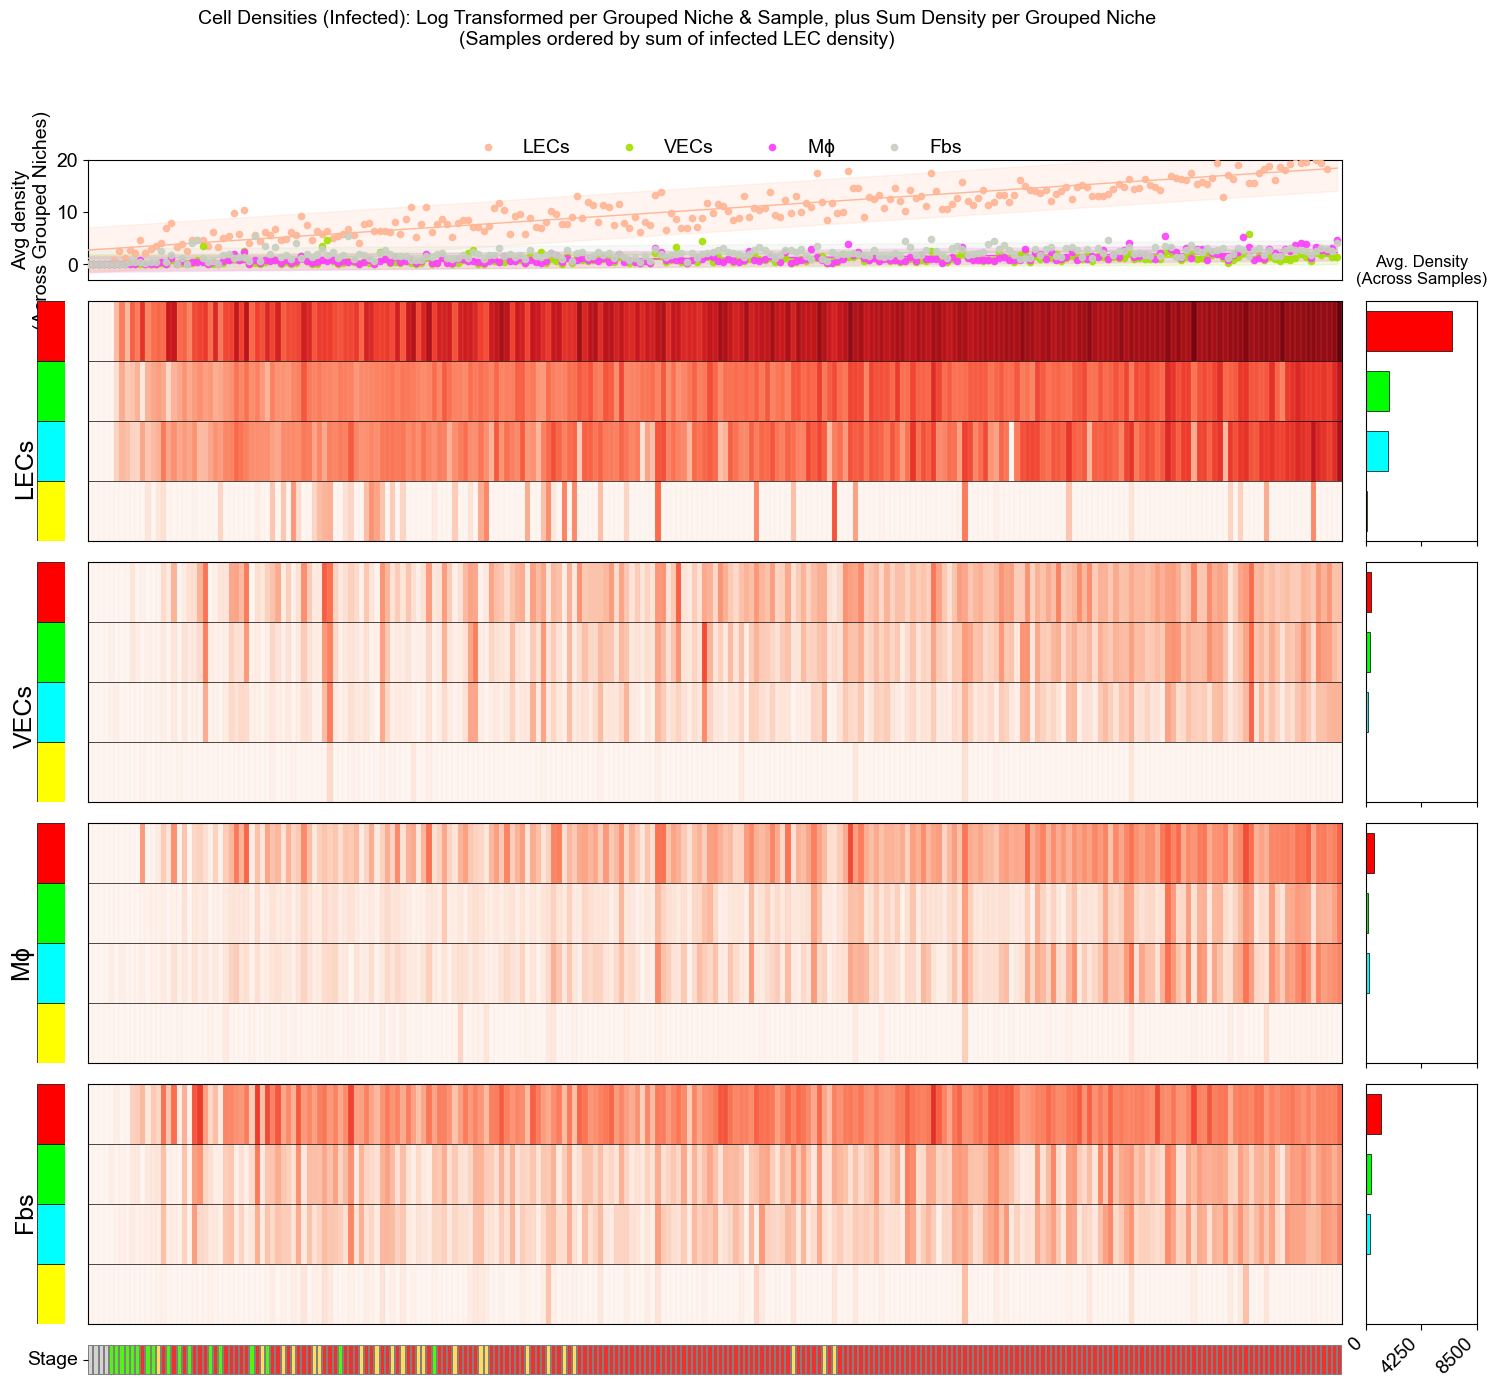

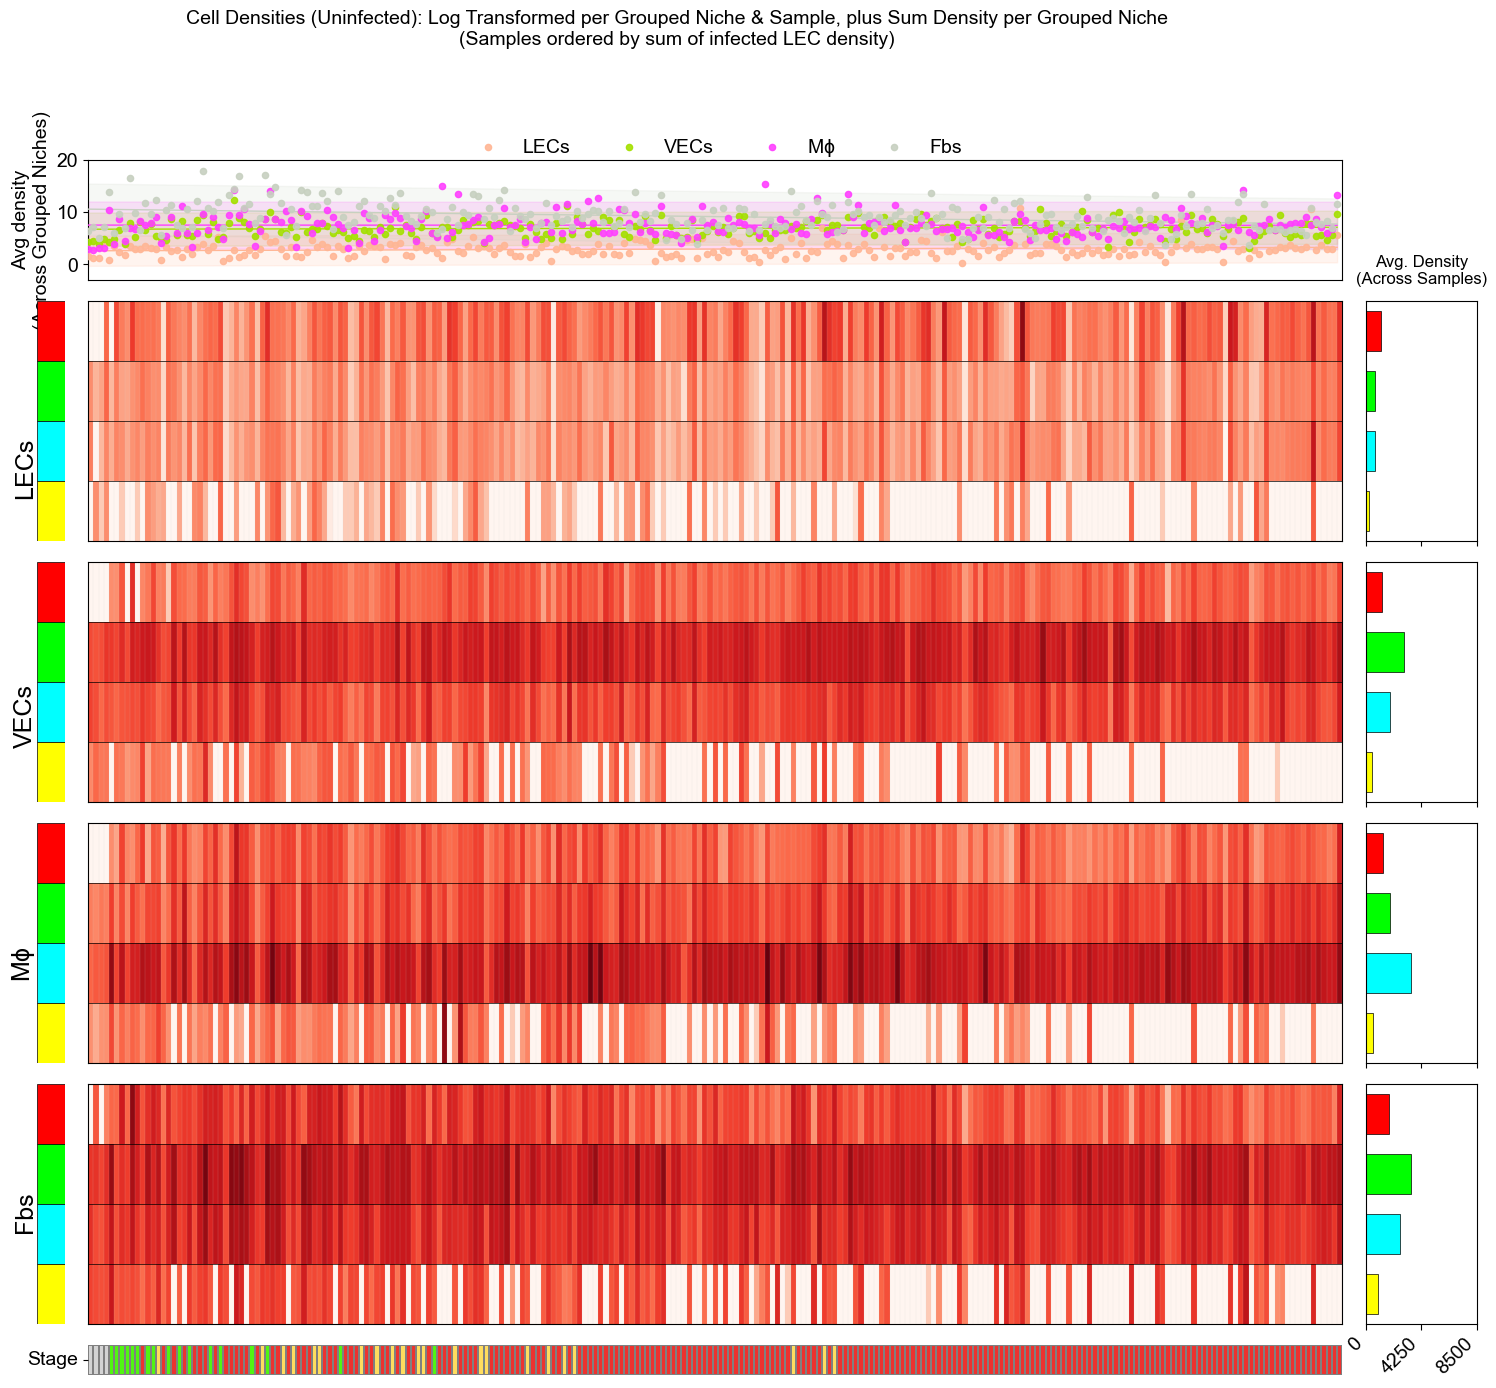

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import statsmodels.api as sm
from scipy import stats

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
# Ensures all text (including math text) uses Arial
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
# Embed fonts correctly in PDFs/PS
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
# Base font size
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS COMMON TO BOTH PLOTS (GROUPED NICHES)
# ───────────────────────────────────────────────────────────
# Define the vertical order of grouped niches
niche_order = [
    'tumor-associated',
    'vascular‐associated',         # ← Unicode hyphen (U+2010)
    'immune-enriched',
    'peripheral skin‐associated'   # ← Unicode hyphen (U+2010)
]

# Colors for each grouped niche stripe
niche_colors = {
    'tumor-associated':           '#ff0000',  # red
    'vascular‐associated':        '#00ff00',  # green
    'immune-enriched':            '#00ffff',  # cyan
    'peripheral skin‐associated': '#ffff00'   # yellow
}

# Abbreviations for the line‐plot legend
abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

# Heatmap colormap for densities
cmap = 'Reds'

# Colors for each cell type’s line in the top plot
cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

# Ensure the output directory exists
os.makedirs('figures/spacetime', exist_ok=True)

# Mapping from cell types → infected density columns in adata.obs
cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'density_infected_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'density_infected_Vascular_Endothelial_Cells',
    'Macrophages':                 'density_infected_Macrophages',
    'Fibroblasts':                 'density_infected_Fibroblasts',
}

# Automatically derive the “uninfected” mapping by replacing 'infected' → 'uninfected'
cell_types_and_cols_uninfected = {
    ct: col.replace('infected', 'uninfected')
    for ct, col in cell_types_and_cols_infected.items()
}


def plot_spacetime(cell_types_and_cols, label_suffix):
    """
    Generate “stripe + heatmaps + barplots + stage row” for infected or uninfected cells,
    grouping by the 'niches_grouped' column instead of the detailed niche column.
    - Top: line plot of average density per cell type (across grouped niches).
    - Middle: for each cell type, show a colored niche‐stripe (grouped), a heatmap of log densities,
      and a barplot of sum density per grouped niche.
    - Bottom: a single row colored by sample stage (nodular/plaque/patch/control).
    The first bar‐plot has a title “Avg. Density (Across Samples)”.
    """
    # ───────────────────────────────────────────────────────────
    # (2A) ORDER SAMPLES BY TOTAL LEC DENSITY (so all panels share this x‐order)
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    # Group by sample (“path_block_core”), sum LEC density, then sort ascending
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2B) BUILD RAW DENSITY MATRICES (Grouped Niche × Sample) FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, col in cell_types_and_cols.items():
        # Subset adata.obs rows for this cell type
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Fallback if exact match yields no rows
        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Compute mean density per (grouped niche, sample)
        df = obs_ct.groupby(
            ['niches_grouped', 'path_block_core']
        )[col].mean()

        # Pivot so rows = niche_order (grouped), cols = sample_order; fill missing with 0
        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(index=niche_order, columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (2C) LOG-TRANSFORM EACH MATRIX & COMPUTE GLOBAL vmin/Vmax FOR HEATMAPS
    # ───────────────────────────────────────────────────────────
    heatmaps_log = {ct: np.log1p(mat) for ct, mat in heatmaps.items()}
    all_vals = np.concatenate([hm.values.flatten() for hm in heatmaps_log.values()])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

    # ───────────────────────────────────────────────────────────
    # (2D) COMPUTE PER-SAMPLE AVERAGE DENSITY (FOR TOP LINE PLOT)
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)  # mean across grouped niches for each sample
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (2D.1) COMPUTE SUM DENSITY PER GROUPED NICHE (FOR BAR PLOTS)
    # ───────────────────────────────────────────────────────────
    cell_types_to_plot = list(cell_types_and_cols.keys())
    sum_densities = {
        ct: heatmaps[ct].sum(axis=1)   # sum across all samples for each grouped niche
        for ct in cell_types_to_plot
    }
    max_sum = max(series.max() for series in sum_densities.values())

    # ───────────────────────────────────────────────────────────
    # (2E) PREPARE FIGURE & GRIDSPEC
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)  # x positions for line plot
    n_celltypes = len(cell_types_to_plot)

    # Create a figure: width=20, height scaled by (#celltypes+1) rows
    fig = plt.figure(figsize=(20, 3 * (n_celltypes + 1)))

    # Define height ratios: top row=0.4, each celltype row=0.8, bottom stage row=0.3
    height_ratios = [0.4] + [0.8] * n_celltypes + [0.1]

    # Use GridSpec with (n_celltypes+2) rows:
    #   row 0 = line plot
    #   rows 1..n_celltypes = stripe+heatmap+bar
    #   row n_celltypes+1 = stage row
    gs = fig.add_gridspec(
        nrows = n_celltypes + 2,
        ncols = 3,
        width_ratios  = [0.02, 0.9, 0.08],  # narrow stripe, wide heatmap, narrow bar
        height_ratios = height_ratios,
        hspace = 0.11,
        wspace = 0.05
    )

    # ─── (2G) TOP ROW: BLANK + SCATTER + LINE + 95% PREDICTION INTERVAL BAND ─────────────────────────────
    ax_blank_top = fig.add_subplot(gs[0, 0])
    ax_blank_top.set_visible(False)  # hide the tiny stripe cell

    ax_top = fig.add_subplot(gs[0, 1])
    for ct in cell_types_to_plot:
        # X = sample‐index array, Y = avg density for this cell type
        Y = avg_densities[ct].values
        X = x  # already defined as np.arange(n_cols)

        # 1) Scatter the raw points
        ax_top.scatter(
            X,
            Y,
            label = abbrev_labels[ct],
            color = cell_types_color_dict.get(ct, 'black'),
            s = 20,
            alpha = 0.9,
            zorder = 4
        )

        # 2) Fit an OLS line (with intercept). Build design matrix:
        X_with_const = sm.add_constant(X)  # adds a column of 1′s
        ols_model = sm.OLS(Y, X_with_const).fit()

        # 3) Compute the fitted line (mean prediction) at each X:
        Y_pred = ols_model.predict(X_with_const)

        # 4) Compute the 95% PREDICTION‐INTERVAL band:
        n = len(X)
        df = n - 2
        t_val = stats.t.ppf(0.975, df)
        X_mean = X.mean()
        SSx = np.sum((X - X_mean) ** 2)
        sigma_hat = np.sqrt(ols_model.mse_resid)
        se_pred = sigma_hat * np.sqrt(
            1.0
            + 1.0 / n
            + ((X - X_mean) ** 2) / SSx
        )
        PI_upper = Y_pred + t_val * se_pred
        PI_lower = Y_pred - t_val * se_pred

        # 5) Plot the fitted line itself:
        ax_top.plot(
            X,
            Y_pred,
            color = cell_types_color_dict.get(ct, 'black'),
            linewidth = 1,
            zorder = 3
        )

        # 6) Fill between upper & lower to draw a 95% prediction band:
        ax_top.fill_between(
            X,
            PI_lower,
            PI_upper,
            color = cell_types_color_dict.get(ct, 'black'),
            alpha = 0.15,
            zorder = 2
        )

    # Show only three x‐ticks: 0, mid, max
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax_top.set_ylabel('Avg density\n(Across Grouped Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)

    ax_top.legend(
        ncol = len(cell_types_to_plot),
        bbox_to_anchor = (0.5, 1.34),  # move legend above the plot
        loc = 'upper center',
        fontsize = 14,
        frameon = False
    )

    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(-3, 20)


    # ─── (2H) MIDDLE ROWS: FOR EACH CELL TYPE → STRIPE | HEATMAP | BAR PLOT ────────────────────────
    heat_axes = []
    bar_axes = []

    for i, ct in enumerate(cell_types_to_plot):
        # (2H.1) NICHE‐COLOR STRIPE (leftmost narrow column)
        ax_color = fig.add_subplot(gs[i + 1, 0])
        n_rows_stripe = len(niche_order)

        ax_color.set_xlim(0, 1)
        ax_color.set_ylim(n_rows_stripe, 0)
        ax_color.margins(0)
        ax_color.set_xticks([])
        ax_color.set_yticks([])
        ax_color.set_frame_on(False)

        # Draw one Rectangle per grouped niche
        for row_idx, niche_name in enumerate(niche_order):
            rect = Rectangle(
                (0, row_idx), 1, 1,
                facecolor = niche_colors[niche_name],
                edgecolor = 'black',
                linewidth = 0.5,
                zorder = 2
            )
            ax_color.add_patch(rect)

        # (2H.2) HEATMAP (middle wide column)
        if i == 0:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=ax_top)
        else:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=heat_axes[0])
        heat_axes.append(ax_heat)

        density_ct_log = heatmaps_log[ct]
        n_rows, n_cols_heat = density_ct_log.shape

        sns.heatmap(
            density_ct_log,
            ax = ax_heat,
            cmap = cmap,
            vmin = vmin,
            vmax = vmax,
            cbar = False,
            linewidths = 0,
            linecolor = '#d3d3d3',
            xticklabels = False,
            yticklabels = False,
            square = False
        )

        # Remove x‐axis labels/ticks on intermediate heatmaps
        ax_heat.set_xlabel('')
        ax_heat.xaxis.label.set_visible(False)
        ax_heat.set_xticklabels([])

        # Draw thin grey vertical grid lines between columns
        for x_line in range(n_cols_heat + 1):
            ax_heat.vlines(
                x_line, 0, n_rows,
                colors = '#d3d3d3',
                linewidth = 0.1,
                zorder = 1
            )
        # Draw black horizontal lines between grouped niches
        for y_line in range(n_rows + 1):
            ax_heat.hlines(
                y_line, 0, n_cols_heat,
                colors = 'black',
                linewidth = 0.5,
                zorder = 2
            )
        # Turn on spines around heatmap
        for side in ['top', 'bottom', 'left', 'right']:
            ax_heat.spines[side].set_visible(True)
            ax_heat.spines[side].set_linewidth(0.8)
            ax_heat.spines[side].set_edgecolor('black')

        ax_heat.set_ylabel('')
        ax_heat.tick_params(axis='y', length=0)

        # (2H.3) BAR PLOT (rightmost narrow column)
        if i == 0:
            ax_bar = fig.add_subplot(gs[i + 1, 2])
            # Add title above the first bar‐plot
            ax_bar.set_title("Avg. Density\n(Across Samples)", fontsize=12, pad=12)
        else:
            ax_bar = fig.add_subplot(gs[i + 1, 2], sharex=bar_axes[0])
        bar_axes.append(ax_bar)

        # Compute sum density per grouped niche in the correct niche_order
        sums = sum_densities[ct].reindex(niche_order)

        # Space out bars by a factor of 1.2 but keep bar thickness default
        spacing = 1.2
        y_positions = np.arange(len(niche_order)) * spacing

        ax_bar.barh(
            y_positions,
            sums.values,
            color=[niche_colors[n] for n in niche_order],
            edgecolor='black',
            linewidth=0.5
        )

        # Fix x‐axis limit to [0, 8500] for all bar plots
        ax_bar.set_xlim(0, 8500)
        # Set y‐limits so bars are centered with half‐spacing margins
        ax_bar.set_ylim(
            spacing * len(niche_order) - spacing / 2,
            -spacing / 2
        )
        ax_bar.set_yticks([])

        # Show x‐tick labels only on the bottommost bar plot
        if i == n_celltypes - 1:
            ax_bar.set_xticks([0, 4250, 8500])
            ax_bar.set_xticklabels(
                [0, 4250, 8500],
                fontsize=14,
                rotation=45,
                ha='right'
            )
            ax_bar.xaxis.set_tick_params(length=4)
        else:
            ax_bar.xaxis.set_tick_params(labelbottom=False)

        # Turn on spines around bar plot
        for side in ['top', 'bottom', 'left', 'right']:
            ax_bar.spines[side].set_visible(True)
            ax_bar.spines[side].set_linewidth(0.8)
            ax_bar.spines[side].set_edgecolor('black')

    # ─── (2I) ADD ROTATED CELL‐TYPE LABELS ON LEFT SIDE ─────────────────────
    for ax, ct in zip(heat_axes, cell_types_to_plot):
        pos = ax.get_position()
        y_center = pos.y0 + pos.height / 2
        # Draw the abbreviation at left, centered vertically
        fig.text(
            0.18,
            y_center,
            abbrev_labels[ct],
            rotation=90,
            ha='right',
            va='center',
            fontsize=18
        )

    # ─── (2J) BOTTOM ROW: STAGE HEATMAP ─────────────────────────────────
    # 1) Define colors for each stage
    stage_colors = {
        'nodular': '#ed322f',  # Light Red
        'plaque':  '#ffdc5e',  # Light Yellow
        'patch':   '#51f512',  # Light Green
        'control': '#D3D3D3'   # Light Gray
    }
    # 2) Determine each sample’s stage (mode of 'Stage' per 'path_block_core')
    sample_stage = (
        adata.obs
        .groupby('path_block_core')['Stage']
        .agg(lambda x: x.mode().iloc[0])  # use the most frequent stage
        .astype(str)
        .reindex(sample_order)
    )
    # 3) Map each sample to its color
    stage_colors_list = sample_stage.map(stage_colors).fillna('#FFFFFF').values

    # Create the bottom‐row axes: one for stripe (blank), one for stage heatmap, one blank for bar column
    ax_stage_stripe = fig.add_subplot(gs[n_celltypes + 1, 0])
    ax_stage_stripe.set_visible(False)

    ax_stage = fig.add_subplot(gs[n_celltypes + 1, 1])
    # Convert stages to categorical codes & build a DataFrame with a single row
    stages_cat = sample_stage.astype('category')
    codes = stages_cat.cat.codes.values[np.newaxis, :]
    lut = [stage_colors[s] for s in stages_cat.cat.categories]
    cmap_stage = mcolors.ListedColormap(lut)
    df_stage = pd.DataFrame(codes, index=['Stage'], columns=sample_order)

    # Plot a 1×N “heatmap” of stages (no colorbar)
    sns.heatmap(
        df_stage,
        ax=ax_stage,
        cmap=cmap_stage,
        cbar=False,
        xticklabels=False,
        yticklabels=['Stage'],
        linewidths=0.1,
        linecolor='gray'
    )
    ax_stage.tick_params(axis='y', labelsize=14, rotation=0)
    # Hide spines around the stage row
    for spine in ax_stage.spines.values():
        spine.set_visible(False)

    ax_stage_bar = fig.add_subplot(gs[n_celltypes + 1, 2])
    ax_stage_bar.set_visible(False)

    # ─── (2K) FINAL FIGURE LAYOUT & SAVE ────────────────────────────────
    plt.xlabel('')
    plt.suptitle(
        f'Cell Densities ({label_suffix.capitalize()}): '
        'Log Transformed per Grouped Niche & Sample, plus Sum Density per Grouped Niche\n'
        '(Samples ordered by sum of infected LEC density)',
        fontsize=14,
        y=1.02
    )
    plt.tight_layout()
    plt.subplots_adjust(left=0.18, top=0.92)

    # Save with a new filename indicating grouped niches
    outfile = f"figures/spacetime/log_density_{label_suffix}_cell_density_grouped.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# ───────────────────────────────────────────────────────────
# (3) RUN PLOTTING FOR BOTH INFECTED AND UNINFECTED (GROUPED NICHES)
# ───────────────────────────────────────────────────────────
plot_spacetime(cell_types_and_cols_infected, label_suffix='infected')
plot_spacetime(cell_types_and_cols_uninfected, label_suffix='uninfected')


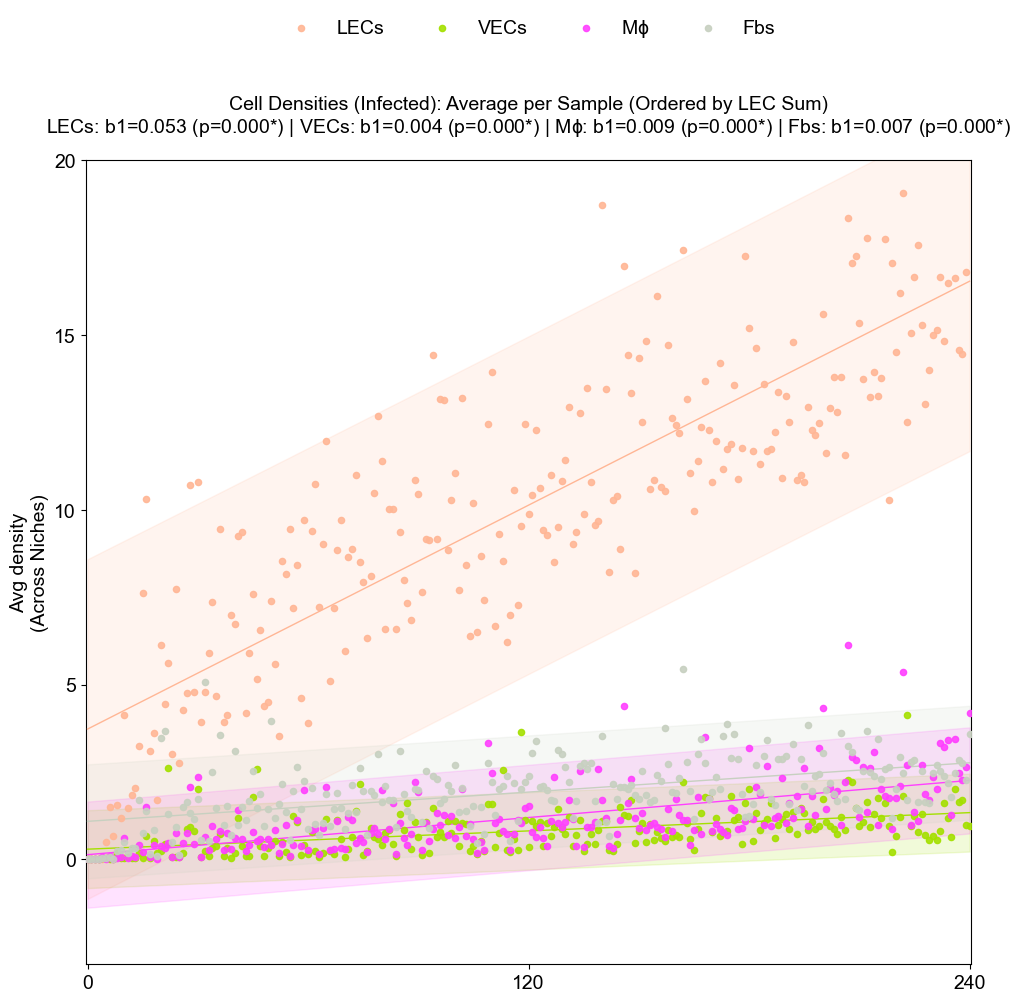

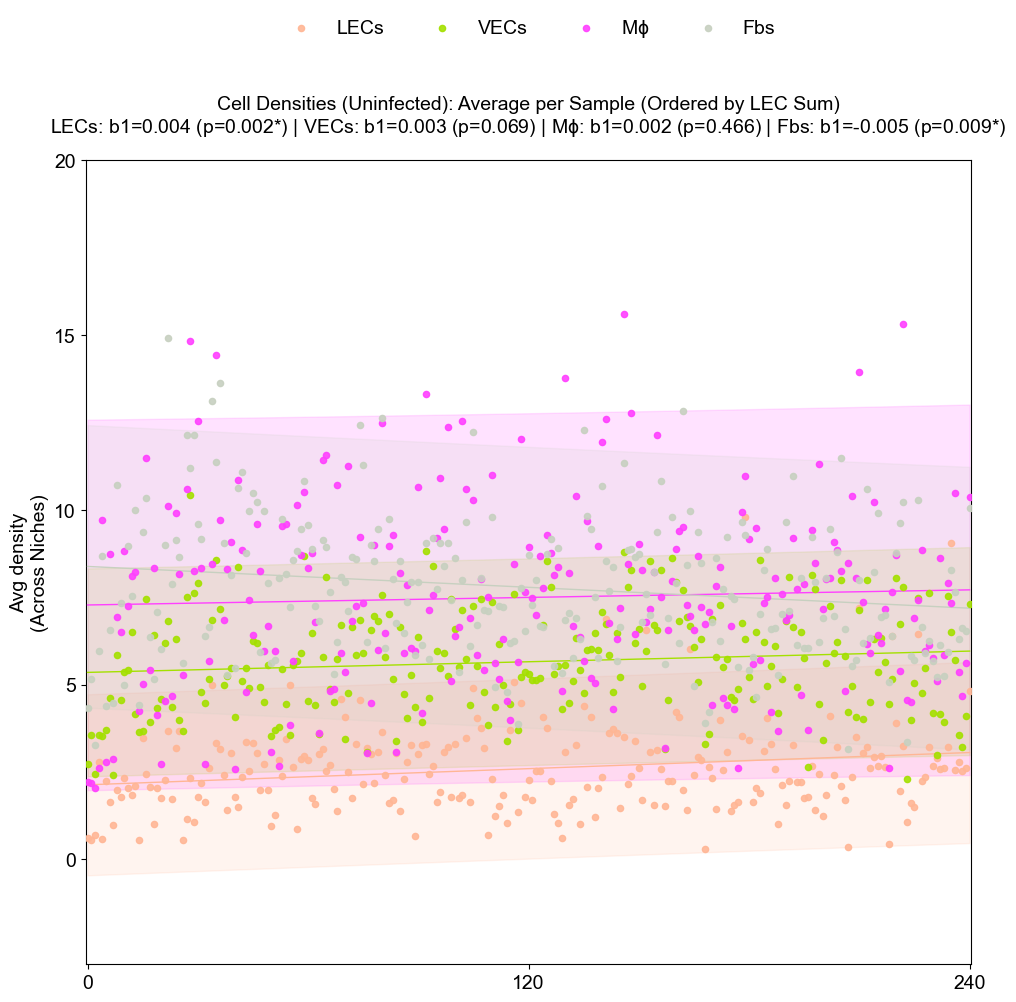

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS FOR TOP PLOT ONLY
# ───────────────────────────────────────────────────────────
abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

os.makedirs('figures/spacetime', exist_ok=True)

cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'density_infected_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'density_infected_Vascular_Endothelial_Cells',
    'Macrophages':                 'density_infected_Macrophages',
    'Fibroblasts':                 'density_infected_Fibroblasts',
}

cell_types_and_cols_uninfected = {
    ct: col.replace('infected', 'uninfected')
    for ct, col in cell_types_and_cols_infected.items()
}


def plot_top_only(cell_types_and_cols, label_suffix):
    """
    Generate only the top: scatter + OLS-fit lines + 95% PI bands for each cell type.
    Samples are ordered by total LEC density.
    Also extracts slope (b1) and p-value and appends them (with '*' if p<0.05) in the title.
    """
    # ───────────────────────────────────────────────────────────
    # (1) ORDER SAMPLES BY TOTAL LEC DENSITY
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2) BUILD HEATMAP MATRIX JUST TO COMPUTE avg_densities
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, col in cell_types_and_cols.items():
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        df = obs_ct.groupby(['niche_with_tumor_proximity', 'path_block_core'])[col].mean()
        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (3) COMPUTE PER-SAMPLE AVERAGE DENSITY FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (4) PREPARE FIGURE FOR TOP PLOT
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)
    cell_types_to_plot = list(cell_types_and_cols.keys())

    # Store slope (b1) and p-value for each cell type
    trend_stats = {}

    fig, ax_top = plt.subplots(figsize=(10, 10))

    for ct in cell_types_to_plot:
        Y = avg_densities[ct].values
        X = x

        # 1) Scatter the raw points
        ax_top.scatter(
            X,
            Y,
            label=abbrev_labels[ct],
            color=cell_types_color_dict.get(ct, 'black'),
            s=20,
            alpha=0.9,
            zorder=4
        )

        # 2) Fit an OLS line (with intercept)
        X_with_const = sm.add_constant(X)
        ols_model = sm.OLS(Y, X_with_const).fit()

        # Extract slope (b1) and its p-value
        b1 = ols_model.params[1]
        pval = ols_model.pvalues[1]
        trend_stats[ct] = (b1, pval)

        # 3) Compute the fitted line
        Y_pred = ols_model.predict(X_with_const)

        # 4) Compute the 95% prediction‐interval band
        n = len(X)
        df = n - 2
        t_val = stats.t.ppf(0.975, df)
        X_mean = X.mean()
        SSx = np.sum((X - X_mean) ** 2)
        sigma_hat = np.sqrt(ols_model.mse_resid)
        se_pred = sigma_hat * np.sqrt(
            1.0 + 1.0 / n + ((X - X_mean) ** 2) / SSx
        )
        PI_upper = Y_pred + t_val * se_pred
        PI_lower = Y_pred - t_val * se_pred

        # 5) Plot the fitted line
        ax_top.plot(
            X,
            Y_pred,
            color=cell_types_color_dict.get(ct, 'black'),
            linewidth=1,
            zorder=3
        )

        # 6) Fill between to draw the 95% PI band
        ax_top.fill_between(
            X,
            PI_lower,
            PI_upper,
            color=cell_types_color_dict.get(ct, 'black'),
            alpha=0.15,
            zorder=2
        )

    # ───────────────────────────────────────────────────────────
    # (5) CUSTOMIZE AXIS TICKS, LABEL, LEGEND
    # ───────────────────────────────────────────────────────────
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax_top.set_ylabel('Avg density\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)

    ax_top.legend(
        ncol=len(cell_types_to_plot),
        bbox_to_anchor=(0.5, 1.2),
        loc='upper center',
        fontsize=14,
        frameon=False
    )

    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(-3, 20)

    # ───────────────────────────────────────────────────────────
    # (6) BUILD MULTILINE TITLE INCLUDING b1 AND p-VALUES
    # ───────────────────────────────────────────────────────────
    title_main = (
        f'Cell Densities ({label_suffix.capitalize()}): '
        'Average per Sample (Ordered by LEC Sum)'
    )

    parts = []
    for ct in cell_types_to_plot:
        abbrev = abbrev_labels[ct]
        b1, pval = trend_stats[ct]
        star = '*' if pval < 0.05 else ''
        parts.append(f'{abbrev}: b1={b1:.3f} (p={pval:.3f}{star})')

    title_trends = ' | '.join(parts)
    ax_top.set_title(f'{title_main}\n{title_trends}', fontsize=14, pad=20)

    plt.tight_layout()

    # ───────────────────────────────────────────────────────────
    # (7) SAVE AND SHOW
    # ───────────────────────────────────────────────────────────
    outfile = f"figures/spacetime/top_only_{label_suffix}_cell_density.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# ───────────────────────────────────────────────────────────
# (8) RUN TOP‐ONLY PLOT FOR BOTH INFECTED AND UNINFECTED
# ───────────────────────────────────────────────────────────
plot_top_only(cell_types_and_cols_infected, label_suffix='infected')
plot_top_only(cell_types_and_cols_uninfected, label_suffix='uninfected')


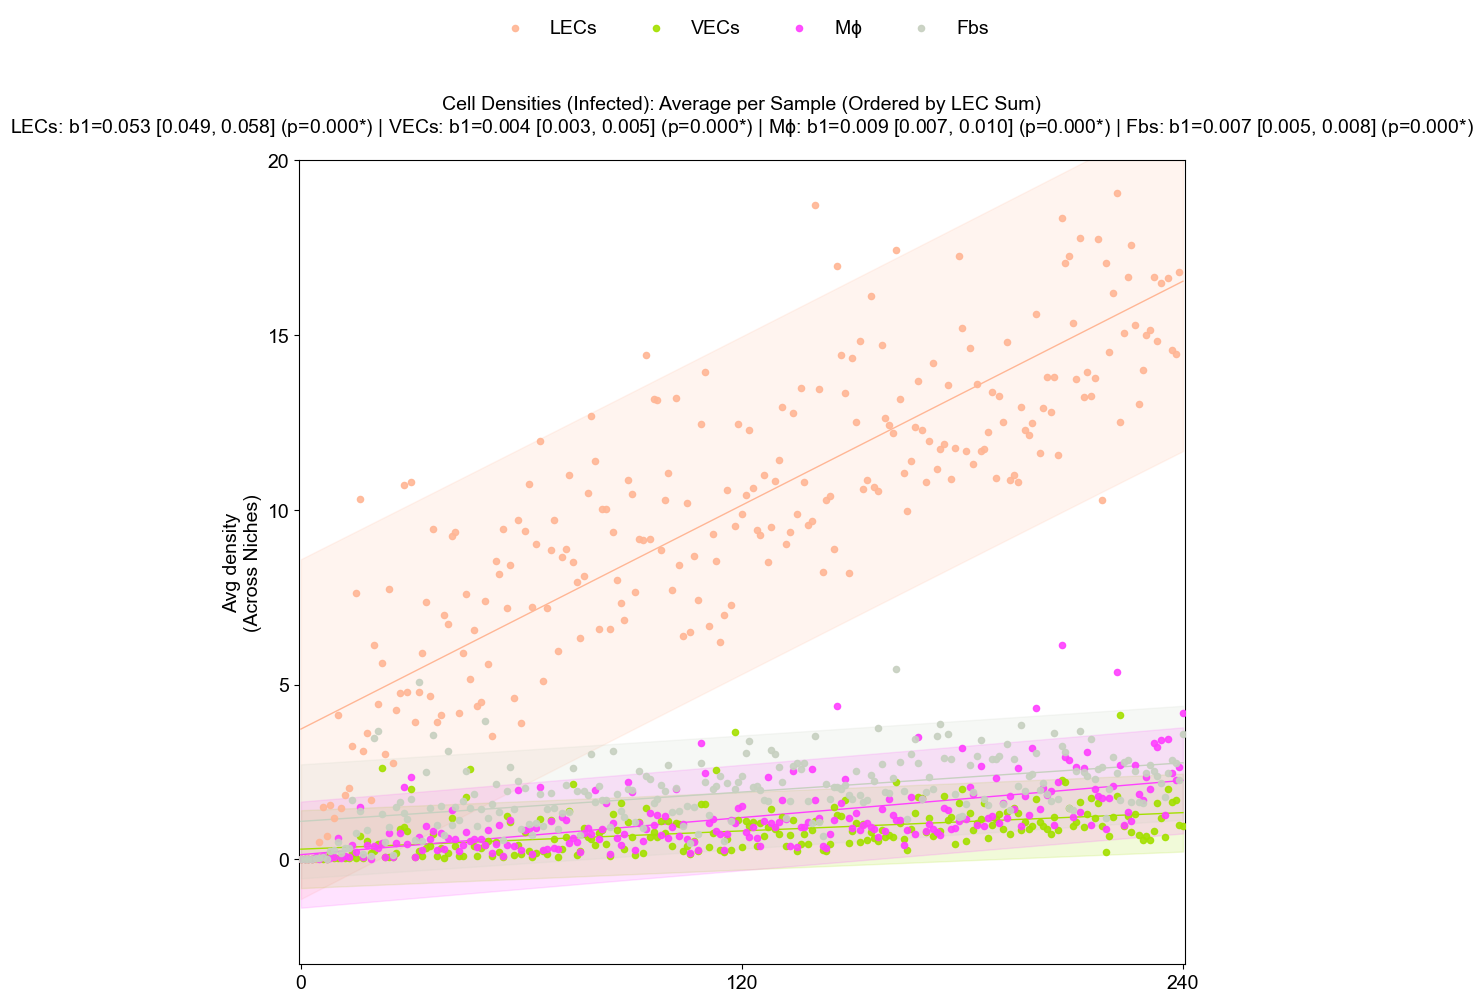

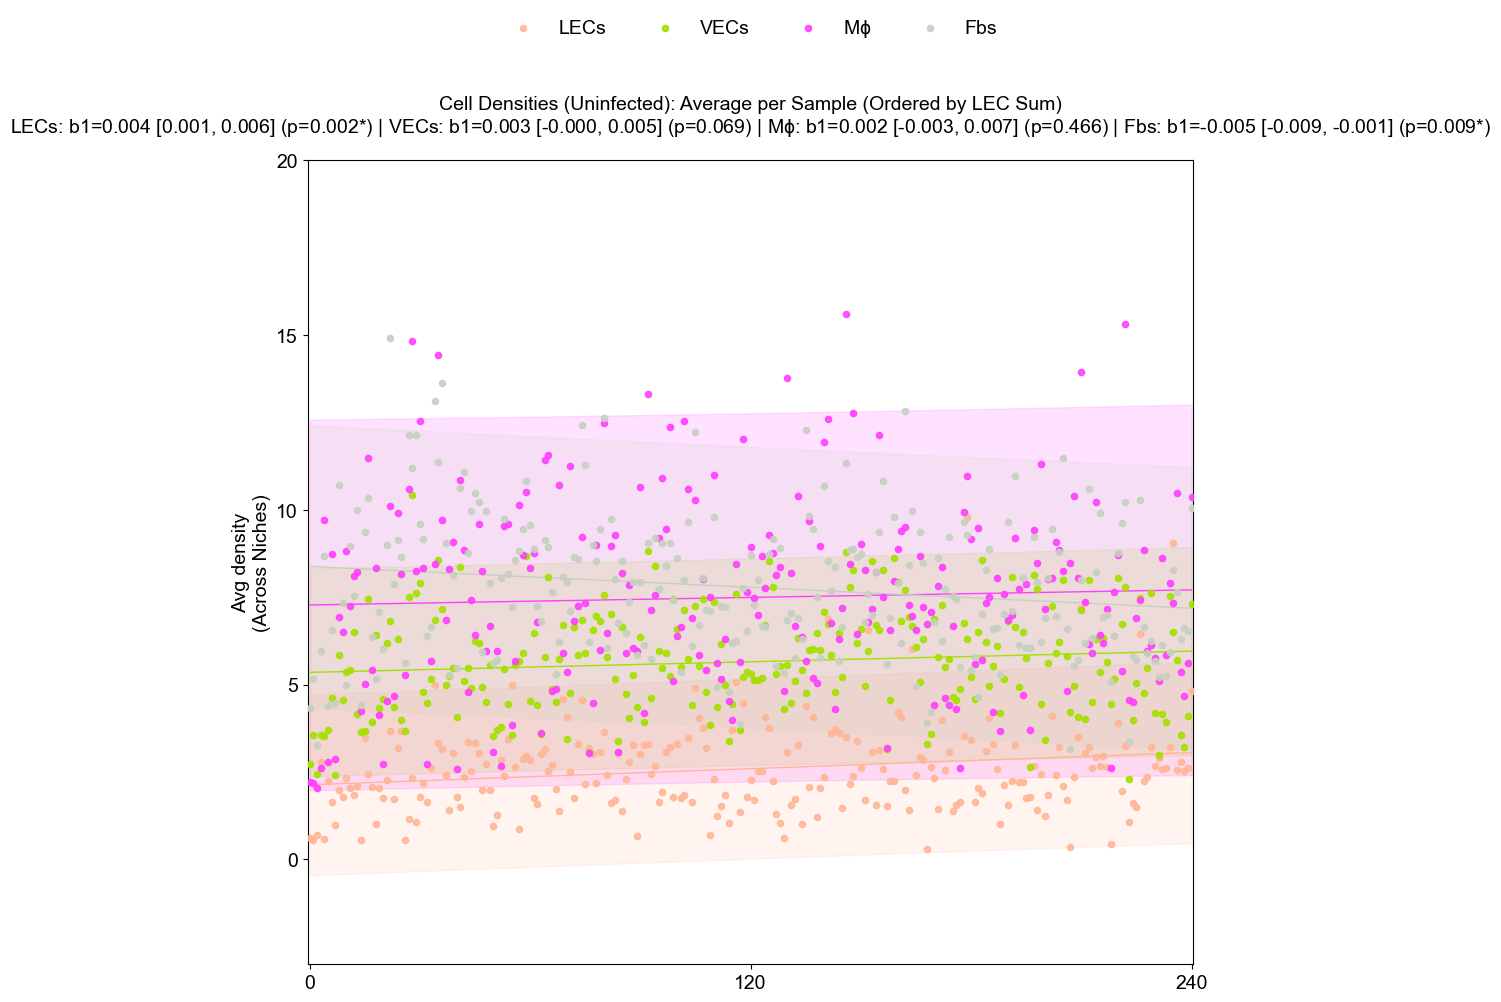

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS FOR TOP PLOT ONLY
# ───────────────────────────────────────────────────────────
abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

# Ensure the output directory exists
os.makedirs('figures/spacetime', exist_ok=True)

cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'density_infected_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'density_infected_Vascular_Endothelial_Cells',
    'Macrophages':                 'density_infected_Macrophages',
    'Fibroblasts':                 'density_infected_Fibroblasts',
}

cell_types_and_cols_uninfected = {
    ct: col.replace('infected', 'uninfected')
    for ct, col in cell_types_and_cols_infected.items()
}


def plot_top_only(cell_types_and_cols, label_suffix):
    """
    Generate only the top: scatter + OLS-fit lines + 95% PI bands for each cell type.
    Samples are ordered by total LEC density.
    Also computes 95% CI for each slope (b1) and appends (b1, CI, p-value) in the title.
    """
    # ───────────────────────────────────────────────────────────
    # (1) ORDER SAMPLES BY TOTAL LEC DENSITY
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2) BUILD HEATMAP MATRIX JUST TO COMPUTE avg_densities
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, col in cell_types_and_cols.items():
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        df = obs_ct.groupby(['niche_with_tumor_proximity', 'path_block_core'])[col].mean()
        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (3) COMPUTE PER-SAMPLE AVERAGE DENSITY FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)  # mean across all niches for each sample
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (4) PREPARE FIGURE FOR TOP PLOT
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)
    cell_types_to_plot = list(cell_types_and_cols.keys())

    # Store slope (b1), p-value, and CI for each cell type
    trend_stats = {}

    fig, ax_top = plt.subplots(figsize=(10, 10))

    for ct in cell_types_to_plot:
        Y = avg_densities[ct].values
        X = x

        # 1) Scatter the raw points
        ax_top.scatter(
            X,
            Y,
            label=abbrev_labels[ct],
            color=cell_types_color_dict.get(ct, 'black'),
            s=20,
            alpha=0.9,
            zorder=4
        )

        # 2) Fit an OLS line (with intercept)
        X_with_const = sm.add_constant(X)
        ols_model = sm.OLS(Y, X_with_const).fit()

        # Extract slope (b1) and its p-value
        b1 = ols_model.params[1]
        pval = ols_model.pvalues[1]

        # Compute SE(b1) from covariance matrix (as a NumPy array)
        cov_matrix = ols_model.cov_params()
        se_b1 = np.sqrt(cov_matrix[1, 1])  # <— index directly, not .iloc

        # 95% critical t-value for df = n - 2
        df_resid = len(X) - 2
        t_crit = stats.t.ppf(0.975, df_resid)

        # 95% CI for b1
        ci_lower = b1 - t_crit * se_b1
        ci_upper = b1 + t_crit * se_b1

        trend_stats[ct] = (b1, pval, ci_lower, ci_upper)

        # 3) Compute the fitted line
        Y_pred = ols_model.predict(X_with_const)

        # 4) Compute the 95% prediction‐interval band (for Y)
        n = len(X)
        X_mean = X.mean()
        SSx = np.sum((X - X_mean) ** 2)
        sigma_hat = np.sqrt(ols_model.mse_resid)
        se_pred = sigma_hat * np.sqrt(
            1.0 + 1.0 / n + ((X - X_mean) ** 2) / SSx
        )
        PI_upper = Y_pred + t_crit * se_pred
        PI_lower = Y_pred - t_crit * se_pred

        # 5) Plot the fitted line
        ax_top.plot(
            X,
            Y_pred,
            color=cell_types_color_dict.get(ct, 'black'),
            linewidth=1,
            zorder=3
        )

        # 6) Fill between to draw the 95% PI band
        ax_top.fill_between(
            X,
            PI_lower,
            PI_upper,
            color=cell_types_color_dict.get(ct, 'black'),
            alpha=0.15,
            zorder=2
        )

    # ───────────────────────────────────────────────────────────
    # (5) CUSTOMIZE AXIS TICKS, LABEL, LEGEND
    # ───────────────────────────────────────────────────────────
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax_top.set_ylabel('Avg density\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)

    ax_top.legend(
        ncol=len(cell_types_to_plot),
        bbox_to_anchor=(0.5, 1.2),
        loc='upper center',
        fontsize=14,
        frameon=False
    )

    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(-3, 20)

    # ───────────────────────────────────────────────────────────
    # (6) BUILD MULTILINE TITLE INCLUDING b1, 95% CI, AND p-VALUES
    # ───────────────────────────────────────────────────────────
    title_main = (
        f'Cell Densities ({label_suffix.capitalize()}): '
        'Average per Sample (Ordered by LEC Sum)'
    )

    parts = []
    for ct in cell_types_to_plot:
        abbrev = abbrev_labels[ct]
        b1, pval, ci_low, ci_high = trend_stats[ct]
        star = '*' if pval < 0.05 else ''
        parts.append(
            f'{abbrev}: b1={b1:.3f} '
            f'[{ci_low:.3f}, {ci_high:.3f}] '
            f'(p={pval:.3f}{star})'
        )

    title_trends = ' | '.join(parts)
    ax_top.set_title(f'{title_main}\n{title_trends}', fontsize=14, pad=20)

    plt.tight_layout()

    # ───────────────────────────────────────────────────────────
    # (7) SAVE AND SHOW
    # ───────────────────────────────────────────────────────────
    outfile = f"figures/spacetime/top_only_{label_suffix}_cell_density.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# ───────────────────────────────────────────────────────────
# (8) RUN TOP‐ONLY PLOT FOR BOTH INFECTED AND UNINFECTED
# ───────────────────────────────────────────────────────────
plot_top_only(cell_types_and_cols_infected, label_suffix='infected')
plot_top_only(cell_types_and_cols_uninfected, label_suffix='uninfected')


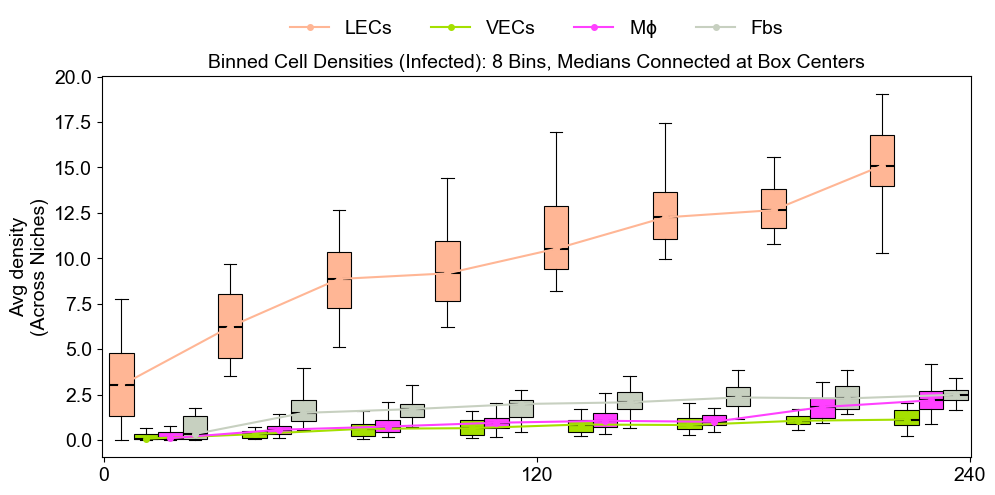

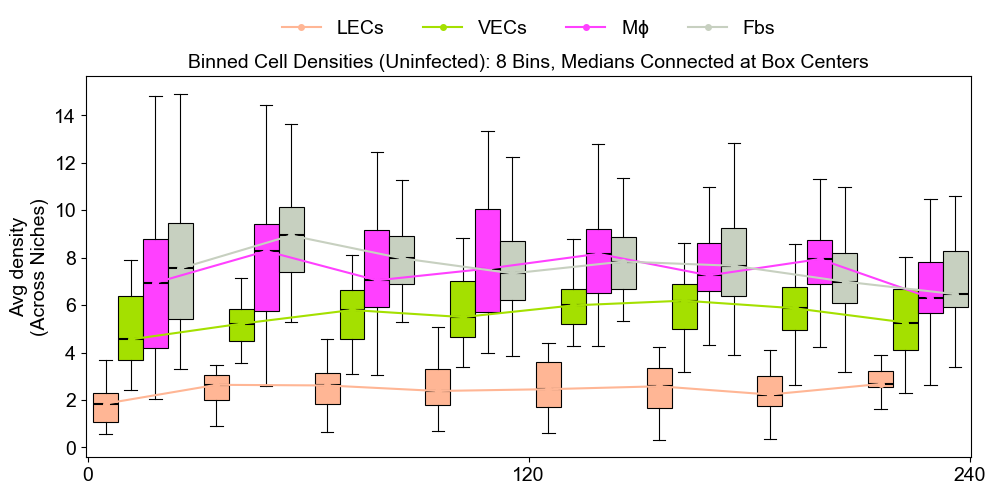

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_top_binned(cell_types_and_cols, label_suffix, n_bins=8, fig_size=(20, 3)):
    """
    Generate a “binned” top plot: for each cell type, bin samples along the x-axis,
    draw a boxplot of avg_density within each bin (one box per bin + cell type),
    and connect the bin medians with a line that starts at the box's median line.
    Samples are ordered by total LEC density, as before.

    Args:
        cell_types_and_cols (dict): mapping from cell‐type name → column in adata.obs
        label_suffix (str): "infected" or "uninfected", used in title and output filename
        n_bins (int): number of equal‐width bins to use along the x‐axis
        fig_size (tuple): matplotlib figsize, e.g. (20, 3)
    """
    # ───────────────────────────────────────────────────────────
    # (1) ORDER SAMPLES BY TOTAL LEC DENSITY
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2) BUILD SIMPLE “HEATMAP” MATRICES JUST TO GET avg_densities
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, col in cell_types_and_cols.items():
        # Subset adata.obs rows for this cell type
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]
        if obs_ct is None or obs_ct.empty:
            # Fallback if no exact match
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Compute mean density per (niche, sample)
        df = obs_ct.groupby(
            ['niche_with_tumor_proximity', 'path_block_core']
        )[col].mean()

        # Pivot so columns = sample_order; fill missing with 0
        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (3) COMPUTE PER‐SAMPLE AVERAGE DENSITY FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)  # mean across all niches for each sample
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (4) DEFINE BIN EDGES / CENTERS AND BOX POSITIONS
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)  # sample‐index from 0..n_cols-1

    # Create n_bins equally spaced edges from 0 to n_cols
    bin_edges = np.linspace(0, n_cols, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    cell_types_to_plot = list(cell_types_and_cols.keys())
    n_ct = len(cell_types_to_plot)

    # We want each cell‐type’s boxplot to be slightly shifted within each bin.
    # Reserve 90% of the bin width for the boxes, the rest is margin.
    total_width = bin_width * 0.9
    box_width = total_width / n_ct
    offsets = np.linspace(
        - (total_width / 2) + (box_width / 2),
        ( total_width / 2) - (box_width / 2),
        n_ct
    )
    # So if you have 4 cell types and bin_width=30, then total_width=27,
    # and each box_width=27/4=6.75, with offsets spaced so the 4 boxes fit in the bin.

    # ───────────────────────────────────────────────────────────
    # (5) PLOT: BOXPLOTS + CONNECT MEDIANS AT BOX‐CENTERS
    # ───────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=fig_size)

    for j, ct in enumerate(cell_types_to_plot):
        Y = avg_densities[ct].values  # length = n_cols

        # Assign each X‐position (0..n_cols-1) to a bin‐index (0..n_bins-1)
        # `np.digitize(..., bin_edges[1:-1])` returns 0..n_bins-1
        bin_indices = np.digitize(x, bin_edges[1:-1], right=False)
        # Now collect Y‐values per bin:
        data_per_bin = [Y[bin_indices == i] for i in range(n_bins)]

        # The x‐coordinate for the j-th cell‐type’s box in bin i is:
        #    positions[i] = bin_centers[i] + offsets[j]
        positions = bin_centers + offsets[j]

        # Draw one boxplot per bin for this cell type
        _ = ax.boxplot(
            data_per_bin,
            positions = positions,
            widths    = box_width,
            patch_artist = True,
            showfliers  = False,
            boxprops = {
                'facecolor': cell_types_color_dict.get(ct, 'gray'),
                'edgecolor': 'black',
                'linewidth': 0.8
            },
            medianprops = {
                'color': 'black',
                'linewidth': 1.5
            },
            whiskerprops = {
                'color': 'black',
                'linewidth': 0.8
            },
            capprops = {
                'color': 'black',
                'linewidth': 0.8
            }
        )

        # Compute medians for each bin (NaN if bin is empty)
        medians = np.array([
            np.median(vals) if len(vals) > 0 else np.nan
            for vals in data_per_bin
        ])
        # Connect only the non‐NaN medians with a line at the same x = positions
        ax.plot(
            positions,
            medians,
            color  = cell_types_color_dict.get(ct, 'black'),
            linewidth=1.5,
            marker  = 'o',
            markersize=4,
            zorder  = 4,
            label   = abbrev_labels[ct]
        )

    # ───────────────────────────────────────────────────────────
    # (6) FORMAT AXES, LEGEND, TITLES, AND SAVE
    # ───────────────────────────────────────────────────────────
    # Show only three x‐ticks: 0, mid, max
    mid_x = (n_cols - 1) // 2
    ax.set_xticks([0, mid_x, n_cols - 1])
    ax.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax.set_ylabel('Avg density\n(Across Niches)', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(-0.5, n_cols - 0.5)

    ax.legend(
        ncol   = n_ct,
        bbox_to_anchor = (0.5, 1.2),
        loc    = 'upper center',
        fontsize = 14,
        frameon  = False
    )

    ax.set_title(
        f'Binned Cell Densities ({label_suffix.capitalize()}): '
        f'{n_bins} Bins, Medians Connected at Box Centers',
        fontsize = 14
    )
    plt.tight_layout()

    # Make sure the output directory exists
    os.makedirs('figures/spacetime', exist_ok=True)
    outfile = f"figures/spacetime/top_binned_{label_suffix}_cell_density.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# After setting up `adata`, imports, etc., call with a custom figure size:
plot_top_binned(cell_types_and_cols_infected,   label_suffix='infected',   n_bins=8, fig_size=(10, 5))
plot_top_binned(cell_types_and_cols_uninfected, label_suffix='uninfected', n_bins=8, fig_size=(10, 5))



# Fit line

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from scipy.interpolate import UnivariateSpline  # ← already imported

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS COMMON TO BOTH PLOTS
# ───────────────────────────────────────────────────────────
niche_order = [
    'Tumor Core', 'Tumor', 'Tumor Boundary', 'TA VEC Stroma',
    'Macrophage Immune Stroma', 'T-cell Immune Stroma', 'Stroma',
    'Immune', 'VEC Stroma', 'Basal Dermis', 'Differentiated Epidermis'
]

abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

niche_colors = {
    "Basal Dermis":               "#b299e3",
    "Differentiated Epidermis":   "#ffd000",
    "Stroma":                     "#646500",
    "TA VEC Stroma":              "#00e50c",
    "VEC Stroma":                 "#cccc33",
    "Macrophage Immune Stroma":   "#00dbf4",
    "T-cell Immune Stroma":       "#0051f9",
    "Immune":                     "#c100f9",
    "Tumor Core":                 "#450000",
    "Tumor":                      "#eb0000",
    "Tumor Boundary":             "#faa0aa"
}

cmap = 'Reds'

cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

os.makedirs('figures/spacetime', exist_ok=True)

cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'density_infected_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'density_infected_Vascular_Endothelial_Cells',
    'Macrophages':                 'density_infected_Macrophages',
    'Fibroblasts':                 'density_infected_Fibroblasts',
}

cell_types_and_cols_uninfected = {
    ct: col.replace('infected', 'uninfected')
    for ct, col in cell_types_and_cols_infected.items()
}


def plot_spacetime(cell_types_and_cols, label_suffix, fit='linear', spline_s=0.5):
    """
    Generate “stripe + heatmaps + barplots + stage row” for infected or uninfected cells.
    Added parameters:
      - fit: 'linear'  → fit a straight line (polyfit)
             'spline'  → fit a UnivariateSpline
             any other → no fit (just dotted lines)
      - spline_s: smoothing factor to pass to UnivariateSpline when fit='spline'
    """

    # ───────────────────────────────────────────────────────────
    # (2A) ORDER SAMPLES BY TOTAL LEC DENSITY
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2B) BUILD RAW DENSITY MATRICES (Niche × Sample) FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, col in cell_types_and_cols.items():
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        df = obs_ct.groupby(
            ['niche_with_tumor_proximity', 'path_block_core']
        )[col].mean()

        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(index=niche_order, columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (2C) LOG-TRANSFORM & COMPUTE vmin/Vmax
    # ───────────────────────────────────────────────────────────
    heatmaps_log = {ct: np.log1p(mat) for ct, mat in heatmaps.items()}
    all_vals = np.concatenate([hm.values.flatten() for hm in heatmaps_log.values()])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

    # ───────────────────────────────────────────────────────────
    # (2D) COMPUTE PER-SAMPLE AVERAGE DENSITY (TOP LINE PLOT)
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (2D.1) COMPUTE SUM DENSITY PER NICHE (BAR PLOTS)
    # ───────────────────────────────────────────────────────────
    cell_types_to_plot = list(cell_types_and_cols.keys())
    sum_densities = {
        ct: heatmaps[ct].sum(axis=1)
        for ct in cell_types_to_plot
    }
    max_sum = max(series.max() for series in sum_densities.values())

    # ───────────────────────────────────────────────────────────
    # (2E) PREPARE FIGURE & GRIDSPEC
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)
    n_celltypes = len(cell_types_to_plot)

    fig = plt.figure(figsize=(20, 3 * (n_celltypes + 1)))
    height_ratios = [0.4] + [0.8] * n_celltypes + [0.1]
    gs = fig.add_gridspec(
        nrows = n_celltypes + 2,
        ncols = 3,
        width_ratios  = [0.02, 0.9, 0.08],
        height_ratios = height_ratios,
        hspace = 0.11,
        wspace = 0.05
    )

    # ─── (2G) TOP ROW: BLANK + LINE PLOT ─────────────────────────────────
    ax_blank_top = fig.add_subplot(gs[0, 0])
    ax_blank_top.set_visible(False)

    ax_top = fig.add_subplot(gs[0, 1])

    # Loop over each cell type; plot dotted lines, then fit on top
    for ct in cell_types_to_plot:
        y = avg_densities[ct].values
        color = cell_types_color_dict.get(ct, 'black')

        # (1) Plot original data as dotted line
        ax_top.plot(
            x,
            y,
            label = abbrev_labels[ct],
            color = color,
            linestyle = ':',     # ← dotted for raw data
            linewidth = 1
        )

        # (2) Fit either linear or spline, depending on `fit`
        if fit == 'linear':
            # Fit straight line (degree=1 polynomial)
            coeffs = np.polyfit(x, y, deg=1)
            y_fit = np.polyval(coeffs, x)
            ax_top.plot(
                x,
                y_fit,
                color = color,
                linestyle = '-',   # solid fit line
                linewidth = 1
            )
        elif fit == 'spline':
            # Fit a smooth spline with user-specified smoothing factor
            spline = UnivariateSpline(x, y, s=spline_s)
            y_smooth = spline(x)
            ax_top.plot(
                x,
                y_smooth,
                color = color,
                linestyle = '-',   # solid spline curve
                linewidth = 1
            )
        # else: no fit if fit not recognized

    # Show only three x‐ticks: 0, mid, max
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax_top.set_ylabel('Avg density\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)

    ax_top.legend(
        ncol = len(cell_types_to_plot),
        bbox_to_anchor = (0.5, 1.34),
        loc = 'upper center',
        fontsize = 14,
        frameon = False
    )
    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(0, 30)

    # ─── (2H) MIDDLE ROWS: STRIPE | HEATMAP | BAR PLOT (UNCHANGED) ───
    heat_axes = []
    bar_axes = []

    for i, ct in enumerate(cell_types_to_plot):
        # (2H.1) NICHE‐COLOR STRIPE
        ax_color = fig.add_subplot(gs[i + 1, 0])
        n_rows_stripe = len(niche_order)
        ax_color.set_xlim(0, 1)
        ax_color.set_ylim(n_rows_stripe, 0)
        ax_color.margins(0)
        ax_color.set_xticks([])
        ax_color.set_yticks([])
        ax_color.set_frame_on(False)

        for row_idx, niche_name in enumerate(niche_order):
            rect = Rectangle(
                (0, row_idx), 1, 1,
                facecolor = niche_colors[niche_name],
                edgecolor = 'black',
                linewidth = 0.5,
                zorder = 2
            )
            ax_color.add_patch(rect)

        # (2H.2) HEATMAP
        if i == 0:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=ax_top)
        else:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=heat_axes[0])
        heat_axes.append(ax_heat)

        density_ct_log = heatmaps_log[ct]
        n_rows, n_cols_heat = density_ct_log.shape

        sns.heatmap(
            density_ct_log,
            ax = ax_heat,
            cmap = cmap,
            vmin = vmin,
            vmax = vmax,
            cbar = False,
            linewidths = 0,
            linecolor = '#d3d3d3',
            xticklabels = False,
            yticklabels = False,
            square = False
        )

        ax_heat.set_xlabel('')
        ax_heat.xaxis.label.set_visible(False)
        ax_heat.set_xticklabels([])

        for x_line in range(n_cols_heat + 1):
            ax_heat.vlines(
                x_line, 0, n_rows,
                colors = '#d3d3d3',
                linewidth = 0.1,
                zorder = 1
            )
        for y_line in range(n_rows + 1):
            ax_heat.hlines(
                y_line, 0, n_cols_heat,
                colors = 'black',
                linewidth = 0.5,
                zorder = 2
            )
        for side in ['top', 'bottom', 'left', 'right']:
            ax_heat.spines[side].set_visible(True)
            ax_heat.spines[side].set_linewidth(0.8)
            ax_heat.spines[side].set_edgecolor('black')

        ax_heat.set_ylabel('')
        ax_heat.tick_params(axis='y', length=0)

        # (2H.3) BAR PLOT
        if i == 0:
            ax_bar = fig.add_subplot(gs[i + 1, 2])
            ax_bar.set_title("Avg. Density\n(Across Samples)", fontsize=12, pad=12)
        else:
            ax_bar = fig.add_subplot(gs[i + 1, 2], sharex=bar_axes[0])
        bar_axes.append(ax_bar)

        sums = sum_densities[ct].reindex(niche_order)
        spacing = 1.2
        y_positions = np.arange(len(niche_order)) * spacing

        ax_bar.barh(
            y_positions,
            sums.values,
            color=[niche_colors[n] for n in niche_order],
            edgecolor='black',
            linewidth=0.5
        )

        ax_bar.set_xlim(0, 8500)
        ax_bar.set_ylim(
            spacing * len(niche_order) - spacing / 2,
            -spacing / 2
        )
        ax_bar.set_yticks([])

        if i == n_celltypes - 1:
            ax_bar.set_xticks([0, 4250, 8500])
            ax_bar.set_xticklabels(
                [0, 4250, 8500],
                fontsize=14,
                rotation=45,
                ha='right'
            )
            ax_bar.xaxis.set_tick_params(length=4)
        else:
            ax_bar.xaxis.set_tick_params(labelbottom=False)

        for side in ['top', 'bottom', 'left', 'right']:
            ax_bar.spines[side].set_visible(True)
            ax_bar.spines[side].set_linewidth(0.8)
            ax_bar.spines[side].set_edgecolor('black')

    # ─── (2I) ADD ROTATED CELL‐TYPE LABELS ON LEFT SIDE ─────────────────────
    for ax, ct in zip(heat_axes, cell_types_to_plot):
        pos = ax.get_position()
        y_center = pos.y0 + pos.height / 2
        fig.text(
            0.18,
            y_center,
            abbrev_labels[ct],
            rotation=90,
            ha='right',
            va='center',
            fontsize=18
        )

    # ─── (2J) BOTTOM ROW: STAGE HEATMAP ─────────────────────────────────
    stage_colors = {
        'nodular': '#ed322f',
        'plaque':  '#ffdc5e',
        'patch':   '#51f512',
        'control': '#D3D3D3'
    }
    sample_stage = (
        adata.obs
        .groupby('path_block_core')['Stage']
        .agg(lambda x: x.mode().iloc[0])
        .astype(str)
        .reindex(sample_order)
    )
    stage_colors_list = sample_stage.map(stage_colors).fillna('#FFFFFF').values

    ax_stage_stripe = fig.add_subplot(gs[n_celltypes + 1, 0])
    ax_stage_stripe.set_visible(False)

    ax_stage = fig.add_subplot(gs[n_celltypes + 1, 1])
    stages_cat = sample_stage.astype('category')
    codes = stages_cat.cat.codes.values[np.newaxis, :]
    lut = [stage_colors[s] for s in stages_cat.cat.categories]
    cmap_stage = mcolors.ListedColormap(lut)
    df_stage = pd.DataFrame(codes, index=['Stage'], columns=sample_order)

    sns.heatmap(
        df_stage,
        ax=ax_stage,
        cmap=cmap_stage,
        cbar=False,
        xticklabels=False,
        yticklabels=['Stage'],
        linewidths=0.1,
        linecolor='gray'
    )
    ax_stage.tick_params(axis='y', labelsize=14, rotation=0)
    for spine in ax_stage.spines.values():
        spine.set_visible(False)

    ax_stage_bar = fig.add_subplot(gs[n_celltypes + 1, 2])
    ax_stage_bar.set_visible(False)

    # ─── (2K) FINAL FIGURE LAYOUT & SAVE ────────────────────────────────
    plt.xlabel('')
    plt.suptitle(
        f'Cell Densities ({label_suffix.capitalize()}): '
        'Log Transformed per Niche & Sample, plus Sum Density per Niche\n'
        '(Samples ordered by sum of infected LEC density)',
        fontsize=14,
        y=1.02
    )
    plt.tight_layout()
    plt.subplots_adjust(left=0.18, top=0.92)

    outfile = f"figures/spacetime/log_density_{label_suffix}_cell_density_with_summary_{fit}.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# ───────────────────────────────────────────────────────────
# (3) RUN PLOTTING FOR BOTH INFECTED AND UNINFECTED
# ───────────────────────────────────────────────────────────
# Example usage:
#   → plot_spacetime(cell_types_and_cols_infected,   'infected',   fit='linear')
#   → plot_spacetime(cell_types_and_cols_uninfected, 'uninfected', fit='spline', spline_s=1.0)
plot_spacetime(cell_types_and_cols_infected,   label_suffix='infected',   fit='spline', spline_s=600)
plot_spacetime(cell_types_and_cols_uninfected, label_suffix='uninfected', fit='spline', spline_s=600)


In [ ]:
adata

In [ ]:
adata.obs.niches_grouped.value_counts()

In [ ]:
adata.obs[['niches', 'niches_grouped', ]].value_counts()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from scipy.interpolate import UnivariateSpline  # ← already imported above

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
# The following settings ensure that all text in matplotlib figures
# (axes labels, tick labels, legends, mathtext) uses Arial (or a compatible sans-serif)
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'    # math expressions use DejaVu Sans
plt.rcParams['mathtext.default'] = 'regular'       # no italic math font
plt.rcParams['pdf.fonttype']     = 42               # embed fonts as Truetype (for PDF output)
plt.rcParams['ps.fonttype']      = 42               # embed fonts as Truetype (for PostScript)
plt.rcParams['font.size']        = 8                # base font size for text in figures

# ───────────────────────────────────────────────────────────
# (0) SETTINGS COMMON TO BOTH PLOTS
# ───────────────────────────────────────────────────────────
# niche_order: defines the vertical order of “niches” (distinct tissue microenvironments)
#      used when building heatmaps/barplots. This is a fixed ordering of spatial contexts.
niche_order = [
    'Tumor Core', 'Tumor', 'Tumor Boundary', 'TA VEC Stroma',
    'Macrophage Immune Stroma', 'T-cell Immune Stroma', 'Stroma',
    'Immune', 'VEC Stroma', 'Basal Dermis', 'Differentiated Epidermis'
]

# abbrev_labels: short labels (including LaTeX math for macrophages) used in the top‐row legend
abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

# niche_colors: a mapping from each niche name to a unique hex color. Used for the left stripe
# (to visually indicate which row corresponds to which niche) and for horizontal bar plots.
niche_colors = {
    "Basal Dermis":               "#b299e3",
    "Differentiated Epidermis":   "#ffd000",
    "Stroma":                     "#646500",
    "TA VEC Stroma":              "#00e50c",
    "VEC Stroma":                 "#cccc33",
    "Macrophage Immune Stroma":   "#00dbf4",
    "T-cell Immune Stroma":       "#0051f9",
    "Immune":                     "#c100f9",
    "Tumor Core":                 "#450000",
    "Tumor":                      "#eb0000",
    "Tumor Boundary":             "#faa0aa"
}

# cmap: color map used for all scRNA-derived heatmaps (density log-transformed).
cmap = 'Reds'

# cell_types_color_dict: colors for each cell type, used in the top‐row line plots
#    to differentiate the raw and fitted curves for each type.
cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

# Create output directory if it doesn't already exist
os.makedirs('figures/spacetime', exist_ok=True)

# Mapping from cell‐type names to the corresponding column name in adata.obs
# that holds “ratio of infected to uninfected” for that cell type. This dictionary
# will be passed into plot_spacetime to select which numeric column to plot.
cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'ratio_inf_uninf_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'ratio_inf_uninf_Vascular_Endothelial_Cells',
    'Macrophages':                 'ratio_inf_uninf_Macrophages',
    'Fibroblasts':                 'ratio_inf_uninf_Fibroblasts',
}

def plot_spacetime(cell_types_and_cols, label_suffix, fit='linear', spline_s=0.5):
    """
    Generate a composite figure showing, for each cell type in `cell_types_and_cols`:
      - Top row: average ratio (across niches) versus sample index (dotted raw data + fitted curve).
      - Middle rows (one per cell type): 
          • Left stripe: color‐coded niche labels (using `niche_colors`).
          • Center heatmap: log-transformed mean density of that cell type in each niche × sample.
          • Right barplot: total (sum) density of that cell type per niche, averaged across all samples.
      - Bottom row: small “stage stripe” that shows each sample’s clinical stage (patch/plaque/nodular/control).
    
    Parameters:
      cell_types_and_cols: dict mapping cell‐type string → column name in adata.obs
                           that holds numeric values (e.g. “ratio_inf_uninf_*”) or raw density.
      label_suffix:         string used to name the output PDF file.
      fit:                 'linear'  → fit a straight‐line to the top‐row data.
                           'spline'  → fit a UnivariateSpline with smoothing factor `spline_s`.
                           any other  → no fitted curve, only raw dotted lines.
      spline_s:             smoothing factor passed into UnivariateSpline if fit=='spline'.
    """

    # ───────────────────────────────────────────────────────────
    # (2A) ORDER SAMPLES BY TOTAL LEC DENSITY
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2B) BUILD RAW DENSITY MATRICES (Niche × Sample) FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    heatmaps = {}  # will store a DataFrame for each cell type: rows=niches, cols=samples

    for ct, col in cell_types_and_cols.items():
        # (i) Filter adata.obs to keep only rows corresponding to this cell type.
        # Different cell types are labeled in `broad_cell_types`. Some require exact matching,
        # some require partial matching (like “T-cells” → look for lowercase “tcells”).
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            # Normalize both sides: lowercase, remove hyphens/spaces
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            # For any other ct, do substring matching on the first word
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # If the filtering returns None or empty (rare), fallback to substring‐matching
        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Now group by niche (niche_with_tumor_proximity) and sample (path_block_core),
        # taking the mean of the numeric column `col` (e.g. ratio_inf_uninf_*).
        df = obs_ct.groupby(['niche_with_tumor_proximity', 'path_block_core'])[col].mean()

        # Next, unstack so that rows become niches and columns become samples.
        # Fill missing entries with 0 (no cells → density = 0).
        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(index=niche_order, columns=sample_order, fill_value=0)
        )
        # Store the per‐cell‐type matrix in the heatmaps dict.
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (2C) LOG-TRANSFORM & COMPUTE vmin/Vmax
    # ───────────────────────────────────────────────────────────
    # Convert each heatmap to log1p (log(1 + x)) to compress dynamic range.
    heatmaps_log = {ct: np.log1p(mat) for ct, mat in heatmaps.items()}
    # Concatenate all values across all cell‐type heatmaps to find global vmin and vmax for color scaling.
    all_vals = np.concatenate([hm.values.flatten() for hm in heatmaps_log.values()])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

    # ───────────────────────────────────────────────────────────
    # (2D) COMPUTE PER-SAMPLE AVERAGE DENSITY (TOP LINE PLOT)
    # ───────────────────────────────────────────────────────────
    # For each cell type, average its raw (unlogged) density across all niches (axis=0).
    # This yields a vector of length = number of samples. Stored in dict avg_densities.
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (2D.1) COMPUTE SUM DENSITY PER NICHE (BAR PLOTS)
    # ───────────────────────────────────────────────────────────
    # For each cell type, sum its raw density across all samples but grouped by niche (axis=1).
    # This tells us, for each niche, the total (across all samples) of that cell type’s density.
    cell_types_to_plot = list(cell_types_and_cols.keys())
    sum_densities = {
        ct: heatmaps[ct].sum(axis=1)
        for ct in cell_types_to_plot
    }
    # Find the maximum bar height across all cell types & niches—used later for setting x‐limits.
    max_sum = max(series.max() for series in sum_densities.values())

    # ───────────────────────────────────────────────────────────
    # (2E) PREPARE FIGURE & GRIDSPEC
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)       # number of samples → # columns in all heatmaps
    x = np.arange(n_cols)            # x‐values for the top‐row line plot (0 to n_cols−1)
    n_celltypes = len(cell_types_to_plot)

    # Figure size: width = 20 inches; height = 3 × (number of cell types + 1) inches.
    fig = plt.figure(figsize=(20, 3 * (n_celltypes + 1)))

    # Define relative heights: top row (0.4), one row per cell type (0.8 each), bottom row (0.1)
    height_ratios = [0.4] + [0.8] * n_celltypes + [0.1]
    # The grid has (n_celltypes + 2) rows and 3 columns:
    #   • Column 0: niche‐color stripe (narrow)
    #   • Column 1: main content (heatmap or stage stripe)
    #   • Column 2: bar plot (narrow)
    gs = fig.add_gridspec(
        nrows = n_celltypes + 2,
        ncols = 3,
        width_ratios  = [0.02, 0.9, 0.08],
        height_ratios = height_ratios,
        hspace = 0.11,
        wspace = 0.05
    )

    # ─── (2G) TOP ROW: BLANK + LINE PLOT ─────────────────────────────────
    ax_blank_top = fig.add_subplot(gs[0, 0])
    ax_blank_top.set_visible(False)  # We don't want anything in the very top-left “stripe cell”

    ax_top = fig.add_subplot(gs[0, 1])  # Top row, middle column → line plots

    # Iterate over each cell type; plot raw data (dotted) then fit curve (solid) on top
    for ct in cell_types_to_plot:
        y = avg_densities[ct].values
        color = cell_types_color_dict.get(ct, 'black')  # fallback = black

        # (1) Plot original (niche‐averaged) data as a dotted line
        ax_top.plot(
            x,
            y,
            label = abbrev_labels[ct],
            color = color,
            linestyle = ':',     # dotted
            linewidth = 1
        )

        # (2) Fit according to the `fit` parameter
        if fit == 'linear':
            # Fit a straight line (degree‐1 polynomial) via polyfit
            coeffs = np.polyfit(x, y, deg=1)
            y_fit = np.polyval(coeffs, x)
            ax_top.plot(
                x,
                y_fit,
                color = color,
                linestyle = '-',   # solid
                linewidth = 1
            )
        elif fit == 'spline':
            # Fit a UnivariateSpline with smoothing factor `spline_s`
            spline = UnivariateSpline(x, y, s=spline_s)
            y_smooth = spline(x)
            ax_top.plot(
                x,
                y_smooth,
                color = color,
                linestyle = '-',
                linewidth = 1
            )
        # else: if fit is neither 'linear' nor 'spline', leave only the dotted raw line

    # Only show three x‐tick labels: 0, mid, and last index
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax_top.set_ylabel('Avg Ratio\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)

    # Place legend above the plot, spanning all cell‐type labels
    ax_top.legend(
        ncol = len(cell_types_to_plot),
        bbox_to_anchor = (0.5, 1.34),  # x=0.5 (center), y=1.34 (just above the axes)
        loc = 'upper center',
        fontsize = 14,
        frameon = False
    )
    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(0, 30)  # fixed y‐axis range (0 to 30)

    # ─── (2H) MIDDLE ROWS: STRIPE | HEATMAP | BAR PLOT ────────────────────
    heat_axes = []  # to keep references for y-label positioning
    bar_axes = []   # to share x-axes for successive barplots

    for i, ct in enumerate(cell_types_to_plot):
        # (2H.1) NICHE-COLOR STRIPE in column 0
        ax_color = fig.add_subplot(gs[i + 1, 0])
        n_rows_stripe = len(niche_order)
        ax_color.set_xlim(0, 1)
        ax_color.set_ylim(n_rows_stripe, 0)  # invert y so index 0 is at top
        ax_color.margins(0)
        ax_color.set_xticks([])
        ax_color.set_yticks([])
        ax_color.set_frame_on(False)

        # Draw one Rectangle per niche, stacked vertically, colored by niche_colors
        for row_idx, niche_name in enumerate(niche_order):
            rect = Rectangle(
                (0, row_idx), 1, 1,
                facecolor = niche_colors[niche_name],
                edgecolor = 'black',
                linewidth = 0.5,
                zorder = 2
            )
            ax_color.add_patch(rect)

        # (2H.2) HEATMAP in column 1
        if i == 0:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=ax_top)
        else:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=heat_axes[0])
        heat_axes.append(ax_heat)

        density_ct_log = heatmaps_log[ct]
        n_rows, n_cols_heat = density_ct_log.shape

        # Create the heatmap
        sns.heatmap(
            density_ct_log,
            ax = ax_heat,
            cmap = cmap,
            vmin = vmin,
            vmax = vmax,
            cbar = False,
            linewidths = 0,
            linecolor = '#d3d3d3',
            xticklabels = False,
            yticklabels = False,
            square = False
        )

        # Clean up axis labels & spines
        ax_heat.set_xlabel('')
        ax_heat.xaxis.label.set_visible(False)
        ax_heat.set_xticklabels([])
        for x_line in range(n_cols_heat + 1):
            ax_heat.vlines(
                x_line, 0, n_rows,
                colors = '#d3d3d3',
                linewidth = 0.1,
                zorder = 1
            )
        for y_line in range(n_rows + 1):
            ax_heat.hlines(
                y_line, 0, n_cols_heat,
                colors = 'black',
                linewidth = 0.5,
                zorder = 2
            )
        for side in ['top', 'bottom', 'left', 'right']:
            ax_heat.spines[side].set_visible(True)
            ax_heat.spines[side].set_linewidth(0.8)
            ax_heat.spines[side].set_edgecolor('black')

        ax_heat.set_ylabel('')
        ax_heat.tick_params(axis='y', length=0)

        # (2H.3) BAR PLOT in column 2
        if i == 0:
            ax_bar = fig.add_subplot(gs[i + 1, 2])
            ax_bar.set_title("Avg. Ratio\n(Across Samples)", fontsize=12, pad=12)
        else:
            ax_bar = fig.add_subplot(gs[i + 1, 2], sharex=bar_axes[0])
        bar_axes.append(ax_bar)

        # Retrieve the total (sum) density per niche for this cell type
        sums = sum_densities[ct].reindex(niche_order)
        spacing = 1.2
        # Compute y positions so that bars are evenly spaced, top = niche 0, bottom = niche last
        y_positions = np.arange(len(niche_order)) * spacing

        ax_bar.barh(
            y_positions,
            sums.values,
            color=[niche_colors[n] for n in niche_order],  # color each bar by niche color
            edgecolor='black',
            linewidth=0.5
        )

        # Fix x‐limits so that all barplots across cell types use same scale (0 to 8500)
        ax_bar.set_xlim(0, 8500)
        ax_bar.set_ylim(
            spacing * len(niche_order) - spacing / 2,
            -spacing / 2
        )
        ax_bar.set_yticks([])  # hide y‐tick labels

        # Only draw x‐tick labels on the bottommost barplot (final cell type)
        if i == n_celltypes - 1:
            ax_bar.set_xticks([0, 4250, 8500])
            ax_bar.set_xticklabels(
                [0, 4250, 8500],
                fontsize=14,
                rotation=45,
                ha='right'
            )
            ax_bar.xaxis.set_tick_params(length=4)
        else:
            ax_bar.xaxis.set_tick_params(labelbottom=False)

        # Set barplot spines to be visible and black
        for side in ['top', 'bottom', 'left', 'right']:
            ax_bar.spines[side].set_visible(True)
            ax_bar.spines[side].set_linewidth(0.8)
            ax_bar.spines[side].set_edgecolor('black')

    # ─── (2I) ADD ROTATED CELL-TYPE LABELS ON LEFT SIDE OF HEATMAP ROWS ───
    # For each heatmap axis, place a text label (the abbreviated cell‐type) to its left
    for ax, ct in zip(heat_axes, cell_types_to_plot):
        pos = ax.get_position()  # get [x0, y0, x1, y1] in figure coordinates
        y_center = pos.y0 + pos.height / 2
        fig.text(
            0.18,                            # x‐coordinate in figure space
            y_center,                        # y‐center of that row
            abbrev_labels[ct],               # the abbreviated label (e.g. “LECs”)
            rotation=90,
            ha='right',
            va='center',
            fontsize=18
        )

    # ─── (2J) BOTTOM ROW: STAGE HEATMAP ───────────────────────────────────
    # stage_colors: map from clinical stage string → color.
    stage_colors = {
        'nodular': '#ed322f',
        'plaque':  '#ffdc5e',
        'patch':   '#51f512',
        'control': '#D3D3D3'
    }
    # Determine each sample’s “Stage” by taking the mode (most common) Stage label
    # across all cells in that sample. Convert to string and reindex to sample_order.
    sample_stage = (
        adata.obs
        .groupby('path_block_core')['Stage']
        .agg(lambda x: x.mode().iloc[0])
        .astype(str)
        .reindex(sample_order)
    )
    # Map each sample’s stage to its color; if missing, default to white
    stage_colors_list = sample_stage.map(stage_colors).fillna('#FFFFFF').values

    # Create an “invisible” left stripe for the stage row (col 0); not shown
    ax_stage_stripe = fig.add_subplot(gs[n_celltypes + 1, 0])
    ax_stage_stripe.set_visible(False)

    # Create the small one‐row heatmap of stages in column 1
    ax_stage = fig.add_subplot(gs[n_celltypes + 1, 1])
    # Convert stage strings to a pandas categorical series so we can get numeric codes
    stages_cat = sample_stage.astype('category')
    codes = stages_cat.cat.codes.values[np.newaxis, :]  # shape: (1, n_samples)
    # Build a ListedColormap with the same ordering as the category levels
    lut = [stage_colors[s] for s in stages_cat.cat.categories]
    cmap_stage = mcolors.ListedColormap(lut)
    # Build a DataFrame with one row (“Stage”) and columns = sample_order
    df_stage = pd.DataFrame(codes, index=['Stage'], columns=sample_order)

    sns.heatmap(
        df_stage,
        ax=ax_stage,
        cmap=cmap_stage,
        cbar=False,
        xticklabels=False,
        yticklabels=['Stage'],
        linewidths=0.1,
        linecolor='gray'
    )
    ax_stage.tick_params(axis='y', labelsize=14, rotation=0)
    for spine in ax_stage.spines.values():
        spine.set_visible(False)

    # The rightmost bottom cell (col 2) remains invisible (no barplot here)
    ax_stage_bar = fig.add_subplot(gs[n_celltypes + 1, 2])
    ax_stage_bar.set_visible(False)

    # ─── (2K) FINAL FIGURE LAYOUT & SAVE ───────────────────────────────────
    plt.xlabel('')  # no x‐label on the entire figure
    plt.suptitle(
        'Log transformed ratio of infected to uninfected cells\n'
        '(Samples ordered by sum of infected LEC density)',
        fontsize=14,
        y=1.02  # push title slightly above the top row
    )
    plt.tight_layout()
    plt.subplots_adjust(left=0.18, top=0.92)

    # Define output filename and save as PDF
    outfile = f"figures/spacetime/log_{label_suffix}_{fit}_fit.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()

# ───────────────────────────────────────────────────────────
# (3) RUN PLOTTING FOR BOTH INFECTED AND UNINFECTED
# ───────────────────────────────────────────────────────────
# Example usage:
#   → plot_spacetime(cell_types_and_cols_infected,   'infected',   fit='linear')
#   → plot_spacetime(cell_types_and_cols_uninfected, 'uninfected', fit='spline', spline_s=1.0)

# Finally, call plot_spacetime with the “infected” dictionary, label suffix, and fit = 'linear'.
# spline_s is set to a large number (600) to enforce a very smooth (almost linear) spline.
plot_spacetime(cell_types_and_cols_infected,   label_suffix='ratio_inf_uninf',   fit='linear', spline_s=600)


In [ ]:
cell_types_and_pct_cols = {
    'Lymphatic Endothelial Cells': 'pct_inf_neighbors_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'pct_inf_neighbors_Vascular_Endothelial_Cells',
    'Macrophages':                 'pct_inf_neighbors_Macrophages',
    'Fibroblasts':                 'pct_inf_neighbors_Fibroblasts',
    'T-cells':                     'pct_inf_neighbors_T-cells',
    'Dendritic Cells':             'pct_inf_neighbors_Dendritic_cells'
}

def plot_spacetime(cell_types_and_pct_cols, label_suffix, fit='linear', spline_s=0.5):
    """
    Generate “stripe + heatmaps + barplots + stage row” using precomputed infection‐percentage
    columns. Expects `cell_types_and_pct_cols` to map each broad cell‐type string to its
    corresponding percentage‐infected column in adata.obs.

    Now forces:
      - vmin = 0, vmax = 100 for all heatmaps
      - bar‐plot x‐axis runs 0–100 (instead of number of samples)
    """

    # ──────────────────────────────────────────────────────────────────────────
    # (2A) ORDER SAMPLES BY TOTAL %INFECTED IN LECs
    # ──────────────────────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2B) BUILD RAW PERCENTAGE MATRICES (Niche × Sample) FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, pct_col in cell_types_and_pct_cols.items():
        # Subset to this broad cell type
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # Fallback if empty
        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # If still empty, fill a zero‐matrix
        if obs_ct.empty:
            zero_mat = pd.DataFrame(
                0.0,
                index=niche_order,
                columns=sample_order
            )
            heatmaps[ct] = zero_mat
            continue

        # Group by niche & sample, then take the mean of the precomputed percentage column
        df = (
            obs_ct
            .groupby(['niche_with_tumor_proximity', 'path_block_core'])[pct_col]
            .mean()
        )

        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(index=niche_order, columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (2C) FORCE vmin=0, vmax=100 (percentages scaled 0–100)
    # ───────────────────────────────────────────────────────────
    vmin, vmax = 0, 100

    # ───────────────────────────────────────────────────────────
    # (2D) COMPUTE PER‐SAMPLE AVERAGE % INFECTED (TOP LINE PLOT)
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)
        for ct in cell_types_and_pct_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (2D.1) COMPUTE SUM % INFECTED PER NICHE (BAR PLOTS)
    # ───────────────────────────────────────────────────────────
    cell_types_to_plot = list(cell_types_and_pct_cols.keys())
    sum_densities = {
        ct: heatmaps[ct].sum(axis=1)
        for ct in cell_types_to_plot
    }

    # ───────────────────────────────────────────────────────────
    # (2E) PREPARE FIGURE & GRIDSPEC
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)
    n_celltypes = len(cell_types_to_plot)

    fig = plt.figure(figsize=(20, 3 * (n_celltypes + 1)))
    height_ratios = [0.4] + [0.8] * n_celltypes + [0.1]
    gs = fig.add_gridspec(
        nrows = n_celltypes + 2,
        ncols = 3,
        width_ratios  = [0.02, 0.9, 0.08],
        height_ratios = height_ratios,
        hspace = 0.11,
        wspace = 0.05
    )

    # ─── (2G) TOP ROW: BLANK + LINE PLOT ─────────────────────────────────
    ax_blank_top = fig.add_subplot(gs[0, 0])
    ax_blank_top.set_visible(False)

    ax_top = fig.add_subplot(gs[0, 1])

    for ct in cell_types_to_plot:
        # Note: avg_densities already in [0,100]
        y = avg_densities[ct].values
        color = cell_types_color_dict.get(ct, 'black')

        # Raw percentage line (dotted)
        ax_top.plot(
            x,
            y,
            label = abbrev_labels[ct],
            color = color,
            linestyle = ':',
            linewidth = 1
        )

        # Fit (linear or spline)
        if fit == 'linear':
            coeffs = np.polyfit(x, y, deg=1)
            y_fit = np.polyval(coeffs, x)
            ax_top.plot(x, y_fit, color=color, linestyle='-', linewidth=1)
        elif fit == 'spline':
            spline = UnivariateSpline(x, y, s=spline_s)
            y_smooth = spline(x)
            ax_top.plot(x, y_smooth, color=color, linestyle='-', linewidth=1)
        # else: no fit if not recognized

    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')
    ax_top.set_ylabel('Avg % Infected\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)
    ax_top.legend(
        ncol = len(cell_types_to_plot),
        bbox_to_anchor = (0.5, 1.34),
        loc = 'upper center',
        fontsize = 14,
        frameon = False
    )
    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(0, 100)

    # ─── (2H) MIDDLE ROWS: STRIPE | HEATMAP | BAR PLOT ───────────────────
    heat_axes = []
    bar_axes = []

    for i, ct in enumerate(cell_types_to_plot):
        # (2H.1) NICHE‐COLOR STRIPE
        ax_color = fig.add_subplot(gs[i + 1, 0])
        n_rows_stripe = len(niche_order)
        ax_color.set_xlim(0, 1)
        ax_color.set_ylim(n_rows_stripe, 0)
        ax_color.margins(0)
        ax_color.set_xticks([])
        ax_color.set_yticks([])
        ax_color.set_frame_on(False)

        for row_idx, niche_name in enumerate(niche_order):
            rect = Rectangle(
                (0, row_idx), 1, 1,
                facecolor = niche_colors[niche_name],
                edgecolor = 'black',
                linewidth = 0.5,
                zorder = 2
            )
            ax_color.add_patch(rect)

        # (2H.2) HEATMAP (percentage infected)
        if i == 0:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=ax_top)
        else:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=heat_axes[0])
        heat_axes.append(ax_heat)

        density_ct = heatmaps[ct]
        n_rows, n_cols_heat = density_ct.shape

        sns.heatmap(
            density_ct,
            ax = ax_heat,
            cmap = cmap,
            vmin = vmin,        # now 0
            vmax = vmax,        # now 100
            cbar = False,
            linewidths = 0,
            linecolor = '#d3d3d3',
            xticklabels = False,
            yticklabels = False,
            square = False
        )

        ax_heat.set_xlabel('')
        ax_heat.xaxis.label.set_visible(False)
        ax_heat.set_xticklabels([])

        for x_line in range(n_cols_heat + 1):
            ax_heat.vlines(
                x_line, 0, n_rows,
                colors = '#d3d3d3',
                linewidth = 0.1,
                zorder = 1
            )
        for y_line in range(n_rows + 1):
            ax_heat.hlines(
                y_line, 0, n_cols_heat,
                colors = 'black',
                linewidth = 0.5,
                zorder = 2
            )
        for side in ['top', 'bottom', 'left', 'right']:
            ax_heat.spines[side].set_visible(True)
            ax_heat.spines[side].set_linewidth(0.8)
            ax_heat.spines[side].set_edgecolor('black')

        ax_heat.set_ylabel('')
        ax_heat.tick_params(axis='y', length=0)

        # (2H.3) BAR PLOT (sum of % infected per niche)
        if i == 0:
            ax_bar = fig.add_subplot(gs[i + 1, 2])
            ax_bar.set_title("Sum % Infected\n(Across Samples)", fontsize=12, pad=12)
        else:
            ax_bar = fig.add_subplot(gs[i + 1, 2], sharex=bar_axes[0])
        bar_axes.append(ax_bar)

        sums = sum_densities[ct].reindex(niche_order)
        spacing = 1.2
        y_positions = np.arange(len(niche_order)) * spacing

        ax_bar.barh(
            y_positions,
            sums.values,
            color=[niche_colors[n] for n in niche_order],
            edgecolor='black',
            linewidth=0.5
        )

        # bar x‐axis now runs from 0 to 100
        ax_bar.set_xlim(0, 1000)
        ax_bar.set_ylim(
            spacing * len(niche_order) - spacing / 2,
            -spacing / 2
        )
        ax_bar.set_yticks([])

        if i == n_celltypes - 1:
            ax_bar.set_xticks([0, 50, 100])
            ax_bar.set_xticklabels(
                [0, 50, 100],
                fontsize=14,
                rotation=45,
                ha='right'
            )
            ax_bar.xaxis.set_tick_params(length=4)
        else:
            ax_bar.xaxis.set_tick_params(labelbottom=False)

        for side in ['top', 'bottom', 'left', 'right']:
            ax_bar.spines[side].set_visible(True)
            ax_bar.spines[side].set_linewidth(0.8)
            ax_bar.spines[side].set_edgecolor('black')

    # ─── (2I) ADD ROTATED CELL‐TYPE LABELS ON LEFT SIDE ────────────────────
    for ax, ct in zip(heat_axes, cell_types_to_plot):
        pos = ax.get_position()
        y_center = pos.y0 + pos.height / 2
        fig.text(
            0.18,
            y_center,
            abbrev_labels[ct],
            rotation=90,
            ha='right',
            va='center',
            fontsize=18
        )

    # ─── (2J) BOTTOM ROW: STAGE HEATMAP ─────────────────────────────────
    stage_colors = {
        'nodular': '#ed322f',
        'plaque':  '#ffdc5e',
        'patch':   '#51f512',
        'control': '#D3D3D3'
    }
    sample_stage = (
        adata.obs
        .groupby('path_block_core')['Stage']
        .agg(lambda x: x.mode().iloc[0])
        .astype(str)
        .reindex(sample_order)
    )
    lut = [stage_colors[s] for s in sample_stage.astype('category').cat.categories]
    codes = sample_stage.astype('category').cat.codes.values[np.newaxis, :]
    cmap_stage = mcolors.ListedColormap(lut)
    df_stage = pd.DataFrame(
        codes,
        index=['Stage'],
        columns=sample_order
    )

    ax_stage_stripe = fig.add_subplot(gs[n_celltypes + 1, 0])
    ax_stage_stripe.set_visible(False)

    ax_stage = fig.add_subplot(gs[n_celltypes + 1, 1])
    sns.heatmap(
        df_stage,
        ax=ax_stage,
        cmap=cmap_stage,
        cbar=False,
        xticklabels=False,
        yticklabels=['Stage'],
        linewidths=0.1,
        linecolor='gray'
    )
    ax_stage.tick_params(axis='y', labelsize=14, rotation=0)
    for spine in ax_stage.spines.values():
        spine.set_visible(False)

    ax_stage_bar = fig.add_subplot(gs[n_celltypes + 1, 2])
    ax_stage_bar.set_visible(False)

    # ─── (2K) FINAL FIGURE LAYOUT & SAVE ────────────────────────────────
    plt.xlabel('')
    plt.suptitle(
        'Percentage of Infected Cells\n'
        '(Samples ordered by total % infected in LECs)',
        fontsize=14,
        y=1.02
    )
    plt.tight_layout()
    plt.subplots_adjust(left=0.18, top=0.92)

    outfile = f"figures/spacetime/perc_{label_suffix}_{fit}_fit.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# Example call:
plot_spacetime(
    cell_types_and_pct_cols,
    label_suffix='pct_inf',
    fit='spline',
    spline_s=600
)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS FOR TOP‐ONLY PLOT (% INFECTED CASE)
# ───────────────────────────────────────────────────────────
abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

# Ensure the output directory exists
os.makedirs('figures/spacetime', exist_ok=True)

# Mapping: cell type → column name for “ratio_inf_uninf_<CellType>”
cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'ratio_inf_uninf_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'ratio_inf_uninf_Vascular_Endothelial_Cells',
    'Macrophages':                 'ratio_inf_uninf_Macrophages',
    'Fibroblasts':                 'ratio_inf_uninf_Fibroblasts',
}


def plot_top_only_pct(cell_types_and_cols, label_suffix):
    """
    Generate only the top scatter + OLS‐fit lines + 95% PI bands for each cell type,
    but using % infected = ratio_inf_uninf / (1 + ratio_inf_uninf).
    Samples are ordered by the sum of LEC ratio_inf_uninf (just like before).
    The title includes slope (b1) and p‐value (with '*' if p<0.05) for each cell type.
    """
    # ───────────────────────────────────────────────────────────
    # (1) ORDER SAMPLES BY TOTAL LEC RATIO (proxy for “LEC infection burden”)
    # ───────────────────────────────────────────────────────────
    lec_col = cell_types_and_cols['Lymphatic Endothelial Cells']
    lec_ratio_sum = adata.obs.groupby('path_block_core')[lec_col].sum()
    sample_order = lec_ratio_sum.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2) BUILD %INFECTED “HEATMAP” MATRICES (Niche × Sample) JUST TO GET avg_densities
    # ───────────────────────────────────────────────────────────
    heatmaps_pct = {}
    for ct, ratio_col in cell_types_and_cols.items():
        # (2.1) Filter adata.obs for this cell type
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # (2.2) Fallback if empty
        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # (2.3) Compute % infected for each row: pct_inf = ratio / (1 + ratio)
        ratio_vals = obs_ct[ratio_col].values
        pct_inf_vals = ratio_vals / (1.0 + ratio_vals)

        # (2.4) Attach a temporary column “pct_inf” so we can groupby
        obs_ct = obs_ct.copy()
        obs_ct['pct_inf'] = pct_inf_vals

        # (2.5) Group by (niche_with_tumor_proximity, path_block_core) and take mean % infected
        df = obs_ct.groupby(['niche_with_tumor_proximity', 'path_block_core'])['pct_inf'].mean()

        # (2.6) Unstack → DataFrame shape (niches × samples), reindex columns by sample_order
        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(columns=sample_order, fill_value=0)
        )
        heatmaps_pct[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (3) COMPUTE PER‐SAMPLE AVERAGE %INFECTED FOR EACH CELL TYPE
    # ───────────────────────────────────────────────────────────
    avg_pct = {
        ct: heatmaps_pct[ct].mean(axis=0)
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (4) PREPARE FIGURE FOR TOP‐ONLY SCATTER + OLS + 95% PI
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    X = np.arange(n_cols)
    cell_types_to_plot = list(cell_types_and_cols.keys())

    # Store slope (b1) and p‐value for each cell type
    trend_stats = {}

    fig, ax_top = plt.subplots(figsize=(10, 10))

    for ct in cell_types_to_plot:
        Y = avg_pct[ct].values  # average % infected per sample
        color = cell_types_color_dict.get(ct, 'black')

        # (4.1) Scatter the raw points
        ax_top.scatter(
            X,
            Y,
            label=abbrev_labels[ct],
            color=color,
            s=20,
            alpha=0.9,
            zorder=4
        )

        # (4.2) Fit an OLS line (with intercept)
        X_with_const = sm.add_constant(X)
        ols_model = sm.OLS(Y, X_with_const).fit()
        b1 = ols_model.params[1]
        pval = ols_model.pvalues[1]
        trend_stats[ct] = (b1, pval)

        # (4.3) Compute fitted values
        Y_pred = ols_model.predict(X_with_const)

        # (4.4) Compute 95% prediction interval
        n = len(X)
        df_resid = n - 2
        t_val = stats.t.ppf(0.975, df_resid)
        X_mean = X.mean()
        SSx = np.sum((X - X_mean) ** 2)
        sigma_hat = np.sqrt(ols_model.mse_resid)
        se_pred = sigma_hat * np.sqrt(
            1.0 + 1.0 / n + ((X - X_mean) ** 2) / SSx
        )
        PI_upper = Y_pred + t_val * se_pred
        PI_lower = Y_pred - t_val * se_pred

        # (4.5) Plot the fitted line
        ax_top.plot(
            X,
            Y_pred,
            color=color,
            linewidth=1,
            zorder=3
        )

        # (4.6) Fill between for 95% PI band
        ax_top.fill_between(
            X,
            PI_lower,
            PI_upper,
            color=color,
            alpha=0.15,
            zorder=2
        )

    # ───────────────────────────────────────────────────────────
    # (5) CUSTOMIZE AXIS TICKS, LABEL, LEGEND
    # ───────────────────────────────────────────────────────────
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax_top.set_ylabel('% Infected\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)

    ax_top.legend(
        ncol=len(cell_types_to_plot),
        bbox_to_anchor=(0.5, 1.2),
        loc='upper center',
        fontsize=14,
        frameon=False
    )

    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(0, 1.0)

    # ───────────────────────────────────────────────────────────
    # (6) BUILD TITLE WITH SLOPES AND P‐VALUES
    # ───────────────────────────────────────────────────────────
    title_main = (
        f'% Infected (Avg per Sample): '
        'Ordered by LEC ratio_inf_uninf sum'
    )

    parts = []
    for ct in cell_types_to_plot:
        abbrev = abbrev_labels[ct]
        b1, pval = trend_stats[ct]
        star = '*' if pval < 0.05 else ''
        parts.append(f'{abbrev}: b1={b1:.3f} (p={pval:.3f}{star})')

    title_trends = ' | '.join(parts)
    ax_top.set_title(f'{title_main}\n{title_trends}', fontsize=14, pad=20)

    plt.tight_layout()

    # ───────────────────────────────────────────────────────────
    # (7) SAVE AND SHOW
    # ───────────────────────────────────────────────────────────
    outfile = f"figures/spacetime/top_only_{label_suffix}_pct_inf.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# ───────────────────────────────────────────────────────────
# (8) RUN TOP‐ONLY PLOT FOR %INFECTED
# ───────────────────────────────────────────────────────────
plot_top_only_pct(cell_types_and_cols_infected, label_suffix='inf_pct')


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline  # ← already imported

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS COMMON TO THE TOP‐ROW PLOT ONLY
# ───────────────────────────────────────────────────────────
cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
}

os.makedirs('figures/spacetime', exist_ok=True)

def plot_spacetime(cell_types_and_cols,
                   label_suffix,
                   fit='spline',
                   spline_s=0.5,
                   fig_size=(8, 4)):
    """
    Generate only the top‐row “average density” plot with spline (or linear) fits.
    Parameters:
      - cell_types_and_cols: dict mapping cell type → column name in adata.obs
      - label_suffix:     string suffix for labeling/saving (e.g., 'infected' or 'uninfected')
      - fit:              'linear' (straight line), 'spline' (UnivariateSpline), or any other for no fit
      - spline_s:         smoothing factor for UnivariateSpline when fit='spline'
      - fig_size:         tuple (width, height) for figure size
    """

    # ───────────────────────────────────────────────────────────
    # (1) ORDER SAMPLES BY TOTAL LEC DENSITY
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2) BUILD RAW DENSITY MATRICES & COMPUTE PER-SAMPLE MEANS
    # ───────────────────────────────────────────────────────────
    avg_densities = {}
    for ct, col in cell_types_and_cols.items():
        # filter observations for that cell type
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # compute mean density per sample (path_block_core)
        df = obs_ct.groupby('path_block_core')[col].mean()
        # ensure all samples appear (fill missing with 0)
        df_full = df.reindex(sample_order, fill_value=0)
        avg_densities[ct] = df_full.values

    # ───────────────────────────────────────────────────────────
    # (3) PREPARE FIGURE & AXES
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)

    fig, ax_top = plt.subplots(figsize=fig_size)

    # ───────────────────────────────────────────────────────────
    # (4) PLOT RAW DATA + FIT LINES (LINEAR OR SPLINE)
    # ───────────────────────────────────────────────────────────
    for ct, y in avg_densities.items():
        color = cell_types_color_dict.get(ct, 'black')

        # (4.1) Raw data as dotted line
        ax_top.plot(
            x,
            y,
            label = abbrev_labels.get(ct, ct),
            color = color,
            linestyle = ':',
            linewidth = 1
        )

        # (4.2) Fit if requested
        if fit == 'linear':
            coeffs = np.polyfit(x, y, deg=1)
            y_fit = np.polyval(coeffs, x)
            ax_top.plot(
                x,
                y_fit,
                color = color,
                linestyle = '-',
                linewidth = 1
            )
        elif fit == 'spline':
            spline = UnivariateSpline(x, y, s=spline_s)
            y_smooth = spline(x)
            ax_top.plot(
                x,
                y_smooth,
                color = color,
                linestyle = '-',
                linewidth = 1
            )
        # else: no fit applied

    # ───────────────────────────────────────────────────────────
    # (5) FORMAT AXES, LEGEND, AND LABELS
    # ───────────────────────────────────────────────────────────
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=12, ha='center')

    ax_top.set_ylabel('Avg density\n(Across Niches)', fontsize=12, ha='center')
    ax_top.tick_params(axis='both', labelsize=12)

    ax_top.legend(
        ncol = len(avg_densities),
        bbox_to_anchor = (0.5, 1.15),
        loc = 'upper center',
        fontsize = 12,
        frameon = False
    )
    ax_top.set_xlim(-0.5, n_cols - 0.5)

    # Adjust y‐limits to fit your data range; here set to auto
    ax_top.set_ylim(0, None)

    plt.xlabel('')
    plt.title(
        f'Average Cell Density ({label_suffix.capitalize()})\n'
        '(Samples ordered by sum of infected LEC density)',
        fontsize=14,
        pad=10
    )
    plt.tight_layout()

    # ───────────────────────────────────────────────────────────
    # (6) SAVE & SHOW
    # ───────────────────────────────────────────────────────────
    outfile = f"figures/spacetime/avg_density_{label_suffix}_{fit}.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()


# ───────────────────────────────────────────────────────────
# (7) EXAMPLE USAGE
# ───────────────────────────────────────────────────────────
plot_spacetime(cell_types_and_cols_infected,
               label_suffix='infected',
               fit='spline',
               spline_s=1000,
               fig_size=(10, 4))

plot_spacetime(cell_types_and_cols_uninfected,
               label_suffix='uninfected',
               fit='spline',
               spline_s=1000,
               fig_size=(10, 4))


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from scipy.interpolate import UnivariateSpline

# ───────────────────────────────────────────────────────────
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ───────────────────────────────────────────────────────────
plt.rcParams['font.family']      = 'Arial'
plt.rcParams['font.sans-serif']  = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['pdf.fonttype']     = 42
plt.rcParams['ps.fonttype']      = 42
plt.rcParams['font.size']        = 8

# ───────────────────────────────────────────────────────────
# (0) SETTINGS COMMON TO BOTH PLOTS (corrected)
# ───────────────────────────────────────────────────────────
niche_order = [
    'tumor-associated',
    'vascular‐associated',         # ← Unicode hyphen (U+2010)
    'immune-enriched',
    'peripheral skin‐associated'   # ← Unicode hyphen (U+2010)
]

niche_colors = {
    'tumor-associated':           '#ff0000',  # red
    'vascular‐associated':        '#00ff00',  # green
    'immune-enriched':            '#00ffff',  # cyan
    'peripheral skin‐associated': '#ffff00'   # yellow
}

abbrev_labels = {
    'Lymphatic Endothelial Cells':   r'LECs',
    'Vascular Endothelial Cells':    r'VECs',
    'Fibroblasts':                   r'Fbs',
    'Macrophages':                   r'$M\phi$',
    'T-cells':                       r'T Cells',
    'Dendritic Cells':               r'DCs'
}

cmap = 'Reds'

cell_types_color_dict = {
    'Lymphatic Endothelial Cells': '#ffb695',
    'Macrophages':                 '#ff40ff',
    'Vascular Endothelial Cells':  '#a4e000',
    'Fibroblasts':                 '#c7d0c0',
}

os.makedirs('figures/spacetime', exist_ok=True)

cell_types_and_cols_infected = {
    'Lymphatic Endothelial Cells': 'ratio_inf_uninf_Lymphatic_Endothelial_Cells',
    'Vascular Endothelial Cells':  'ratio_inf_uninf_Vascular_Endothelial_Cells',
    'Macrophages':                 'ratio_inf_uninf_Macrophages',
    'Fibroblasts':                 'ratio_inf_uninf_Fibroblasts',
}

def plot_spacetime(cell_types_and_cols, label_suffix, fit='linear', spline_s=0.5):
    """
    Generate “stripe + heatmaps + barplots + stage row” for infected or uninfected cells,
    grouping by `niches_grouped` (with Unicode-hyphen names) instead of niche_with_tumor_proximity.
    """

    # ───────────────────────────────────────────────────────────
    # (2A) ORDER SAMPLES BY TOTAL LEC DENSITY
    # ───────────────────────────────────────────────────────────
    lec_col = 'density_infected_Lymphatic_Endothelial_Cells'
    lec_means = adata.obs.groupby('path_block_core')[lec_col].mean()
    sample_order = lec_means.sort_values(ascending=True).index.tolist()

    # ───────────────────────────────────────────────────────────
    # (2B) BUILD RAW DENSITY MATRICES (Niche Group × Sample)
    # ───────────────────────────────────────────────────────────
    heatmaps = {}
    for ct, col in cell_types_and_cols.items():
        if ct in ['Lymphatic Endothelial Cells', 'Vascular Endothelial Cells',
                  'Macrophages', 'Fibroblasts']:
            obs_ct = adata.obs[adata.obs['broad_cell_types'] == ct]
        elif ct in ['T-cells', 'Dendritic Cells']:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.lower() == ct.lower().replace('-', '').replace(' ', '')
            ]
        else:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        if obs_ct is None or obs_ct.empty:
            obs_ct = adata.obs[
                adata.obs['broad_cell_types']
                .str.contains(ct.split()[0], case=False, na=False)
            ]

        # GROUP BY the exact Unicode-hyphen column names
        df = obs_ct.groupby(
            ['niches_grouped', 'path_block_core']
        )[col].mean()

        df_matrix = (
            df
            .unstack(fill_value=0)
            .reindex(index=niche_order, columns=sample_order, fill_value=0)
        )
        heatmaps[ct] = df_matrix.fillna(0)

    # ───────────────────────────────────────────────────────────
    # (2C) LOG-TRANSFORM & COMPUTE vmin/Vmax
    # ───────────────────────────────────────────────────────────
    heatmaps_log = {ct: np.log1p(mat) for ct, mat in heatmaps.items()}
    all_vals = np.concatenate([hm.values.flatten() for hm in heatmaps_log.values()])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

    # ───────────────────────────────────────────────────────────
    # (2D) COMPUTE PER-SAMPLE AVERAGE DENSITY (TOP LINE PLOT)
    # ───────────────────────────────────────────────────────────
    avg_densities = {
        ct: heatmaps[ct].mean(axis=0)
        for ct in cell_types_and_cols.keys()
    }

    # ───────────────────────────────────────────────────────────
    # (2D.1) COMPUTE SUM DENSITY PER NICHE GROUP (BAR PLOTS)
    # ───────────────────────────────────────────────────────────
    cell_types_to_plot = list(cell_types_and_cols.keys())
    sum_densities = {
        ct: heatmaps[ct].sum(axis=1)
        for ct in cell_types_to_plot
    }
    max_sum = max(series.max() for series in sum_densities.values())

    # ───────────────────────────────────────────────────────────
    # (2E) PREPARE FIGURE & GRIDSPEC
    # ───────────────────────────────────────────────────────────
    n_cols = len(sample_order)
    x = np.arange(n_cols)
    n_celltypes = len(cell_types_to_plot)

    fig = plt.figure(figsize=(20, 3 * (n_celltypes + 1)))
    height_ratios = [0.4] + [0.8] * n_celltypes + [0.1]
    gs = fig.add_gridspec(
        nrows = n_celltypes + 2,
        ncols = 3,
        width_ratios  = [0.02, 0.9, 0.08],
        height_ratios = height_ratios,
        hspace = 0.11,
        wspace = 0.05
    )

    # ─── (2G) TOP ROW: BLANK + SCATTER + LINE + 95% PREDICTION INTERVAL BAND ─────────────────────────────
    ax_blank_top = fig.add_subplot(gs[0, 0])
    ax_blank_top.set_visible(False)  # hide the tiny stripe cell

    ax_top = fig.add_subplot(gs[0, 1])
    for ct in cell_types_to_plot:
        # X = sample‐index array, Y = avg density for this cell type
        Y = avg_densities[ct].values
        X = x  # already defined as np.arange(n_cols)

        # 1) Scatter the raw points
        ax_top.scatter(
            X,
            Y,
            label = abbrev_labels[ct],
            color = cell_types_color_dict.get(ct, 'black'),
            s = 20,
            alpha = 0.9,
            zorder = 4
        )

        # 2) Fit an OLS line (with intercept). Build design matrix:
        X_with_const = sm.add_constant(X)  # adds a column of 1′s
        ols_model = sm.OLS(Y, X_with_const).fit()

        # 3) Compute the fitted line (mean prediction) at each X:
        Y_pred = ols_model.predict(X_with_const)

        # 4) Compute the 95% PREDICTION‐INTERVAL band:
        #    - n = number of points
        #    - df = n − 2  (two parameters: slope and intercept)
        #    - t_val = t‐statistic for 0.975 quantile
        n = len(X)
        df = n - 2
        t_val = stats.t.ppf(0.975, df)

        #    - Mean of X, and sum of squares:
        X_mean = X.mean()
        SSx = np.sum((X - X_mean) ** 2)
        sigma_hat = np.sqrt(ols_model.mse_resid)  # residual standard error

        #    - For each x_i, the standard error of prediction is:
        #        se_pred(x_i) = σ * sqrt(1 + 1/n + (x_i − X_mean)² / SSx)
        se_pred = sigma_hat * np.sqrt(
            1.0
            + 1.0 / n
            + ((X - X_mean) ** 2) / SSx
        )

        #    - Now compute upper & lower PI:
        PI_upper = Y_pred + t_val * se_pred
        PI_lower = Y_pred - t_val * se_pred

        # 5) Plot the fitted line itself:
        ax_top.plot(
            X,
            Y_pred,
            color = cell_types_color_dict.get(ct, 'black'),
            linewidth = 1,
            zorder = 3
        )

        # 6) Fill between upper & lower to draw a 95% prediction band:
        ax_top.fill_between(
            X,
            PI_lower,
            PI_upper,
            color = cell_types_color_dict.get(ct, 'black'),
            alpha = 0.15,
            zorder = 2
        )

    # Show only three x‐ticks: 0, mid, max
    mid_x = (n_cols - 1) // 2
    ax_top.set_xticks([0, mid_x, n_cols - 1])
    ax_top.set_xticklabels([0, mid_x, n_cols - 1], fontsize=14, ha='center')

    ax_top.set_ylabel('Avg density\n(Across Niches)', fontsize=14, ha='center')
    ax_top.tick_params(axis='both', labelsize=14)

    ax_top.legend(
        ncol = len(cell_types_to_plot),
        bbox_to_anchor = (0.5, 1.34),  # move legend above the plot
        loc = 'upper center',
        fontsize = 14,
        frameon = False
    )

    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_ylim(-3, 20)


    # ─── (2H) MIDDLE ROWS: STRIPE | HEATMAP | BAR PLOT ─────────────────────
    heat_axes = []
    bar_axes = []

    for i, ct in enumerate(cell_types_to_plot):
        # (2H.1) NICHE‐COLOR STRIPE (4 rows, matching niche_order)
        ax_color = fig.add_subplot(gs[i + 1, 0])
        n_rows_stripe = len(niche_order)
        ax_color.set_xlim(0, 1)
        ax_color.set_ylim(n_rows_stripe, 0)
        ax_color.margins(0)
        ax_color.set_xticks([])
        ax_color.set_yticks([])
        ax_color.set_frame_on(False)

        for row_idx, niche_name in enumerate(niche_order):
            rect = Rectangle(
                (0, row_idx), 1, 1,
                facecolor = niche_colors[niche_name],
                edgecolor = 'black',
                linewidth = 0.5,
                zorder = 2
            )
            ax_color.add_patch(rect)

        # (2H.2) HEATMAP of log-transformed densities
        if i == 0:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=ax_top)
        else:
            ax_heat = fig.add_subplot(gs[i + 1, 1], sharex=heat_axes[0])
        heat_axes.append(ax_heat)

        density_ct_log = heatmaps_log[ct]
        n_rows, n_cols_heat = density_ct_log.shape

        sns.heatmap(
            density_ct_log,
            ax = ax_heat,
            cmap = cmap,
            vmin = vmin,
            vmax = vmax,
            cbar = False,
            linewidths = 0,
            linecolor = '#d3d3d3',
            xticklabels = False,
            yticklabels = False,
            square = False
        )

        ax_heat.set_xlabel('')
        ax_heat.xaxis.label.set_visible(False)
        ax_heat.set_xticklabels([])

        for x_line in range(n_cols_heat + 1):
            ax_heat.vlines(
                x_line, 0, n_rows,
                colors = '#d3d3d3',
                linewidth = 0.1,
                zorder = 1
            )
        for y_line in range(n_rows + 1):
            ax_heat.hlines(
                y_line, 0, n_cols_heat,
                colors = 'black',
                linewidth = 0.5,
                zorder = 2
            )
        for side in ['top', 'bottom', 'left', 'right']:
            ax_heat.spines[side].set_visible(True)
            ax_heat.spines[side].set_linewidth(0.8)
            ax_heat.spines[side].set_edgecolor('black')

        ax_heat.set_ylabel('')
        ax_heat.tick_params(axis='y', length=0)

        # (2H.3) BAR PLOT (sum across samples for each group)
        if i == 0:
            ax_bar = fig.add_subplot(gs[i + 1, 2])
            ax_bar.set_title("Avg. Ratio\n(Across Samples)", fontsize=12, pad=12)
        else:
            ax_bar = fig.add_subplot(gs[i + 1, 2], sharex=bar_axes[0])
        bar_axes.append(ax_bar)

        sums = sum_densities[ct].reindex(niche_order)
        spacing = 1.2
        y_positions = np.arange(len(niche_order)) * spacing

        ax_bar.barh(
            y_positions,
            sums.values,
            color=[niche_colors[n] for n in niche_order],
            edgecolor='black',
            linewidth=0.5
        )
        ax_bar.set_xlim(0, max_sum * 1.1)
        ax_bar.set_ylim(
            spacing * len(niche_order) - spacing / 2,
            -spacing / 2
        )
        ax_bar.set_yticks([])

        if i == n_celltypes - 1:
            ax_bar.set_xticks([0, max_sum / 2, max_sum])
            ax_bar.set_xticklabels(
                [int(0), int(max_sum/2), int(max_sum)],
                fontsize=14,
                rotation=45,
                ha='right'
            )
            ax_bar.xaxis.set_tick_params(length=4)
        else:
            ax_bar.xaxis.set_tick_params(labelbottom=False)

        for side in ['top', 'bottom', 'left', 'right']:
            ax_bar.spines[side].set_visible(True)
            ax_bar.spines[side].set_linewidth(0.8)
            ax_bar.spines[side].set_edgecolor('black')

    # ─── (2I) ADD ROTATED CELL‐TYPE LABELS ON LEFT SIDE ─────────────────────
    for ax, ct in zip(heat_axes, cell_types_to_plot):
        pos = ax.get_position()
        y_center = pos.y0 + pos.height / 2
        fig.text(
            0.18,
            y_center,
            abbrev_labels[ct],
            rotation=90,
            ha='right',
            va='center',
            fontsize=18
        )

    # ─── (2J) BOTTOM ROW: STAGE HEATMAP (UNCHANGED) ───────────────────────
    stage_colors = {
        'nodular': '#ed322f',
        'plaque':  '#ffdc5e',
        'patch':   '#51f512',
        'control': '#D3D3D3'
    }
    sample_stage = (
        adata.obs
        .groupby('path_block_core')['Stage']
        .agg(lambda x: x.mode().iloc[0])
        .astype(str)
        .reindex(sample_order)
    )
    stage_colors_list = sample_stage.map(stage_colors).fillna('#FFFFFF').values

    ax_stage_stripe = fig.add_subplot(gs[n_celltypes + 1, 0])
    ax_stage_stripe.set_visible(False)

    ax_stage = fig.add_subplot(gs[n_celltypes + 1, 1])
    stages_cat = sample_stage.astype('category')
    codes = stages_cat.cat.codes.values[np.newaxis, :]
    lut = [stage_colors[s] for s in stages_cat.cat.categories]
    cmap_stage = mcolors.ListedColormap(lut)
    df_stage = pd.DataFrame(codes, index=['Stage'], columns=sample_order)

    sns.heatmap(
        df_stage,
        ax=ax_stage,
        cmap=cmap_stage,
        cbar=False,
        xticklabels=False,
        yticklabels=['Stage'],
        linewidths=0.1,
        linecolor='gray'
    )
    ax_stage.tick_params(axis='y', labelsize=14, rotation=0)
    for spine in ax_stage.spines.values():
        spine.set_visible(False)

    ax_stage_bar = fig.add_subplot(gs[n_celltypes + 1, 2])
    ax_stage_bar.set_visible(False)

    # ─── (2K) FINAL FIGURE LAYOUT & SAVE ────────────────────────────────
    plt.xlabel('')
    plt.suptitle(
        'Log transformed ratio of infected to uninfected cells\n'
        '(Samples ordered by sum of infected LEC density)',
        fontsize=14,
        y=1.02
    )
    plt.tight_layout()
    plt.subplots_adjust(left=0.18, top=0.92)

    outfile = f"figures/spacetime/log_{label_suffix}_{fit}_fit.pdf"
    plt.savefig(outfile, format='pdf')
    plt.show()

# ───────────────────────────────────────────────────────────
# (3) RUN PLOTTING FOR BOTH INFECTED AND UNINFECTED
# ───────────────────────────────────────────────────────────
# e.g.: 
plot_spacetime(cell_types_and_cols_infected, 'ratio_inf_uninf', fit='linear', spline_s=600)


# Gene Expression Plot

In [ ]:
expr_mat.values.max()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# ----------------------------------------------
# (A) FORCE MATPLOTLIB TO USE ARIAL EVERYWHERE
# ----------------------------------------------
plt.rcParams['font.family']        = 'Arial'
plt.rcParams['font.sans-serif']    = ['Arial']
plt.rcParams['mathtext.fontset']   = 'dejavusans'   # ensures that math (e.g. φ) matches sans‐serif style
plt.rcParams['mathtext.default']   = 'regular'      # use regular sans‐serif for math text

# ---------------------------
# (1) KEEP ALL OTHER STYLING
# ---------------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42
plt.rcParams['font.size']    = 8

niche_order = [
    'Tumor Core','Tumor','Tumor Boundary','TA VEC Stroma',
    'Macrophage Immune Stroma','T-cell Immune Stroma','Stroma',
    'Immune','VEC Stroma','Basal Dermis','Differentiated Epidermis'
]

fixed_cell_types = [
    'Lymphatic Endothelial Cells',
    'Vascular Endothelial Cells',
    'Macrophages',
    'Fibroblasts',
    # 'T-cells',
    # 'Dendritic cells'
]

# (B) ABBREVIATED LABELS, IN THE SAME ORDER AS fixed_cell_types
abbrev_labels = {
    'Lymphatic Endothelial Cells': r'LECs',
    'Vascular Endothelial Cells':  r'VECs',
    'Fibroblasts':                  r'Fbs',
    'Macrophages':                  r'$M\phi$',   # LaTeX math for “Mϕ”
    # 'Dendritic cells':             r'DCs',
    # 'T-cells':                      r'T Cells'   # use a normal space
}

adata_annotation_col = 'broad_cell_types'
sample_order = final_sample_order  # assume this is defined elsewhere
cmap = 'Reds'

os.makedirs('figures/spacetime', exist_ok=True)

niche_colors = {
    # SKIN
    "Basal Dermis": "#b299e3",
    "Differentiated Epidermis": "#ffd000",
    # STROMA
    "Stroma": "#646500",
    "TA VEC Stroma": "#00e50c",
    "VEC Stroma": "#cccc33",
    # IMMUNE
    "Macrophage Immune Stroma": "#00dbf4",
    "T-cell Immune Stroma": "#0051f9",
    "Immune": "#c100f9",
    # TUMOR
    "Tumor Core": "#450000",
    "Tumor": "#eb0000",
    "Tumor Boundary": "#faa0aa"
}

for infection_status in ['infected', 'uninfected']:
    adata_subset = adata[adata.obs['infection_status'] == infection_status]
    
    for marker_ct in fixed_cell_types:
        print(f"Processing marker cell type: {marker_ct}  ({infection_status})")
        
        # --- (2) FETCH MARKER GENES EXACTLY AS BEFORE ---
        marker_list_col = marker_list_col_map[marker_ct]
        marker_key     = marker_ct
        marker_genes   = marker_list_df_all.query(f"`{marker_list_col}` == @marker_key")['Gene'].tolist()
        genes_in_data  = [g for g in marker_genes if g in adata_subset.var_names]
        
        if len(genes_in_data) == 0:
            print(f"  → Warning: No marker genes found for {marker_ct}, skipping.")
            continue
        
        # --- (3) EXTRACT & AVERAGE EXPRESSION AS BEFORE ---
        gene_idx = [adata_subset.var_names.get_loc(g) for g in genes_in_data]
        if hasattr(adata_subset.X, "toarray"):
            expr_data = adata_subset.X[:, gene_idx].toarray()
        else:
            expr_data = adata_subset.X[:, gene_idx]
        expr_data = np.nan_to_num(expr_data, copy=False)
        
        avg_marker_expr_per_cell = np.mean(expr_data, axis=1)
        marker_expr = pd.Series(avg_marker_expr_per_cell,
                                index=adata_subset.obs_names,
                                name='marker_expr')
        
        # --- (4) BUILD MultiIndex DATAFRAME (Cell Type × Niche) × Samples ---
        row_index = pd.MultiIndex.from_product(
            [fixed_cell_types, niche_order],
            names=['Cell Type','Niche']
        )
        expr_matrix = pd.DataFrame(index=row_index,
                                   columns=sample_order,
                                   dtype=float)
        
        for ct in fixed_cell_types:
            cells_ct = adata_subset.obs[
                adata_subset.obs[adata_annotation_col] == ct
            ].index
            
            if len(cells_ct) == 0:
                for niche in niche_order:
                    expr_matrix.loc[(ct, niche), :] = 0.0
                continue
            
            marker_expr_ct = marker_expr.loc[cells_ct]
            obs_ct         = adata_subset.obs.loc[cells_ct]
            
            df_temp = pd.concat(
                [marker_expr_ct,
                 obs_ct[['niche_with_tumor_proximity','path_block_core']]],
                axis=1
            )
            mean_expr = (
                df_temp
                .groupby(['niche_with_tumor_proximity','path_block_core'])['marker_expr']
                .mean()
            )
            
            mean_expr = (
                mean_expr
                .unstack(fill_value=0)
                .reindex(index=niche_order,
                         columns=sample_order,
                         fill_value=0)
            )
            
            for niche in niche_order:
                expr_matrix.loc[(ct,niche), :] = mean_expr.loc[niche, :]
        
        # ------------------------------------------------------
        # (5) PLOT WITH A NARROW LEFT‐STRIPE & ADDED GRIDLINES
        # ------------------------------------------------------
        n_celltypes = len(fixed_cell_types)  # typically 4 here
        fig = plt.figure(figsize=(20, 3 * n_celltypes))
        
        # GridSpec: left stripe 2%, right heatmap 98%; small wspace to hug plots
        gs = fig.add_gridspec(
            nrows=n_celltypes,
            ncols=2,
            width_ratios=[0.02, 0.98],
            height_ratios=[1] * n_celltypes,
            hspace=0.05,
            wspace=0.02
        )
        
        heat_axes = []
        for i, ct in enumerate(fixed_cell_types):
            # --- (5A) LEFT: Draw the niche‐color stripe (no changes) ---
            ax_color = fig.add_subplot(gs[i, 0])
            color_list = [niche_colors[n] for n in niche_order]
            rgb = np.array([
                tuple(int(c.lstrip('#')[j:j+2], 16) / 255.0
                      for j in (0, 2, 4))
                for c in color_list
            ])  # shape = (11, 3)
            rgb = rgb.reshape(len(niche_order), 1, 3)  # → (11,1,3)
            
            ax_color.imshow(rgb, aspect='auto', origin='upper')
            ax_color.set_xticks([])
            ax_color.set_yticks([])
            for spine in ax_color.spines.values():
                spine.set_visible(False)
            
            # --- (5B) RIGHT: The main heatmap (with added gridlines) ---
            if i == 0:
                ax_heat = fig.add_subplot(gs[i, 1])
            else:
                ax_heat = fig.add_subplot(gs[i, 1], sharex=heat_axes[0])
            heat_axes.append(ax_heat)
            
            expr_ct = expr_matrix.loc[ct]  # DataFrame (niches × samples)
            n_rows, n_cols = expr_ct.shape
            
            sns.heatmap(
                expr_ct,
                ax=ax_heat,
                cmap=cmap,
                cbar=False,            # remove all colorbars
                linewidths=0,          # disable seaborn’s built‐in gridlines
                linecolor='#d3d3d3',
                xticklabels=False,
                yticklabels=False,     # no textual niche names
                vmin=0,
                vmax=0.7,
            )
            
            # --- (5C) ADD VERTICAL LIGHT‐GRAY LINES BETWEEN COLUMNS ---
            for x in range(n_cols + 1):
                ax_heat.vlines(
                    x,              # x-position in data coordinates
                    0,              # y bottom
                    n_rows,         # y top
                    colors='#d3d3d3',
                    linewidth=0.5,
                    zorder=1
                )
            
            # --- (5D) ADD HORIZONTAL BLACK LINES BETWEEN ROWS ---
            for y in range(n_rows + 1):
                ax_heat.hlines(
                    y,              # y-position in data coordinates
                    0,              # x start
                    n_cols,         # x end
                    colors='black',
                    linewidth=0.5,
                    zorder=2
                )
            
            # --- (5E) TURN ON SPINES AND MAKE THEM BLACK ---
            for side in ['top', 'bottom', 'left', 'right']:
                ax_heat.spines[side].set_visible(True)
                ax_heat.spines[side].set_linewidth(0.8)
                ax_heat.spines[side].set_edgecolor('black')
            
            # Clear any default y‐axis label—our custom labels come later
            ax_heat.set_ylabel('')
            ax_heat.tick_params(axis='y', length=0)
            
            # Hide x‐ticklabels for all but bottom row
            if i < n_celltypes - 1:
                ax_heat.set_xticklabels([])
        
        # --------------------------------------------------------
        # (6) PLACE ABBREVIATED CELL‐TYPE LABELS USING EACH AXIS’ BBOX
        # --------------------------------------------------------
        for ax, ct in zip(heat_axes, fixed_cell_types):
            pos = ax.get_position()                   # position Bbox in figure coords
            y_center = pos.y0 + pos.height / 2        # midpoint of that subplot
            fig.text(
                0.18,                                # same x as before (inside left margin)
                y_center,
                abbrev_labels[ct],                  # use the abbreviation
                rotation=90,
                ha='right',                         # anchor at x=0.18, text extends right
                va='center',
                fontsize=18
            )
        
        # -----------------------------------------------------
        # (7) FIGURE‐LEVEL ADJUSTMENTS
        # -----------------------------------------------------
        plt.xlabel('')
        plt.suptitle(
            f'Average Marker Expression Heatmaps of {marker_ct} for {infection_status} cells',
            fontsize=14,
            y=1.0
        )
        plt.tight_layout()
        plt.subplots_adjust(left=0.18)  # ensure room for rotated Arial labels
        
        # -----------------------------------------------------
        # (8) SAVE & SHOW
        # -----------------------------------------------------
        outpath = f"figures/spacetime/spacetime_markers_of_{marker_ct}_for_{infection_status}_cells.pdf"
        plt.savefig(outpath, format='pdf')
        plt.show()


# Pearson Corr of expression and density

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# ---------------------------
# 1) DEFINE LEC MARKERS
# ---------------------------
# Assuming you already have:
#   • marker_list_col_map: a dict mapping cell‐type names to the column in marker_list_df_all 
#   • marker_list_df_all: a DataFrame with at least columns ["Gene", <marker_list_col>]
#   • 'Lymphatic Endothelial Cells' is one of the keys in marker_list_col_map
marker_ct = 'Lymphatic Endothelial Cells'
marker_list_col = marker_list_col_map[marker_ct] 
marker_genes = marker_list_df_all.query(f"`{marker_list_col}` == @marker_ct")['Gene'].tolist()

# Filter to only those genes actually present in adata
genes_in_data = [g for g in marker_genes if g in adata.var_names]
if len(genes_in_data) == 0:
    raise ValueError(f"No LEC marker genes found in adata.var_names.")

# ---------------------------
# 2) EXTRACT & AVERAGE EXPRESSION
# ---------------------------
# Find indices of these genes in adata.X
gene_idx = [adata.var_names.get_loc(g) for g in genes_in_data]

# adata.X may be sparse; convert to dense if needed
if hasattr(adata.X, "toarray"):
    expr_matrix = adata.X[:, gene_idx].toarray()
else:
    expr_matrix = adata.X[:, gene_idx]

# Replace any NaNs with zeros (just in case)
expr_matrix = np.nan_to_num(expr_matrix, copy=False)

# Compute per‐cell average of all LEC markers
avg_lec_expr = np.mean(expr_matrix, axis=1)

# Create a Pandas Series so that indices align with adata.obs_names
lec_expr_series = pd.Series(
    data=avg_lec_expr,
    index=adata.obs_names,
    name='avg_lec_marker_expr'
)

# ---------------------------
# 3) PULL DENSITY COLUMN
# ---------------------------
# This column must exist in adata.obs
if 'density_infected_Lymphatic_Endothelial_Cells' not in adata.obs.columns:
    raise KeyError("Column 'density_infected_Lymphatic_Endothelial_Cells' not found in adata.obs.")

density_series = adata.obs['density_infected_Lymphatic_Endothelial_Cells']

# ---------------------------
# 4) ALIGN SERIES & COMPUTE CORRELATION
# ---------------------------
# Ensure both Series have the same index ordering
# (they should both be indexed by the same adata.obs_names)
assert np.all(lec_expr_series.index == density_series.index), \
    "Index misalignment between expression and density."

# Compute Pearson r and p‐value
corr_value, p_value = pearsonr(lec_expr_series.values, density_series.values)

print(f"Pearson r = {corr_value:.4f}, p‐value = {p_value:.2e}")

# Alternatively, if you just want the correlation coefficient (without p‐value):
# corr_coeff = lec_expr_series.corr(density_series, method='pearson')
# print(f"Pearson r = {corr_coeff:.4f}")


In [ ]:
marker_list_df_all[marker_list_df_all['Annotation'] == "Lymphatic Endothelial Cells"]['Gene'].tolist()

In [ ]:
import anndata
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# List of LEC marker genes
LEC_marker_genes = ['ECSCR', 'FABP4', 'LINC00636', 'LYVE1', 'MMRN1', 'PROX1', 'TFPI']

# 1. Compute per-sample (path_block_core) average expression of LEC markers
# Check which of the markers are present in var_names
existing_genes = [g for g in LEC_marker_genes if g in adata.var_names]

# Extract expression matrix for these genes
# Convert to dense array if sparse
expr_matrix = adata[:, existing_genes].X
if not isinstance(expr_matrix, np.ndarray):
    expr_matrix = expr_matrix.toarray()

expr_df = pd.DataFrame(expr_matrix, index=adata.obs_names, columns=existing_genes)
expr_df['path_block_core'] = adata.obs['path_block_core'].values

# Compute mean expression per gene per sample, then average across genes
group_means = expr_df.groupby('path_block_core')[existing_genes].mean()
sample_avg_expr = group_means.mean(axis=1).rename('avg_LEC_marker_expr')

# 2. Compute infected cell counts per sample
infection_bool = adata.obs['infection_status'] == 'infected'
sample_infected_counts = adata.obs[infection_bool].groupby(adata.obs['path_block_core']).size()
sample_infected_counts = sample_infected_counts.rename('infected_cell_count')

# 3. Create dictionary: sample -> niche -> infected count
niche_df = adata.obs[infection_bool][['path_block_core', 'niche_with_tumor_proximity']].copy()
count_niche = niche_df.groupby(['path_block_core', 'niche_with_tumor_proximity']).size().unstack(fill_value=0)
count_niche = count_niche.astype(int)

# 4. Create dictionary: sample -> Stage -> infected count (if 'Stage' exists)
if 'Stage' in adata.obs.columns:
    stage_df = adata.obs[infection_bool][['path_block_core', 'Stage']].copy()
    count_stage = stage_df.groupby(['path_block_core', 'Stage']).size().unstack(fill_value=0)
    count_stage = count_stage.astype(int)
else:
    count_stage = pd.DataFrame()
    print("No 'Stage' column found in adata.obs.")

# Recreate final_sample_order by sorting samples by their infected-LEC density
density_series = adata.obs.groupby('path_block_core')['density_infected_Lymphatic_Endothelial_Cells'].mean()
final_sample_order = density_series.sort_values(ascending=True).index.tolist()

# Ensure all metrics are aligned by final_sample_order
sample_avg_expr = sample_avg_expr.reindex(final_sample_order).fillna(0)
sample_infected_counts = sample_infected_counts.reindex(final_sample_order).fillna(0).astype(int)
count_niche = count_niche.reindex(final_sample_order).fillna(0).astype(int)
if not count_stage.empty:
    count_stage = count_stage.reindex(final_sample_order).fillna(0).astype(int)

# 5. Pearson correlations: density vs each metric
# Extract density per sample
density_per_sample = density_series.reindex(final_sample_order)

results = []

# Total infected count correlation
corr_total = pearsonr(density_per_sample.values, sample_infected_counts.values)
results.append({
    'Metric': 'Total_Infected_Count',
    'Correlation': corr_total[0],
    'P-value': corr_total[1]
})

# Correlation for each niche
for niche in count_niche.columns:
    y_values = count_niche[niche].values
    corr_val, p_val = pearsonr(density_per_sample.values, y_values)
    results.append({
        'Metric': f'Infected_Count_niche_{niche}',
        'Correlation': corr_val,
        'P-value': p_val
    })

# Correlation for each Stage (if applicable)
if not count_stage.empty:
    for stage in count_stage.columns:
        y_values = count_stage[stage].values
        corr_val, p_val = pearsonr(density_per_sample.values, y_values)
        results.append({
            'Metric': f'Infected_Count_stage_{stage}',
            'Correlation': corr_val,
            'P-value': p_val
        })

results_df = pd.DataFrame(results)

# Display outputs
print("\n1. Average LEC marker expression per sample (sorted by final_sample_order):")
display(pd.DataFrame(sample_avg_expr))

print("\n2. Infected cell counts per sample (sorted by final_sample_order):")
display(pd.DataFrame(sample_infected_counts))

print("\n3. Dictionary of infected counts per niche for each sample:")
display(count_niche)

if not count_stage.empty:
    print("\n4. Dictionary of infected counts per Stage for each sample:")
    display(count_stage)

print("\n5. Pearson correlation results (density vs metrics):")
display(results_df)




In [ ]:
results_df.sort_values(by='Correlation', ascending=False, inplace=True)

In [ ]:
results_df

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# ---------------------
# (0) ASSUME adata already loaded, final_sample_order defined, LEC markers listed:

# e.g. earlier in your script:
# adata = sc.read_h5ad('/path/to/KS_tumor_LLM.h5ad')
# LEC_marker_genes = ['ECSCR','FABP4','LINC00636','LYVE1','MMRN1','PROX1','TFPI']
# density_per_sample = adata.obs.groupby('path_block_core')['density_infected_Lymphatic_Endothelial_Cells'].mean()
# final_sample_order = density_per_sample.sort_values(ascending=True).index.tolist()

# Confirm “broad_cell_types” is present:
if 'broad_cell_types' not in adata.obs.columns:
    raise KeyError("adata.obs['broad_cell_types'] not found. Please check the column name.")

# Restrict to only those LEC markers that actually exist in var_names:
existing_LEC = [g for g in LEC_marker_genes if g in adata.var_names]
if len(existing_LEC) < len(LEC_marker_genes):
    missing = set(LEC_marker_genes) - set(existing_LEC)
    print("Warning: Missing LEC markers:", missing)

# ---------------------
# (1) BUILD A SMALL DATAFRAME WITH:
#      - 'path_block_core'
#      - 'broad_cell_types'
#      - seven LEC marker expressions (per cell)
#      - 'density_infected_Lymphatic_Endothelial_Cells' (per cell)

# Extract the expression matrix for just the existing markers:
adata_lec = adata[:, existing_LEC].copy()
X = adata_lec.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

# Build a DataFrame where each row = one cell
df = pd.DataFrame(
    data = X,
    index = adata.obs_names,
    columns = existing_LEC
)
# Add the obs columns we need:
df['path_block_core'] = adata.obs['path_block_core'].values
df['broad_cell_types'] = adata.obs['broad_cell_types'].values
df['density_LEC'] = adata.obs['density_infected_Lymphatic_Endothelial_Cells'].values

# ---------------------
# (2) FOR EACH BROAD CELL TYPE, COMPUTE PER-SAMPLE AVERAGES

# Identify all unique major cell types (or restrict to a subset):
all_cell_types = df['broad_cell_types'].unique().tolist()
print("Found broad_cell_types:", all_cell_types)

# Prepare a list to store results
results_celltype = []

for ctype in all_cell_types:
    # Subset to cells of this type
    df_ct = df[df['broad_cell_types'] == ctype].copy()
    if df_ct.shape[0] == 0:
        continue

    # (a) For each sample, compute mean expression across the LEC markers
    mean_expr_by_sample = (
        df_ct
        .groupby('path_block_core')[existing_LEC]
        .mean()
        .mean(axis=1)  # average across the 7 markers
        .rename('avg_LEC_marker_expr')
    )

    # (b) For each sample, compute mean density among those same cells
    mean_density_by_sample = (
        df_ct
        .groupby('path_block_core')['density_LEC']
        .mean()
        .rename('mean_density_LEC')
    )

    # Reindex both to final_sample_order, filling missing with 0
    mean_expr_by_sample = mean_expr_by_sample.reindex(final_sample_order).fillna(0)
    mean_density_by_sample = mean_density_by_sample.reindex(final_sample_order).fillna(0)

    # (3) RUN PEARSON CORRELATION ACROSS SAMPLES FOR THIS CELL TYPE
    r_val, p_val = pearsonr(mean_density_by_sample.values, mean_expr_by_sample.values)
    results_celltype.append({
        'Cell_Type': ctype,
        'Correlation_r': r_val,
        'P-value': p_val
    })

# Convert to DataFrame for easy viewing
corr_by_celltype_df = pd.DataFrame(results_celltype)

print("\n### Pearson Correlation: Average LEC‐marker Expr vs. Infection Density, Stratified by Broad Cell Type ###")
print(corr_by_celltype_df.sort_values('Correlation_r', ascending=False))


In [ ]:
# ---------------------------------------------------------------------
# Insert this block into ks_metrics_and_correlations.py after you have already:
#   • loaded `adata` (with scanpy or anndata)
#   • defined `LEC_marker_genes`
#   • computed/reindexed `final_sample_order`
#
# The goal: for each broad cell type AND each niche, compute the Pearson
# correlation between (average LEC‐marker expression) and (infection density)
# across samples. Then collect all results into one DataFrame.

import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# 1. Make sure these exist in adata.obs:
#    - 'broad_cell_types'
#    - 'niche_with_tumor_proximity'
#    - 'density_infected_Lymphatic_Endothelial_Cells'
#    - 'path_block_core'
if 'broad_cell_types' not in adata.obs.columns:
    raise KeyError("adata.obs['broad_cell_types'] not found")
if 'niche_with_tumor_proximity' not in adata.obs.columns:
    raise KeyError("adata.obs['niche_with_tumor_proximity'] not found")
if 'density_infected_Lymphatic_Endothelial_Cells' not in adata.obs.columns:
    raise KeyError("adata.obs['density_infected_Lymphatic_Endothelial_Cells'] not found")

# 2. Subset adata to the LEC markers that actually exist:
existing_LEC = [g for g in LEC_marker_genes if g in adata.var_names]
if len(existing_LEC) < len(LEC_marker_genes):
    missing = set(LEC_marker_genes) - set(existing_LEC)
    print(f"Warning: missing LEC markers in var_names: {missing}")

# 3. Build a mini‐DataFrame with one row per cell, containing:
#    • expression of each LEC marker
#    • path_block_core
#    • broad_cell_types
#    • niche_with_tumor_proximity
#    • density_infected_Lymphatic_Endothelial_Cells

#    We’ll first extract the raw expression matrix for just those markers.
adata_lec = adata[:, existing_LEC].copy()
X = adata_lec.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

df_cells = pd.DataFrame(
    data = X,
    index = adata.obs_names,
    columns = existing_LEC
)
# Now add the obs columns we need:
df_cells['path_block_core']         = adata.obs['path_block_core'].values
df_cells['broad_cell_types']        = adata.obs['broad_cell_types'].values
df_cells['niche_with_tumor_proximity'] = adata.obs['niche_with_tumor_proximity'].values
df_cells['density_LEC']             = adata.obs['density_infected_Lymphatic_Endothelial_Cells'].values

# 4. For each (cell type, niche), compute:
#    • mean LEC‐marker expression per sample
#    • mean infection density per sample
#    then run Pearson r across samples.

all_cell_types = df_cells['broad_cell_types'].unique().tolist()
all_niches     = df_cells['niche_with_tumor_proximity'].unique().tolist()

results = []

for ctype in all_cell_types:
    df_ct = df_cells[df_cells['broad_cell_types'] == ctype]
    if df_ct.shape[0] == 0:
        continue

    for niche in all_niches:
        df_ct_niche = df_ct[df_ct['niche_with_tumor_proximity'] == niche]
        if df_ct_niche.shape[0] == 0:
            continue

        # (a) mean LEC expression per sample
        mean_expr = (
            df_ct_niche
            .groupby('path_block_core')[existing_LEC]
            .mean()
            .mean(axis=1)    # collapse seven markers to one average
            .rename('avg_LEC_marker_expr')
        )

        # (b) mean density per sample
        mean_den = (
            df_ct_niche
            .groupby('path_block_core')['density_LEC']
            .mean()
            .rename('mean_density_LEC')
        )

        # Reindex both Series to final_sample_order, fill missing → 0
        mean_expr = mean_expr.reindex(final_sample_order).fillna(0)
        mean_den  = mean_den.reindex(final_sample_order).fillna(0)

        # Compute Pearson correlation across samples
        r_val, p_val = pearsonr(mean_den.values, mean_expr.values)

        results.append({
            'Cell_Type': ctype,
            'Niche': niche,
            'Correlation_r': r_val,
            'P-value': p_val
        })

# 5. Convert the list of dicts into a single DataFrame:
corr_by_celltype_niche_df = pd.DataFrame(results)

In [ ]:
# 6. (Optional) Sort by Cell_Type, then descending correlation r:
corr_by_celltype_niche_df = corr_by_celltype_niche_df.sort_values(
    ['Cell_Type', 'Correlation_r'],
    ascending=[True, False]
).reset_index(drop=True)

# 7. Print or display the final DataFrame:
print("\n=== Pearson Correlation: avg LEC‐marker Expr vs. Infection Density")
print("    (stratified by Broad Cell Type and Niche) ===\n")
display(corr_by_celltype_niche_df)

# 8. (Optional) Save to CSV for later review:
corr_by_celltype_niche_df.to_csv('corr_by_celltype_niche.csv', index=False)
print("\nDataFrame saved as 'corr_by_celltype_niche.csv'")

In [ ]:
adata_immune = adata[adata.obs.is_immune==True]

In [ ]:
markers = {
'Suppress Imm. Sig.': ['SOCS3'],
'Cell Proliferation': ['STMN1', 'TYMS', 'DST']}

sc.pl.matrixplot(adata_immune, markers, groupby='Stage', dendrogram=False, cmap='magma', save='_immune_suppr.pdf', vmin=0, vmax=0.3)

